In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

from DecodingUtils import *
from TdlmUtils import *
import pingouin as pg

In [2]:
dir_path = r'E:\sEEG'
os.chdir(dir_path)

expt_version = 'Exp1'
sub_list = os.listdir(expt_version)

# Visualization

In [3]:
import colormaps as cmaps
import matplotlib as mpl
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib.lines import Line2D

color_dict = {
    "Encoding": "#eebc42",
    # "Delay": "#a8b2b9",
    "Delay":"#5F9EA0",
    "TOJ": "#db4c77",
    "Rest": "#10559a"
}

plt.rcParams.update({
    "font.family": "Arial",  
    "lines.linewidth": 1,
    "axes.labelsize": 8,
    "axes.titlesize": 10,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "legend.fontsize": 6,
})


# 全局设置 ticks
mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.minor.size'] = 2

mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5
mpl.rcParams['ytick.minor.width'] = 0.5



# M1

In [57]:
state_cmaps = plt.get_cmap(cmaps.haline.discrete(8+1).reversed())

## Read data

In [ ]:
_path = r'M1'
beh_df = pd.read_csv(os.path.join(_path, 'Behavioral_records.csv'))
stats_df = beh_df.pivot_table(index=['SubjectID','Session'], values='TOJ_res').reset_index(drop=False)

In [61]:
df_acc = pd.read_csv(os.path.join(_path, 'Time_decoding_accuracy_variant.csv'), index_col=0)
df_acc = df_acc.iloc[:,:5].melt(id_vars='SubjectID', var_name='Model')
df_acc.columns = ['SubjectID','Model', 'Accuracy']

sig_pairs = [('Accuracy', 'Chance'),
 ('Accuracy', 'CV_Rest'),
 ('Chance', 'CV_Content'),
 ('CV_Content', 'CV_Rest')]

In [62]:
data = np.load(os.path.join(_path, 'Encoding_predict_probas.npz'), allow_pickle=True)['data'].item()
enc_probas = list()
for k, v in data.items():
    enc_probas.append(v.mean(axis=0))
del data

In [63]:
df_error = pd.read_csv(os.path.join(_path, 'Time_prediction_error_lag.csv'))

if 0 not in df_error["TimeDistance"].values:
    dummy = pd.DataFrame({"TimeDistance":[0], "Probability":[np.nan],  "Subject":["dummy"], "AbsLag":[0]})
    df_error = pd.concat([df_error, dummy], ignore_index=True)

In [64]:
group_cm = np.load(os.path.join(_path, 'ConfusionMatrix_performance_8states.npz'), allow_pickle=True)['data'].item()
norm_cm = list()
for sub, cm in group_cm.items():
    norm_cm.append(cm / cm.sum(axis=1, keepdims=True))
norm_cm = np.mean(norm_cm, axis=0)

In [65]:
anat_df = pd.read_csv(os.path.join(_path, 'Group_anat_channels.csv'))

## Plot

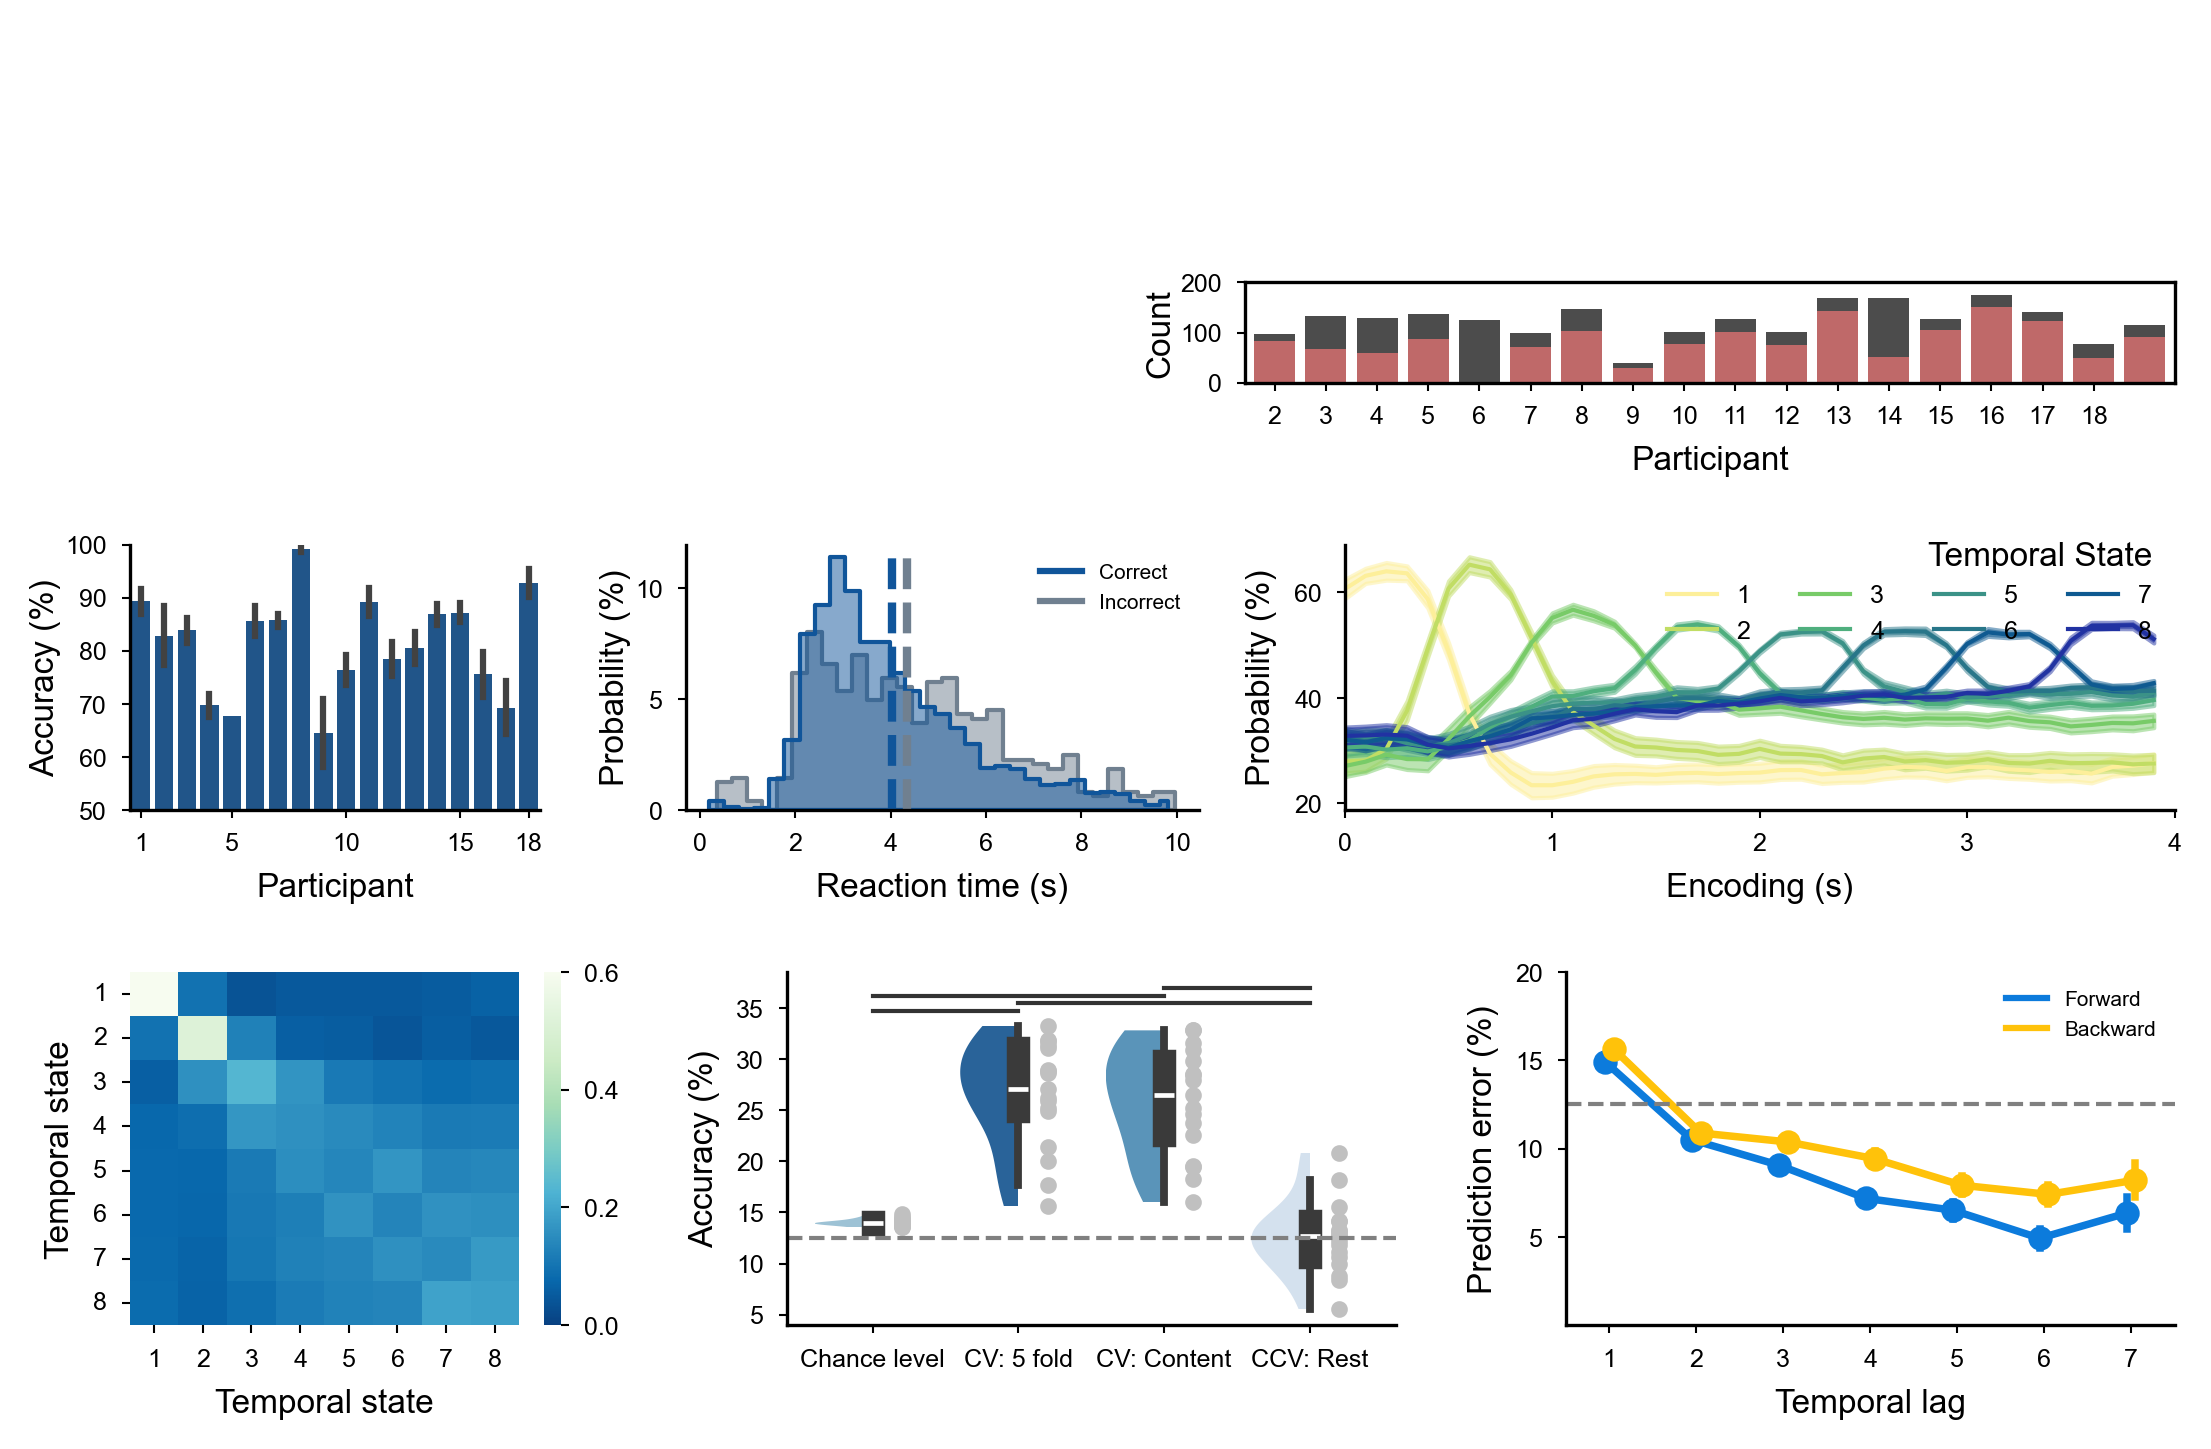

In [66]:
fig = plt.figure(figsize=(7.1,4.5), dpi=300)


gs = fig.add_gridspec(3,1,
                      hspace=.5, wspace=.01,
                        height_ratios=[.8,.6,.8],
                      left=0.02, right=0.98, bottom=0.02, top=0.98)
# axes = [fig.add_subplot(gs[i]) for i in range(3)]

gs_pic = gs[0].subgridspec(1, 2, wspace=.0, hspace=.01, width_ratios=[1.2,1])
gs_enc = gs[1].subgridspec(1, 3, wspace=.25, hspace=.01, width_ratios=[.8,1,1.618])
gs_pe = gs[2].subgridspec(1, 3, wspace=.3, width_ratios=[.8, 1,  1])

# gs_paradigm, gs_brains = gs_left.subgridspec(1, 2, wspace=.01, hspace=.01, width_ratios=[1.5,1])

# Experimental paradigm
ax_paradigm = fig.add_subplot(gs_pic[0])
ax_paradigm.axis('off')

# Recoding sites
gs_right = gs_pic[1].subgridspec(3, 2, wspace=.01,hspace=.01, 
                                 height_ratios = [1.25,1.25,1]
                                 )
for i, hemi in enumerate(['lh','rh']):
  for j, view in enumerate(['lateral', 'medial']):
    ax = fig.add_subplot(gs_right[j, i])
    ax.axis('off')

ax_channel_count = fig.add_subplot(gs_right[-1, :])
sns.histplot(data=anat_df,
             x='SubjectID', hue='Ch_type', 
             multiple='stack',
             hue_order=['Bad', 'Good'],
             palette={'Good':'brown', 'Bad':'k'},
             alpha=.7,
             discrete=True, 
             shrink=.8,
             legend=False,
             edgecolor=None,
             ax=ax_channel_count
             )

ax_channel_count.set_xlabel('Participant')
ax_channel_count.set_ylabel('Count', labelpad=1)
ax_channel_count.set_xticks(np.arange(18),np.arange(1,19))
ax_channel_count.set_yticks([0,100,200])
ax_channel_count.margins(x=0.01)


ax_response = fig.add_subplot(gs_enc[0])
sns.barplot(
    data=stats_df, x='SubjectID', y='TOJ_res', color='#10559a', 
    errorbar='se', units='Session',
    dodge=False, legend=False, ax=ax_response
)

ax_response.set_ylim([0.5,1])

ax_response.set_xlabel('Participant')
ax_response.set_ylabel('Accuracy (%)', labelpad=1)
ax_response.set_xticks([0,4,9,14,17],[1,5,10,15,18])
ax_response.set_yticks([0.5,.6,.7,.8,.9,1],[50,60,70,80,90,100])

sns.despine(ax=ax_response)

ax_rt = fig.add_subplot(gs_enc[1])
sns.histplot(data=beh_df, x='TOJ_RT',hue='TOJ_res', 
             stat='probability', 
             common_bins =True,
             palette={0:'slategray', 1:'#10559a'}, hue_order=[1,0],
             alpha=.5,
             common_norm=False, 
             multiple='dodge', element='step',
             legend=True,
             ax = ax_rt
             )


custom_lines =  [Line2D([0], [0], color='#10559a', lw=1.5, label='Correct'),
                Line2D([0], [0], color='slategray', lw=1.5,  label='Incorrect')]

ax_rt.legend(handles=custom_lines, 
              frameon=False, ncols=1,
              loc='upper right', 
              fontsize=5
)

ax_rt.axvline(4032.934837, lw=2, ls='--', color='#10559a')
ax_rt.axvline(4333.794239, lw=2, ls='--', color='slategray')

ax_rt.set_xticks([0,2000,4000,6000,8000,10000],[0,2,4,6,8,10])
ax_rt.set_yticks([0.,.05,0.1],[0,5,10])

ax_rt.set_ylabel('Probability (%)', labelpad=1)
ax_rt.set_xlabel('Reaction time (s)')

sns.despine(ax=ax_rt)

ax_probas = fig.add_subplot(gs_enc[-1])

# Encoding probas
_u = np.mean(enc_probas, axis=0)
_err = stats.sem(enc_probas, axis=0)
n_time, n_state = _u.shape
Xs = np.arange(n_time)

for state in range(n_state):
    u = _u[:,state]
    hb, lb = _u[:,state] + _err[:,state], _u[:,state] - _err[:,state]
    ax_probas.plot(Xs, u, label=state+1, color=state_cmaps(state))
    ax_probas.fill_between(Xs, lb, hb,  alpha=0.5, color=state_cmaps(state))
ax_probas.margins(x=0)
   
ax_probas.set_xlabel('Encoding (s)') 
ax_probas.set_ylabel('Probability (%)')   

ax_probas.set_yticks([.2,.4,.6],[20,40,60]) 
ax_probas.set_xticks([0,10,20,30,40],[0,1,2,3,4])

leg = ax_probas.legend(loc='upper right', ncols=4, frameon=False, 
              bbox_to_anchor = (1,1.1),
              # ha = 'right',
              title='Temporal State',  
              title_fontproperties=dict(family='arial', size=8),
              # prop={'family':'arial', 'size':12}
              )

leg._legend_box.align = "right"
    
sns.despine(ax=ax_probas)


ax_cm = fig.add_subplot(gs_pe[0])
hm = sns.heatmap(data = norm_cm /norm_cm.sum(axis=1, keepdims=True), cmap = 'GnBu_r', 
            square = False,
            cbar = True, 
            annot=False,
            vmin=0, vmax=.6,
            ax = ax_cm)

cbar = hm.collections[0].colorbar
cbar.set_ticks([0, 0.2, 0.4, 0.6])


ax_cm.set_xticks(np.arange(8)
                 +0.5, np.arange(1,9))
ax_cm.set_yticks(np.arange(8)+0.5, np.arange(1,9), rotation=0)

ax_cm.set_ylabel('Temporal state')
ax_cm.set_xlabel('Temporal state')


ax_acc = fig.add_subplot(gs_pe[1])
sns.violinplot(data=df_acc, x='Model', y='Accuracy', hue='Model', palette='Blues',
            order=['Chance', 'Accuracy', 'CV_Content', 'CV_Rest'],
            cut = 0,
            inner='box',
            hue_order=['CV_Rest', 'Chance', 'CV_Content', 'Accuracy'],
            # orient='h',
            ax = ax_acc
               )

for violin in ax_acc.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax_acc.transData))
    violin.set_edgecolor('none')

ax_acc.axhline(0.125, color='gray', linestyle='--')

xticks = {label.get_text(): idx for idx, label in enumerate(ax_acc.get_xticklabels())}

for idx, (a, b) in enumerate(sig_pairs):
    x1, x2 = xticks[a], xticks[b]
    y = .34 + (idx+1)*.0075
    ax_acc.plot([x1,  x2], [y,  y], lw=1, c='k', alpha=.8)

ax_acc.set_ylabel('Accuracy (%)')
ax_acc.set_xlabel('')
ax_acc.set_xticks(np.arange(4),['Chance level', 'CV: 5 fold', 'CV: Content', 'CCV: Rest'])
ax_acc.set_yticks([.05,.1,.15,.2,.25,.3,.35],[5,10,15,20,25,30,35])

for idx, grp in enumerate(['Chance', 'Accuracy', 'CV_Content', 'CV_Rest']):
    vals = df_acc[df_acc.Model==grp].Accuracy.values
    ax_acc.scatter([idx + .2]*len(vals), vals, color='silver', s=9)

sns.despine(ax=ax_acc)

# Prediction error ~ Lag
ax_error = fig.add_subplot(gs_pe[-1])

sns.pointplot(data=df_error[df_error.AbsLag > 0], 
              x='AbsLag', 
              y='Probability', 
              hue='Direction', 
              palette=dict(Forward='#0C7BDC', Backward='#FFC20A'),
              hue_order=['Forward','Backward'],
              errorbar='se', units='Subject', 
              dodge=.1,
              legend=False,
              ax=ax_error
              )
ax_error.axhline(0.125, color='gray', ls='--')

ax_error.set_yticks([.05,.1,.15,.2],[5,10,15,20])    
ax_error.set_ylim([0,.2])
ax_error.set_ylabel('Prediction error (%)')
ax_error.set_xlabel('Temporal lag')
sns.despine(ax=ax_error)


custom_lines =  [Line2D([0], [0], color='#0C7BDC', lw=1.5, label='Forward'),
                Line2D([0], [0], color='#FFC20A', lw=1.5,  label='Backward')]

ax_error.legend(handles=custom_lines, 
              frameon=False, ncols=1,
              loc='upper right', 
              fontsize=5
)

fig.align_xlabels([ax_cm, ax_error])
fig.align_xlabels([ax_probas, ax_rt, ax_response])

    
# fig.savefig(r"M1/FigM1.svg", format="svg", dpi=300,  bbox_inches="tight", transparent=True)
# fig.savefig(r"M1/FigS11.pdf", format="pdf", dpi=300,  bbox_inches="tight", transparent=True)

# M2

In [20]:
state_cmaps = plt.get_cmap(cmaps.haline.discrete(9).reversed())
cmap_list = [plt.get_cmap(cmaps.WhiteBlue.discrete(12).reversed()),
             plt.get_cmap(cmaps.gsdtol.discrete(12))]

## Read data

In [ ]:
_path = r'M2'
df_rsa = pd.read_csv(os.path.join(_path, 'Subject_fixed_betas_5fold.csv'))

group_cm = np.load(os.path.join(_path, 'RSA_rdms_5fold.npz'), allow_pickle=True)['neural_rdm']
model_rdms = np.load(os.path.join(_path, 'RSA_rdms_5fold.npz'), allow_pickle=True)['model_rdm'].item()
position_rdm = model_rdms['position']
category_rdm = model_rdms['category']
conjunction_rdm = model_rdms['conjunction']

In [18]:
aligned_coords = np.load(os.path.join(_path, 'NeuralRDM_MDS_5fold.npz'), allow_pickle=True)['aligned_coords']
Bca_betas = np.load(os.path.join(_path, 'Beta_Bca_CI_5fold.npz'), allow_pickle=True)['Bca_betas']

same_probas = np.load(os.path.join(_path, 'Encoding_probas_mixed_cv5.npz'), allow_pickle=True)['same_probas']
diff_probas = np.load(os.path.join(_path, 'Encoding_probas_mixed_cv5.npz'), allow_pickle=True)['diff_probas']

error_df = pd.read_csv(os.path.join(_path, 'Prediction_error_distance_5fold.csv'))

df_beta = pd.DataFrame(Bca_betas.tolist())
df_melt = df_rsa.melt(id_vars=['Subject'], value_vars=['Position', 'Category', 'Conjunction'], var_name='Model', value_name='Est')

yerr = np.array([df_beta['Est'] - df_beta['Lower'], df_beta['Upper'] - df_beta['Est']])

mean_coords, sem_coords = np.mean(aligned_coords, axis=0), stats.sem(aligned_coords, axis=0)


## Plot

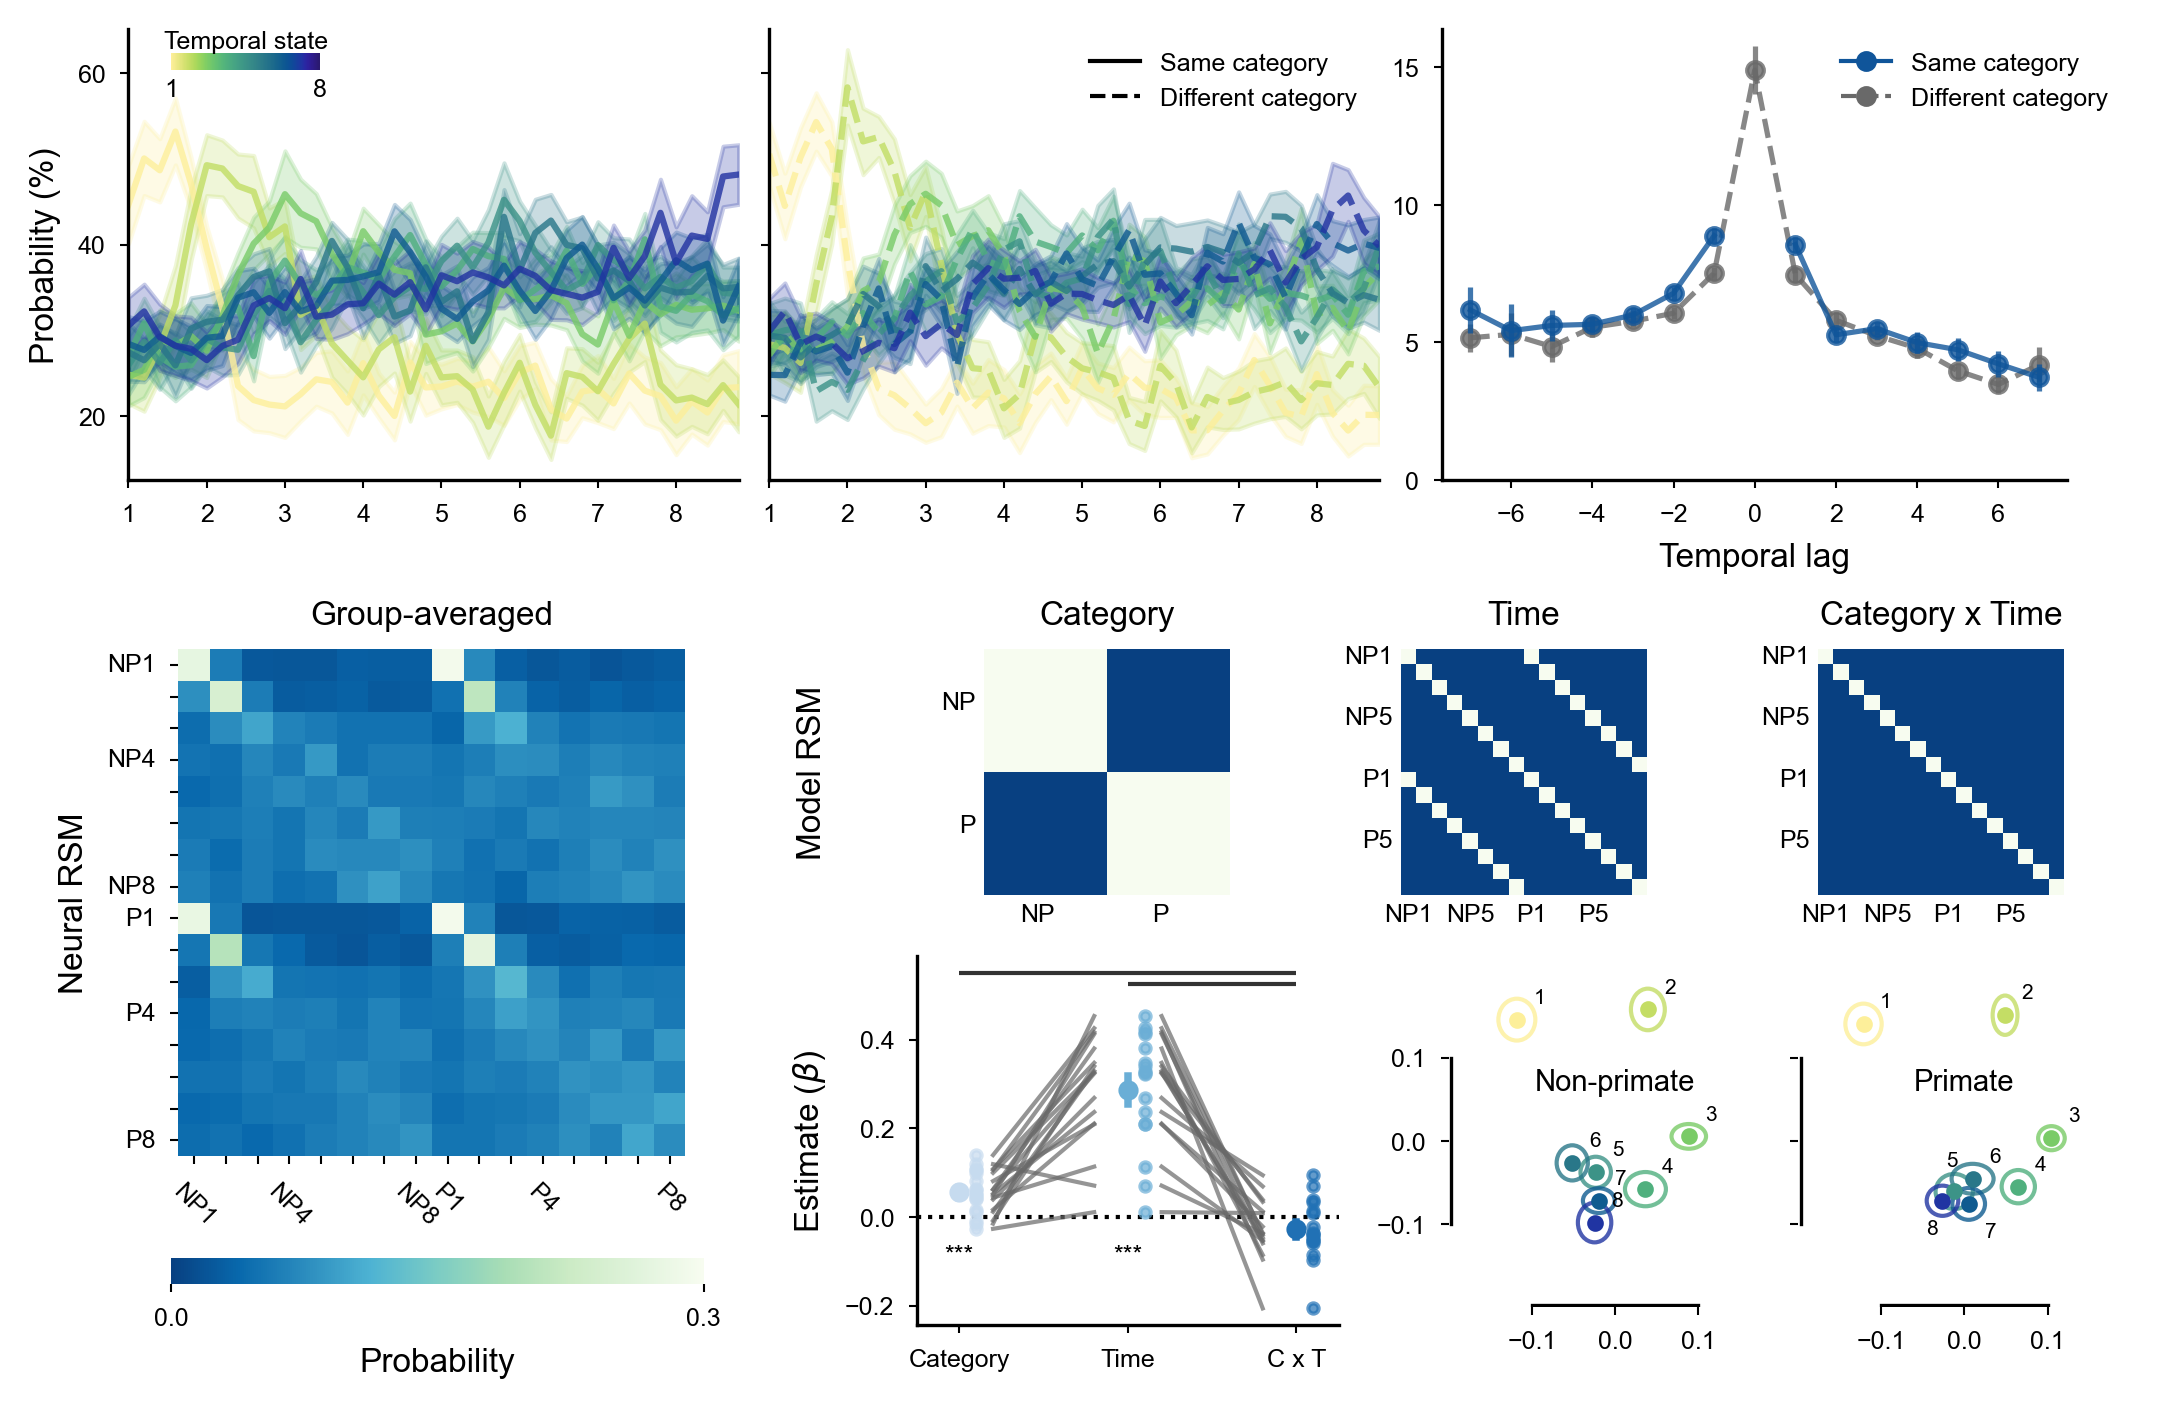

In [ ]:
from matplotlib.patches import Ellipse
fig = plt.figure(figsize=(7.1,4.5), dpi=300)

gs_main = fig.add_gridspec(
    nrows=2, ncols=1,
    # width_ratios=[1.,1],
    height_ratios=[1,1.5],
    top=0.98, bottom=0.02,
    left=0.04, right=0.98,
    hspace=0.3, 
    wspace=0.15
)

gs_probas = gs_main[0].subgridspec(
    nrows=1, ncols=3, 
    width_ratios=[2,1,.001],
    wspace= 0.1
)

gs_rsa = gs_main[1].subgridspec(
    nrows=2, ncols=2, 
    width_ratios=[1,2], height_ratios=[1,1.5],
    hspace= 0.2, wspace=0.2
)

gs_models = gs_rsa[0,1].subgridspec(
    nrows=1, ncols=3,
    wspace=0.1
)

gs_stats = gs_rsa[1,1].subgridspec(
    nrows=1, ncols=2,
    width_ratios=[1,1.618],
    wspace=.2,
    hspace=.15,
)

gs_mds = gs_stats[1].subgridspec(
    nrows=1, ncols=2,
    wspace=.05
)

gs_probas_cond = gs_probas[0].subgridspec(
    nrows=1, ncols=2,
    width_ratios=[1,1],
    wspace=0.05
)

axes_probas = [fig.add_subplot(gs_probas_cond[_]) for _ in range(2)]
ax_crp = fig.add_subplot(gs_probas[1])
axes_models = [fig.add_subplot(gs_models[i]) for i in range(3)]
axes_mds = [fig.add_subplot(gs_mds[i]) for i in range(2)]
ax_beta = fig.add_subplot(gs_stats[0])


axes_probas[1].sharex(axes_probas[0])
axes_probas[1].sharey(axes_probas[0])

for ax, cond_name, probas, colors in zip(axes_probas, ["Same", 'Different'], [same_probas, diff_probas], cmap_list):
    state_mean = np.mean(probas, axis=0).T
    state_err = stats.sem(probas, axis=0).T

    ls = 'dashed' if cond_name == 'Different' else 'solid'
    
    for i, _u, _err in zip(np.arange(state_mean.shape[0]), state_mean, state_err):
        c = state_cmaps(i)
        ax.plot(_u, color=c, alpha=.8, lw=1.5, ls=ls)
        ax.fill_between(np.arange(len(_u)), _u - _err, _u + _err, color=c, alpha=.25)
    ax.margins(x=0)
    ax.set_xticks(np.arange(0,40,5),np.arange(1,9))
    ax.set_yticks([.2,.4,.6])
    sns.despine(ax=ax)
    

axes_probas[1].tick_params(labelleft=False)
axes_probas[0].set_ylabel('Probability (%)')
axes_probas[0].yaxis.set_major_formatter(FuncFormatter(lambda x,position: '%1.0f'%(100*x)))

norm = plt.Normalize(vmin=1, vmax=8)
sm = plt.cm.ScalarMappable(cmap=cmaps.haline.reversed(), norm=norm)
sm.set_array([])

pos = axes_probas[1].get_position()
cax = fig.add_axes([.06, 0.95, 0.07, .0125]) # left, bottom, width, height
cbar_prob = fig.colorbar(sm, cax=cax, orientation='horizontal', ticks=[1,8])
cbar_prob.ax.set_title('Temporal state', fontsize=6, pad=0.2)
cbar_prob.outline.set_visible(False)
cbar_prob.ax.tick_params(bottom=False, pad=0)


from matplotlib.lines import Line2D
custom_lines =  [Line2D([0], [0], color='k', linestyle='-', label='Same category'),
                Line2D([0], [0], color='k', linestyle='--', label='Different category')]

axes_probas[1].legend(handles=custom_lines, 
              frameon=False, ncols=1,
              loc='upper right', 
)


for cat, cat_data in error_df.groupby('SameCategory'):
    ls = 'dashed' if not cat else 'solid'
    color = '#10559a' if cat else 'dimgrey'
    
    time_distances = np.array(sorted(cat_data['TimeDistance'].unique()))
    time_mean = cat_data.groupby('TimeDistance')['Probability'].mean()
    time_sem = cat_data.groupby('TimeDistance')['Probability'].sem()
    
    if 0 in time_distances:
        mask = [np.ones_like(time_distances, dtype=bool)]
    else:
        mask = [time_distances < 0, time_distances > 0]
        
    for m in mask:
        ax_crp.errorbar(time_distances[m], time_mean[m], yerr=time_sem[m],
                        color=color,
                        linestyle=ls,  
                        capsize=0,
                        alpha=0.8,
                        markersize=4, marker='o',lw=1.25,
                        zorder=10 if cat else 5)
    
    
    
h, l = ax_crp.get_legend_handles_labels()
ax_crp.legend(h, ['Same category', 'Different category'], frameon=False)

ax_crp.set_ylabel('')
ax_crp.set_xlabel('Temporal lag')
ax_crp.set_yticks([0,.05,.10,.15])
ax_crp.yaxis.set_major_formatter(FuncFormatter(lambda x,position: '%1.0f'%(100*x)))

sns.despine(ax=ax_crp)

custom_lines = [
    Line2D([0], [0], color='#10559a', linestyle='-', marker='o', markersize=4, label='Same category'),
    Line2D([0], [0], color='dimgrey', linestyle='--', marker='o', markersize=4, label='Different category')
]

ax_crp.legend(handles=custom_lines, 
              frameon=False, 
              loc='upper right', bbox_to_anchor=(1.1,1),
              )

ax_cm = fig.add_subplot(gs_rsa[:,0])
sns.heatmap(np.mean(group_cm,axis=0), 
            cmap='GnBu_r', 
            square=True, vmax=.3, vmin=0,
            cbar=True, 
            cbar_kws={'orientation': 'horizontal', 'shrink': .65 ,
                      'pad':0.1,
                      'aspect':20, 
                      'ticks':[0,.3],
                      },
            ax=ax_cm)
ax_cm.set_title('Group-averaged', fontsize=8)
ax_cm.set_ylabel('Neural RSM', fontsize=8)
ax_cm.set_xticklabels(
                 ['NP1','','','NP4','','','', 'NP8', 'P1','','', 'P4','','','', 'P8'], rotation=-45)
ax_cm.set_yticklabels(
                 ['NP1','','','NP4','','','', 'NP8', 'P1','','', 'P4','','','', 'P8'], rotation=0)

cbar = ax_cm.collections[0].colorbar
cbar.ax.set_xlabel('Probability')
cbar.ax.set_position([0.06, 0.05, 0.25, 0.02])  # [left, bottom, width, height]



for ax, model_rdm, model_name in zip(axes_models, [category_rdm, position_rdm, conjunction_rdm], ['Category',  'Time', 'Category x Time']):
    sns.heatmap(model_rdm, cmap='GnBu_r', square=True, cbar=False, vmax=.5, vmin=0,
                ax=ax
                )
    ax.tick_params(left=False, bottom=False, pad=0)
    ax.set_title(model_name, fontsize=8)
    
    if model_name == 'Category':
        ax.set_xticks([3.5,11.5], ['NP', 'P'])
        ax.set_yticks([3.5,11.5],['NP', 'P'],rotation=0)
    elif model_name == 'Position':
        ax.set_xticks([.5,8.5], ['NP1', 'P1'])
        ax.set_yticks([.5,8.5], ['NP1', 'P1'], rotation=0)
    else:
        ax.set_xticks([0.5,4.5,8.5,12.5], ['NP1','NP5', 'P1','P5'])
        ax.set_yticks([0.5,4.5,8.5,12.5], ['NP1','NP5', 'P1','P5'], rotation=0)
        

axes_models[0].set_ylabel('Model RSM', fontsize=8)
fig.align_ylabels([axes_models[0], ax_beta])

x = np.arange(len(df_beta['Model']))

cmap = plt.get_cmap('Blues', 5)
colors = [cmap(i+1) for i in range(3)]
models = ['Category', 'Position', 'Conjunction']

sns.pointplot(data=df_melt, x='Model', y='Est', hue='Model', palette='Blues',
              order=models,
              hue_order=models,
              markersize=3.5, 
            errorbar='se',
              orient='v',zorder=5,
              ax=ax_beta)

ax_beta.axhline(0, color='k', linestyle='dotted', zorder=0)
ax_beta.set_xlabel('')
ax_beta.set_ylabel(r'Estimate ($\beta$)')
sns.despine(ax=ax_beta)

for i, col in enumerate(models):
    vals = df_rsa[col]
    ax_beta.scatter(np.ones_like(vals)*i + .1, vals, color=colors[i], s=6, alpha=0.7, zorder=3)
    
for i in range(2):
    vals_i, vals_j = df_rsa[models[i]], df_rsa[models[i+1]]
    ax_beta.plot([i+.2, i+.8], [vals_i, vals_j], color='dimgray', alpha=0.7, zorder=1)
    
ax_beta.text(0,-0.1,'***', color='k', zorder=4, ha='center', fontsize=6)
ax_beta.text(1,-0.1,'***', color='k', zorder=4, ha='center', fontsize=6)


ax_beta.hlines(0.5, 1,1, color='k', alpha=.8)
ax_beta.hlines(0.525, 1,2, color='k', alpha=.8)
ax_beta.hlines(0.55, 0,2, color='k', alpha=.8)

ax_beta.set_yticks([-.2,0,.2,.4])
ax_beta.set_xlim([-.25,2.25])
ax_beta.set_xticks(x, ['Category','Time','C x T'])

colors = cmaps.haline(np.linspace(0, 1, 9))[::-1]
for (cond_idx, cond_name), ax in zip(enumerate(["Non-primate", 'Primate']), axes_mds):
    for t in range(8):
        i = cond_idx * 8 + t
        x, y = mean_coords[i]
        ex, ey = sem_coords[i]
        c = colors[t]
        
        ellipse = Ellipse(
            (x, y),
            width=2 * ex,
            height=2 * ey,
            edgecolor=c,
            facecolor="none",
            linewidth=1,
            alpha=0.8,
        )
        ax.add_patch(ellipse)
        ax.scatter(x, y, color=c, s=9, zorder=3)

        if cond_idx == 1 and t >3:
            text_loc = {
                4:(x - 0.01, y + 0.03),
                5:(x + 0.02, y + 0.02),
                6:(x + 0.02, y - 0.04),
                7:(x - 0.02, y - 0.04)
            }
            ax.text(*text_loc[t], f"{t+1}", fontsize=5)
        else:
            ax.text(x + 0.02, y + 0.02, f"{t+1}", fontsize=5)

    ax.set_aspect("equal")
    ax.text(0, 0.07, cond_name, fontsize=7, ha='center', va='center')
    sns.despine(ax=ax)

axes_mds[1].sharex(axes_mds[0])
axes_mds[1].sharey(axes_mds[0])
axes_mds[1].tick_params(labelleft=False)


for ax in axes_mds:
    sns.despine(ax=ax,left=True,bottom=True)

    ax.plot([-0.197, -0.197], [-.1,.1], color='k', lw=.8)
    ax.plot([-0.1, 0.1], [-.197,-.197], color='k', lw=.8)  
    ax.set_ylim([-.2,.2])
    ax.set_xlim([-.2,.2])
    ax.set_xticks([-0.1, 0, 0.1])
    ax.set_yticks([-0.1, 0, 0.1])

# fig.savefig(r"M2/FigM2.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)
# fig.savefig(r"M2/FigM2.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True) 

# M3

## Read data

In [ ]:
_path = r'M3'

data = np.load(os.path.join(_path, r'Group_TDLM_benchmark.npz'), allow_pickle=True)
tdlm_obs = data['data'].item()
lag_rng = data['lag_rng']
del data

_sum = lambda arr: np.sum(arr, axis=-1)
_fwd = lambda arr: arr[...,0]
_rev = lambda arr: arr[...,1]
_diff = lambda arr: arr[...,0] - arr[...,1]

In [24]:
replay_examples = np.load(os.path.join(_path,"Exp1_replay_examples.npz"), allow_pickle=True)['data'].item()

tdlm_content = np.load(os.path.join(_path,r"TDLM_per_category.npz"), allow_pickle=True)['group_tdlm'].item()
tdlm_sec = np.load(os.path.join(_path,r"TDLM_per_minute.npz"), allow_pickle=True)['data']

tdlm_seq = np.load(os.path.join(_path,r"TDLM_sub_sequence.npz"), allow_pickle=True)['data'].item()

threshold_dict = np.load(os.path.join(_path,r"TDLM_per_minute.npz"), allow_pickle=True)['threshold'].item()

In [ ]:
df_group = pd.read_csv(os.path.join(_path,r"TDLM_benchmark_beh_group.csv"))

df_trial = pd.read_csv(os.path.join(_path,r"TDLM_benchmark_beh_trial.csv"))
df_trial = df_trial[(df_trial.TOJ_res==1)&(df_trial.TOJ_RT >= 2000)].reset_index(drop=True)
df_trial['RT'] = np.log(df_trial.TOJ_RT/1e3) # to sec

df_fixef = pd.read_csv(os.path.join(_path,r"TDLM_benchmark_trial_boot_stats.csv")) # Fitting from 'lmer(RT ~ SeqOn + SeqOff  + (1|Subject)')

## Plot

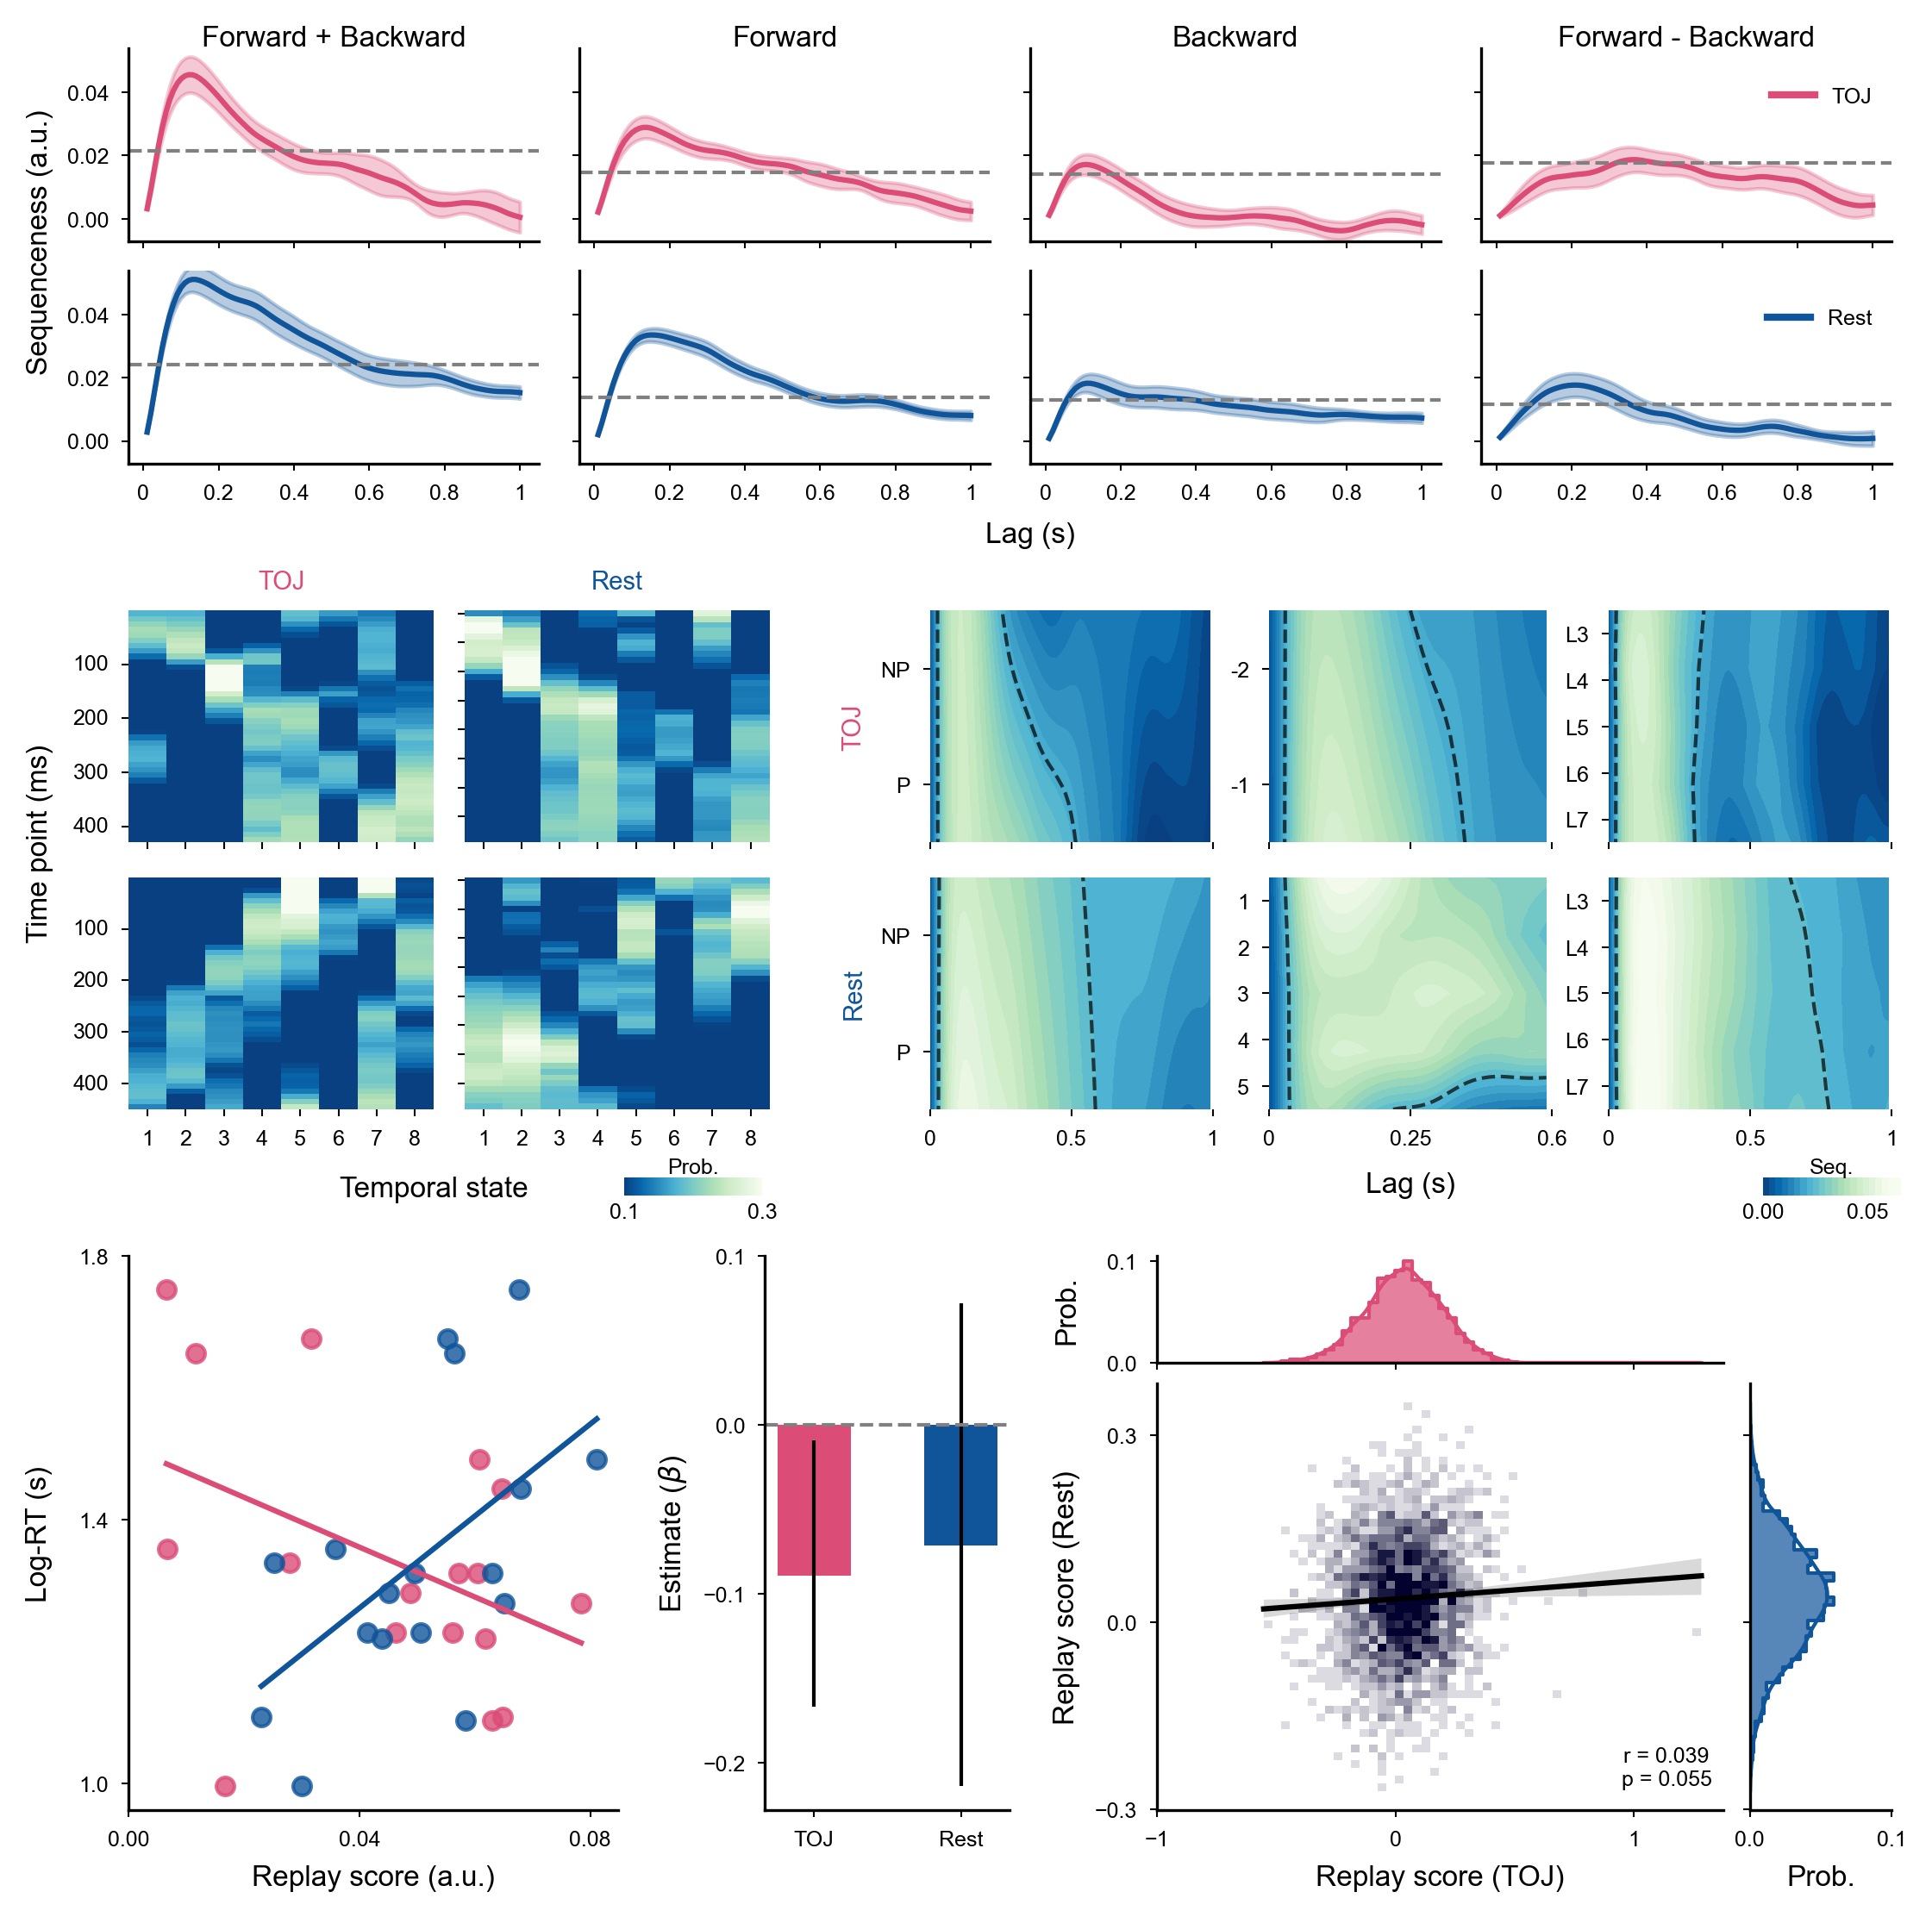

In [ ]:
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color="#db4c77", lw=2, label="TOJ"),
    Line2D([0], [0], color="#10559a", lw=2, label="Rest"),
]


fig = plt.figure(figsize=(7.1,7.1), dpi=300)
gs = fig.add_gridspec(3, 1,
                      height_ratios = [.75,.9,1],
                    #   width_ratios = [1.5,1,1,1],
                      left=.02, right=.98, bottom=.02, top=.98,
                      wspace=.1, 
                      hspace=.3
                      )

gs_tdlm = gs[0].subgridspec(2,4, wspace=0.1, hspace=.15)

gs_heatmap = gs[1].subgridspec(2,2, width_ratios=[1,1.5])
gs_example = gs_heatmap[:,0].subgridspec(2,2, wspace=0.1, hspace=.15)
gs_robust = gs_heatmap[:,1].subgridspec(2,3, 
                                        wspace=0.2, hspace=.15)

gs_beh = gs[2].subgridspec(1,3, width_ratios=[2,1,3], wspace=0.3, hspace=.1)

gs_hist = gs_beh[2].subgridspec(nrows=2, ncols=2,
                               height_ratios=[1, 4],
                               width_ratios=[4, 1],
                               hspace=0.075, wspace=0.075)

ax_group = fig.add_subplot(gs_beh[0])
ax_trial = fig.add_subplot(gs_beh[1])

ax_joint = fig.add_subplot(gs_hist[1, 0])
ax_margx = fig.add_subplot(gs_hist[0, 0], sharex=ax_joint)
ax_margy = fig.add_subplot(gs_hist[1, 1], sharey=ax_joint)

# TDLM results
axes_tdlm = list()
for (ri, event) in enumerate(['TOJ','Rest']):
  for func, (ci, name) in zip([_sum, _fwd, _rev, _diff], 
                              enumerate(['Forward + Backward', 'Forward', 'Backward', 'Forward - Backward'])):
    ax = fig.add_subplot(gs_tdlm[ri, ci])
    axes_tdlm.append(ax)

    vals = func(np.array(tdlm_obs[event]['obs']))
    mean_vals = np.mean(vals, axis=0)
    sem_vals = stats.sem(vals, axis=0)

    null_dist = func(np.array(tdlm_obs[event]['perm'])).mean(axis=0)
    if name == 'Forward - Backward':
      null_dist = np.abs(null_dist)
    thresh = np.percentile(null_dist.max(axis=0), 95)
    
    ax.plot(lag_rng, mean_vals, color=color_dict[event], lw=1.5)
    ax.fill_between(lag_rng, mean_vals - sem_vals, mean_vals + sem_vals, 
                    color=color_dict[event], alpha=0.3)
    ax.axhline(thresh, color='gray', linestyle='--', linewidth=1)
    sns.despine(ax=ax)
    
    if ri == 0:
      ax.tick_params(labelbottom=False)
      ax.set_title(name, fontsize=8, y=.9)
    else:
      ax.set_xticks(np.arange(0,101,20),[0,.2,.4,.6,.8,1])
    if ci != 0:
      ax.tick_params(labelleft=False)
      
  for ax in axes_tdlm[1:]:
    ax.sharey(axes_tdlm[0])

axes_tdlm[0].set_ylabel('Sequenceness (a.u.)', va='center', 
                        y = 0, 
                        labelpad=7.5
                        )

axes_tdlm[6].set_xlabel('Lag (s)', ha='center', 
                        x = 0, 
                        labelpad=5
                        )

for i, leg in zip([3,-1], custom_lines):
  axes_tdlm[i].legend(handles=[leg], frameon=False,
                      loc='upper right',
                       bbox_to_anchor=(1, .9),
                      ncols=1, 
                      )
# Replay examples
axes_example = list()
for ci, event in enumerate(['TOJ','Rest']):
  event_dict = replay_examples[event]
  for ri, direc in enumerate(['F','R']):
    sample_cm = event_dict[direc]
    
    ax = fig.add_subplot(gs_example[ri, ci])
    axes_example.append(ax)
    sns.heatmap(sample_cm, cmap='GnBu_r', vmin=.1, vmax=.3, cbar=False, ax=ax
                )
    ax.set_aspect('auto')
    
    if ri == 0:
      ax.tick_params(labelbottom=False)
      ax.set_title(event, color=color_dict[event], fontsize=7)
    else:
      ax.set_xticklabels(np.arange(1,9))
      
    if ci == 1:
      ax.tick_params(labelleft=False)
    else:
      ax.set_yticks([10,20,30,40],[100,200,300,400],rotation=0)
    
    ax.set_aspect('auto')
    sns.despine(ax=ax, left=True, bottom=True)
    
axes_example[0].set_ylabel('Time point (ms)',y=0, va='center', labelpad=7.5)
axes_example[-1].set_xlabel('Temporal state',x=-.1, ha='center', labelpad=7.5)    


# Robustness check: content - per second - sequence length
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax=0.06)

axes_robust = list()
## Content
for ri, event in enumerate(['TOJ','Rest']):
  vals = np.mean([tdlm_content[event]['NP'], tdlm_content[event]['P']], axis=1)
  
  ax = fig.add_subplot(gs_robust[ri, 0])
  axes_robust.append(ax)
  X, Y = np.meshgrid(np.arange(vals.shape[1]), np.arange(vals.shape[0]))
  contourf = ax.contourf(X, Y, vals, levels=20, cmap='GnBu_r', 
                           norm=norm
                           )
  contour = plt.contour(X, Y, vals, levels=[threshold_dict[event][0]], colors="k", 
                      linewidths=1, alpha=.7,
                      linestyles ='dashed')

  if event == 'TOJ':
    ax.tick_params(labelbottom=False)
    ax.set_xticks(np.arange(0,101,50))
  else:
    ax.set_xticks(np.arange(0,101,50),[0,.5,1])

  ax.set_yticks([0.25,0.75],['P','NP'])
  ax.set_ylabel(event, color=color_dict[event], fontsize=7)
  sns.despine(ax=ax, bottom=True, left=True)


## Per second
for ri, event in enumerate(['TOJ','Rest']):
  ax = fig.add_subplot(gs_robust[ri, 1])
  axes_robust.append(ax)
  if event == 'TOJ':
    vals = np.mean(tdlm_sec,axis=0)[:2,:]
  else:
    vals = np.mean(tdlm_sec,axis=0)[2:,:]

  X, Y = np.meshgrid(np.arange(vals.shape[1]), np.arange(vals.shape[0]))
  contourf = ax.contourf(X, Y, vals, levels=20, cmap='GnBu_r', 
                           norm=norm
                          )
  contour = plt.contour(X, Y, vals, levels=[threshold_dict[event][0]], colors="k", 
                      linewidths=1, alpha=.7,
                      linestyles ='dashed')
  
  sns.despine(ax=ax, bottom=True, left=True)
  ax.set_aspect('auto')
  
  if event == 'TOJ':
    ax.tick_params(labelbottom=False)
    ax.set_yticks([.75,.25],[-2,-1])
    ax.set_xticks(np.arange(0,51,25))
  else:
    ax.set_yticks(np.arange(0.4,4,0.8), np.arange(5,0,-1))
    ax.set_xticks(np.arange(0,51,25),[0,.25,.6])
    ax.set_xlabel('Lag (s)', ha='center',va='center', labelpad=10)


# Sequence X
for ri, event in enumerate(['TOJ','Rest']):
  vals = np.array([tdlm_seq[event][j] for j in range(3,8)])

  ax = fig.add_subplot(gs_robust[ri, 2])
  axes_robust.append(ax)
  X, Y = np.meshgrid(np.arange(vals.shape[1]), np.arange(vals.shape[0]))
  contourf = ax.contourf(X, Y, vals, levels=20, cmap='GnBu_r', 
                           norm=norm
                            )
  contour = plt.contour(X, Y, vals, levels=[threshold_dict[event][0]], colors="k", 
                      linewidths=1, alpha=.7,
                      linestyles ='dashed')
  
  if event == 'TOJ':
    ax.tick_params(labelbottom=False)
    ax.set_xticks(np.arange(0,101,50))
  else:
    ax.set_xticks(np.arange(0,101,50),[0,.5,1])

  ax.set_yticks(np.arange(0.4,4,0.8), [f'L{i}' for i in np.arange(7,2,-1)])
  sns.despine(ax=ax, bottom=True, left=True)
  


# Group regression
for event, col in zip(['TOJ','Rest'], ['SeqOn','SeqOff']):
    sns.regplot(data=df_group, y='Correct_RT', x=col, 
                ci=0,
                ax=ax_group, 
                label=event,
                color=color_dict[event],
                scatter_kws={'s':25, 'alpha':0.8},
                line_kws={'lw':1.5}
                )
  # ax_group.set_xticks()
ax_group.set_ylabel('Log-RT (s)'
                    # , labelpad=10
                    )
ax_group.set_xlabel('Replay score (a.u.)')

ax_group.set_yticks([1,1.4,1.8])
ax_group.set_xticks([0,0.04,0.08])

sns.despine(ax=ax_group)
  

# trial-level estimate
for x_pos, event in zip([0.2, 0.8], ['TOJ', 'Rest']):
    res = df_fixef[df_fixef.param == ('SeqOn' if event=='TOJ' else 'SeqOff')].iloc[0]

    ax_trial.bar(x_pos, res['est'], 
                yerr=np.expand_dims([res['est'] - res['ci_lower'], res['ci_upper'] - res['est']], axis=1),
                width=0.3, lw=1.5,
                color=color_dict[event]
                )
        

ax_trial.axhline(0, color='gray', linestyle='--', linewidth=1)
sns.despine(ax=ax_trial)
ax_trial.set_yticks([-.2,-.1,0,.1])
ax_trial.set_ylabel(r'Estimate ($\beta$)')
ax_trial.set_xlim([0,1])
ax_trial.set_xticks([0.2,0.8],['TOJ','Rest'])

# Joint distribution
sns.histplot(data=df_trial, x="SeqOn", y="SeqOff", pmax=0.8, bins=50,
             ax=ax_joint, 
             cbar=False,
             cmap="light:#03012d",
             )
sns.regplot(data=df_trial, x="SeqOn", y="SeqOff", 
                ax=ax_joint, 
                scatter=False,
                color='k', 
                line_kws={'lw':1.5}
                )
r, p = stats.spearmanr(df_trial["SeqOn"], df_trial["SeqOff"])
ax_joint.text(0.9, 0.05, f'r = {r:.3f}\np = {p:.3f}',  
              fontsize=6,
                transform=ax_joint.transAxes, 
                # bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
                va='bottom', ha='center')

sns.histplot(data=df_trial, x="SeqOn", kde=True, alpha=0.7, color=color_dict['TOJ'], 
                ax=ax_margx, stat='probability', bins=50,
                element="step"
                )

sns.histplot(data=df_trial, y="SeqOff", kde=True, alpha=0.7, color=color_dict['Rest'], 
                ax=ax_margy, stat='probability', bins=50,
                element="step"
                )

ax_joint.set_xticks([-1,0,1])
ax_joint.set_yticks([-.3,0,.3])
ax_joint.set_xlabel('Replay score (TOJ)')
ax_joint.set_ylabel('Replay score (Rest)')


ax_margx.tick_params(axis='x', labelbottom=False)
ax_margx.set_xlabel('')
ax_margx.set_ylabel("Prob.")
ax_margx.set_yticks([0,.1])

ax_margy.tick_params(axis='y', labelleft=False)
ax_margy.set_xlabel("Prob.")
ax_margy.set_ylabel('')
ax_margy.set_xticks([0,.1])

for ax in [ax_margx, ax_margy, ax_joint]:
  sns.despine(ax=ax)


# Colorbar
cax_example = fig.add_axes([.29, 0.355, 0.075, .01]) # left, bottom, width, height
cbar_example = fig.colorbar(axes_example[-1].collections[0], 
                         cax=cax_example, 
                         orientation='horizontal', 
                         ticks=[0.1,0.3])
cbar_example.ax.set_title('Prob.', fontsize=6, pad=1)
cbar_example.outline.set_visible(False)
cbar_example.ax.tick_params(bottom=False, pad=0)



cax_robust = fig.add_axes([.91, 0.355, 0.075, .01]) # left, bottom, width, height
cbar_robust = fig.colorbar(axes_robust[-1].collections[0], 
                         cax=cax_robust, 
                         orientation='horizontal', 
                         ticks=[0.,0.05])
cbar_robust.ax.set_title('Seq.', fontsize=6, pad=1)
cbar_robust.outline.set_visible(False)
cbar_robust.ax.tick_params(bottom=False, pad=0)

fig.align_ylabels([ax_joint, ax_margx])
fig.align_xlabels([ax_joint, ax_margy])
fig.align_ylabels([axes_tdlm[0],ax_group, axes_example[0]])
fig.align_xlabels([axes_example[-1], axes_robust[3]])
   
# fig.savefig(r"M3/FigM3.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)
# fig.savefig(r"M3/FigM3.pdf", format="pdf", dpi=300, bbox_inches="tight", transparent=True) 

# M4

## Read data

In [ ]:
_path = r'M4'

In [35]:
group_lfp = np.load(os.path.join(_path, 'Ripple_peri_Norman.npz'))['peri_lfp']
group_power = np.load(os.path.join(_path, 'Ripple_peri_Norman.npz'))['peri_power']
group_dict = np.load(os.path.join(_path, 'Ripple_histogram_CA1.npz'), allow_pickle=True)['data'].item()


example_data = np.load(os.path.join(_path, 'SWR_Detection_examples.npz'), allow_pickle=True)

ripple_dir = 'CA1'
bin_size = .1
sigma = 1.5

fn = os.path.join(_path, f'Group_event_ripple_psth_{ripple_dir}_{int(bin_size*1000)}ms_{sigma}sigma_smoothed.npz')
group_psth = np.load(fn, allow_pickle=True)['data'].item()

group_perm = np.load(os.path.join(_path, 'Peri_Ripple_TDLM_CA1_avg_lag.npz'), allow_pickle=True)['data'].item() 
correct_perm = np.load(os.path.join(_path, 'Peri_Ripple_TDLM_CA1_avg_lag_correctness.npz'), allow_pickle=True)['data'].item() 

In [38]:
sig_cluster = {
    'correct':{'TOJ':[[655,852]]},
    'all':{'TOJ':[[629,922]]}
}

In [42]:
sig_cluster['correct'].get('Rest')

In [37]:
df = pd.read_csv(os.path.join(_path, 'Event_ripple_records.csv'))
df_ripple = df.groupby(['Site','Event','Correct']).aggregate({'Ripple_counts':'sum','Event_duration':'sum'}).reset_index(drop=False)
df_ripple['RippleRate'] = df_ripple.Ripple_counts / df_ripple.Event_duration

In [46]:
group_values = pd.read_csv(os.path.join(_path, 'Ripple_replay_evidence_cluster_summary.csv'))

In [49]:
data = np.load(os.path.join(_path,'Ripple_replay_differene_bootstrap.npz'), allow_pickle=True)
tobs = data['tobs']
bootstrap_null = data['null']

## Plot

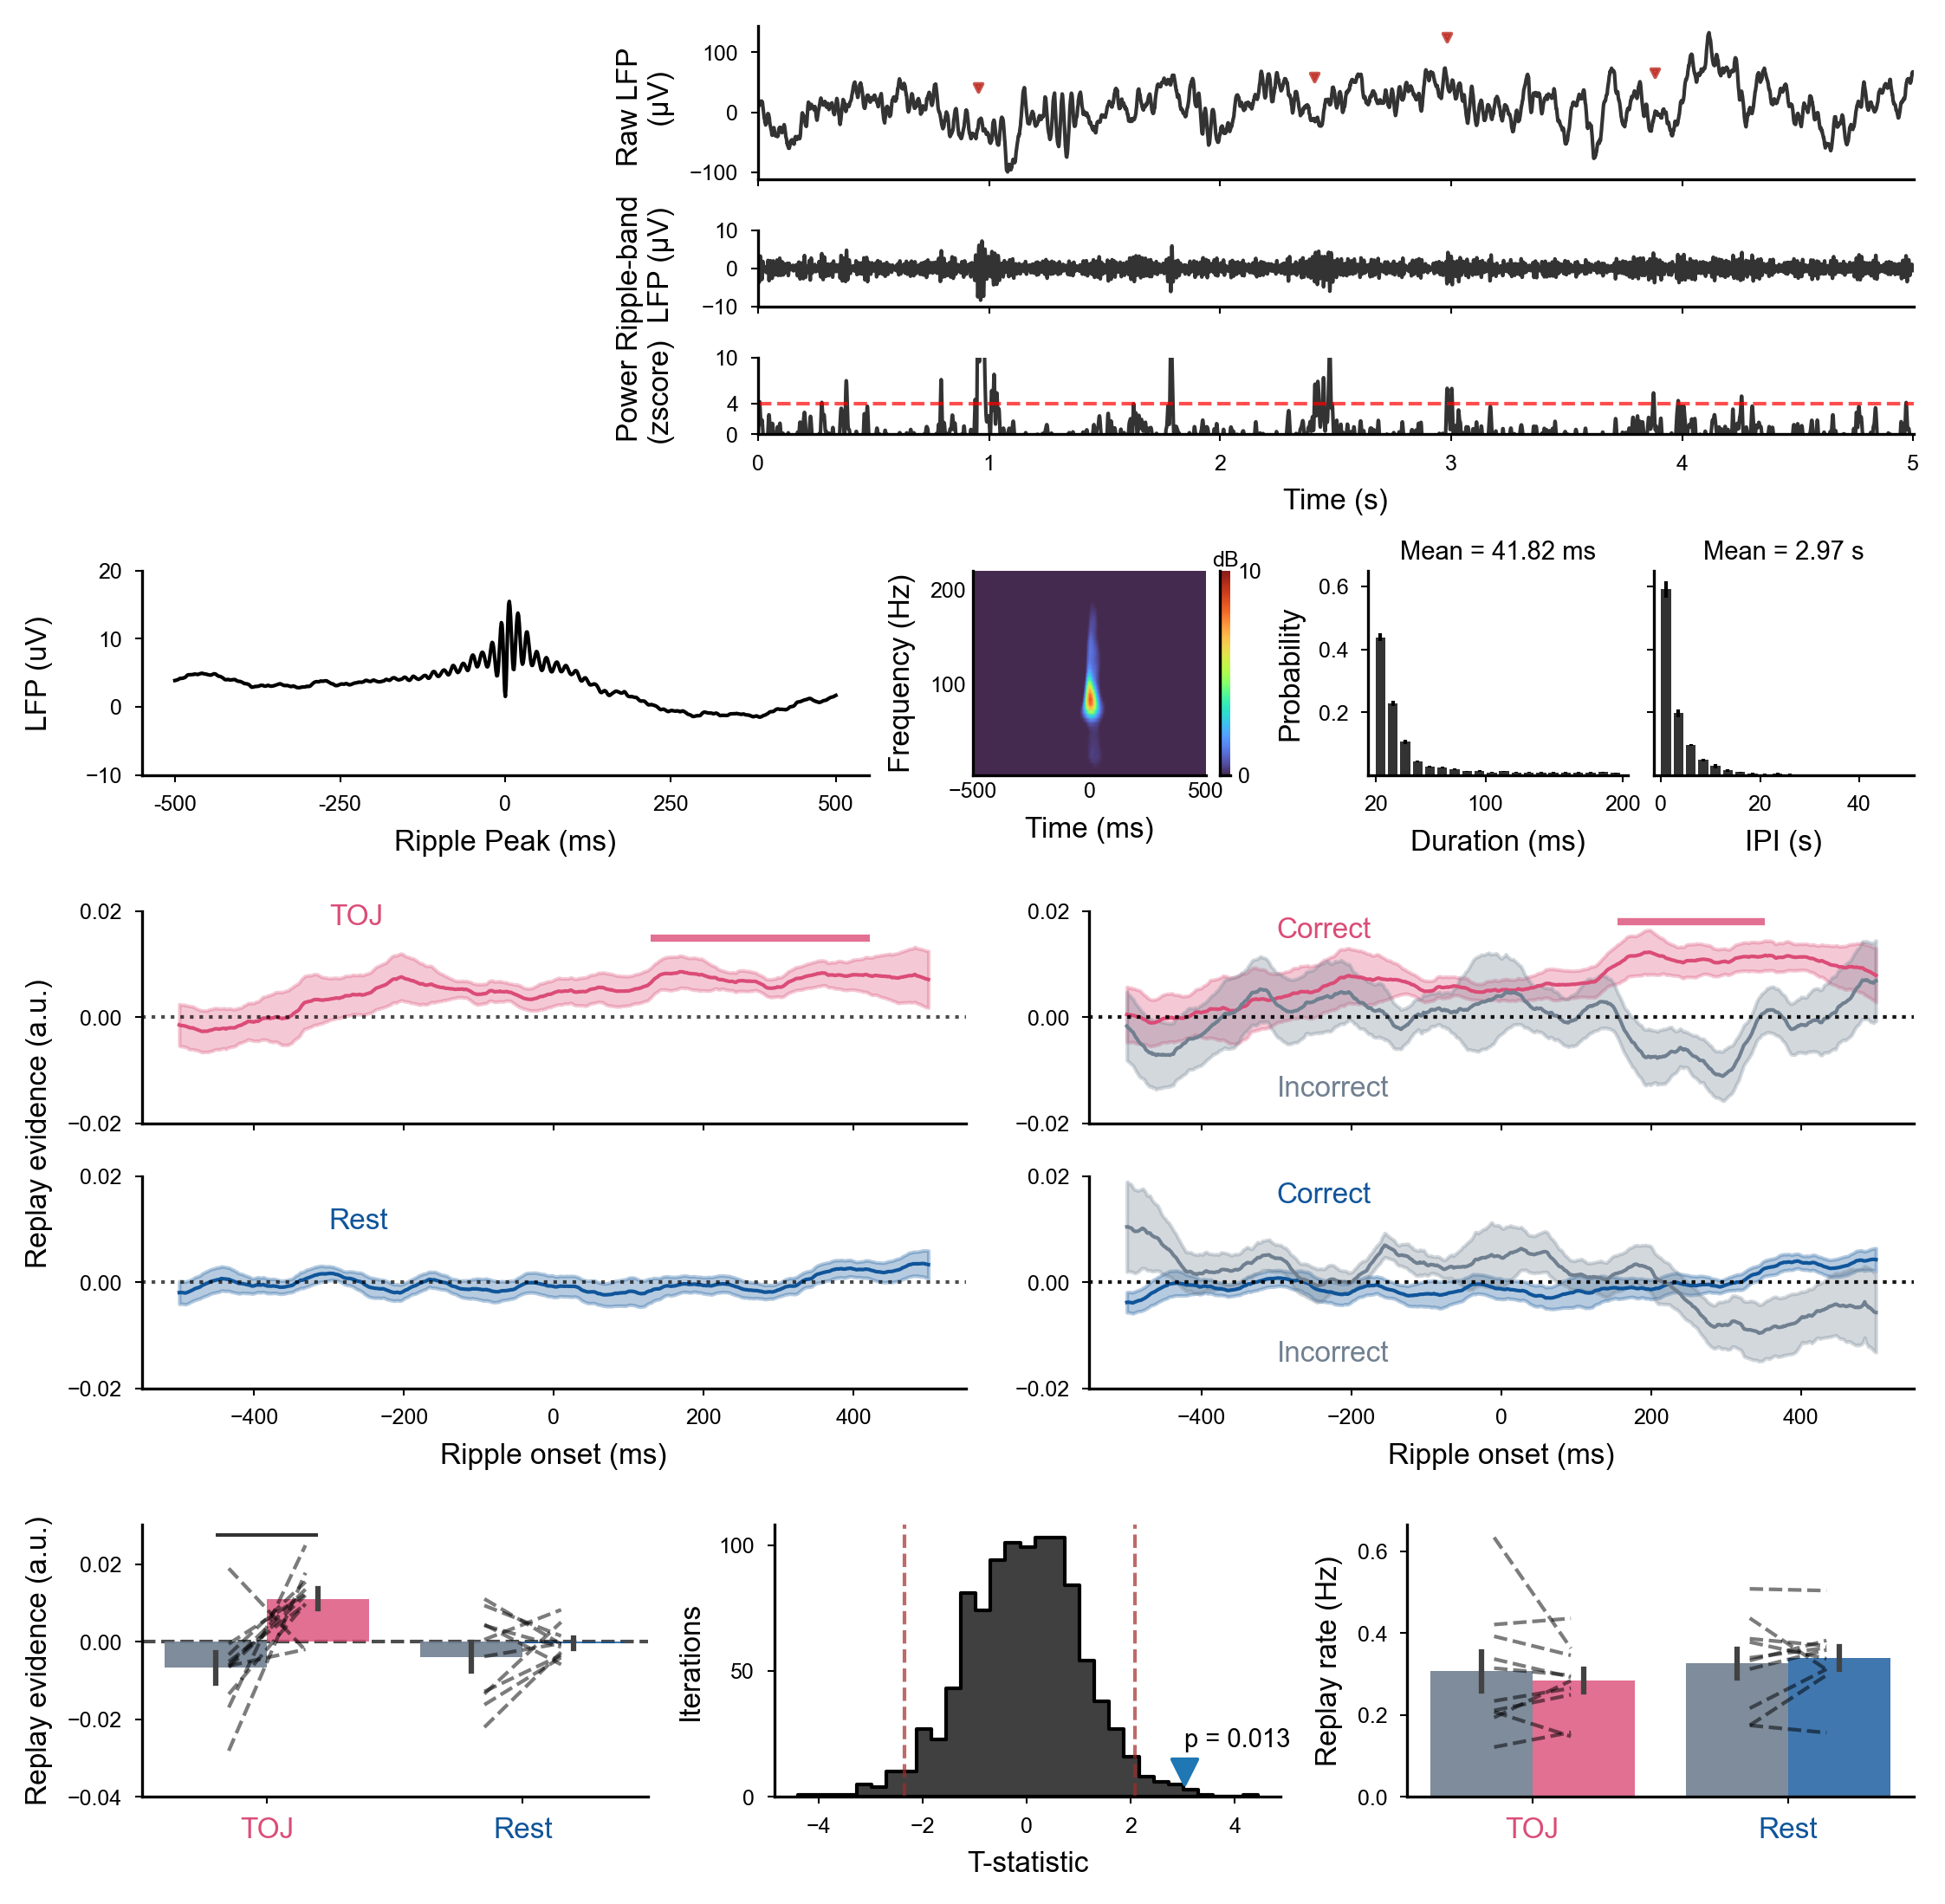

In [50]:
# Create figure and gridspec
fig = plt.figure(figsize=(7.1,7.1), dpi=300)
gs = fig.add_gridspec(4, 1,
                      height_ratios = [1.5,.75,1.75,1],
                    #   width_ratios = [1.5,1,1,1],
                      left=.02, right=.98, bottom=.02, top=.98,
                      wspace=.1, hspace=.4
                      )
# layout
gs_method = gs[0].subgridspec(1,2, wspace=.3, width_ratios=[1,3])
gs_lfp = gs_method[1].subgridspec(
    nrows=3, ncols=1, height_ratios=[2,1,1],
    hspace=.5
)

gs_describe = gs[1].subgridspec(1, 3, wspace=.2, width_ratios = [2,.8,1.5])
gs_hist = gs_describe[2].subgridspec(1,2, wspace=.1)

gs_perm = gs[2].subgridspec(2, 2, wspace=.15, width_ratios = [1,1],hspace=.25)

gs_bar = gs[3].subgridspec(1,3, wspace=.25)

# axes
ax_hippo = fig.add_subplot(gs_method[0])

axes = [fig.add_subplot(gs_lfp[i, 0]) for i in range(3)]

ax_lfp = fig.add_subplot(gs_describe[0])
ax_spec = fig.add_subplot(gs_describe[1])

axes_hist = [fig.add_subplot(gs_hist[0]), fig.add_subplot(gs_hist[1])]


# Plotting
# electrodes
ax_hippo.axis('off')


# LFP example
axes[0].plot(example_data['raw_lfp'], color='k', alpha=.8)

axes[1].plot(example_data['ripple_lfp'], color='k', alpha=.8)

axes[-1].plot(example_data['z_power'],  color='k', alpha=.8)
axes[-1].axhline(4, color='r', linestyle='--',alpha=.7, lw=1)

for peak in example_data['peaks']:
    axes[0].scatter(peak, example_data['raw_lfp'][peak] + 70, 
                    color='#bf2c23', s=5, zorder=3, alpha=.8,
                    marker='v')

axes[-1].tick_params(axis='x', which='major', labelbottom=True)
axes[-1].set_xticks(np.arange(0,5001,1000),[0,1,2,3,4,5])

axes[-2].set_ylim([-10,10])
axes[-1].set_ylim([0,10])
axes[-1].set_yticks([0,4,10])
axes[-1].set_xlim([0,5001])

axes[-1].set_xlabel('Time (s)')

for ax in axes[:-1]:    
    ax.sharex(axes[0])
    ax.tick_params(axis='x', which='major', labelbottom=False)

for ax, ylabel in zip(axes, ['Raw LFP \n (µV)', 'Ripple-band \n LFP (µV)', 'Power \n (zscore)']):
    ax.set_ylabel(ylabel)
    ax.margins(x=0)
    sns.despine(ax=ax)

fig.align_ylabels(axes)


_u = np.mean(group_lfp  * 1e6, axis=0)[500:-500] 
_err = stats.sem(group_lfp  * 1e6, axis=0)[500:-500] 

ax_lfp.plot(_u , color='k', lw=1, zorder=10)
ax_lfp.set_yticks([-10,0, 10,20])
ax_lfp.set_xticks([0,250,500,750,1000],[-500,-250,0,250,500])
ax_lfp.set_xlabel('Ripple Peak (ms)')
ax_lfp.set_ylabel('LFP (uV)')
sns.despine(ax=ax_lfp)

# Spectrogram
vmax = 10
ax_spec.imshow(np.mean(group_power, axis=0)[0][:,100:-100], cmap='turbo', aspect='auto', 
               extent=[-500, 500, 4, 220],
               origin='lower', 
               alpha=.9, vmin=0, 
               vmax=vmax)
cbar = plt.colorbar(ax_spec.images[0], ax=ax_spec, ticks=[0, vmax])
# cbar.ax.set_yticklabels(['0', str(vmax)])
cbar.ax.tick_params(axis='y', right=False, pad=0)
cbar.outline.set_linewidth(0)
cbar.ax.set_title('dB', fontsize=6, pad=0)
# cbar.ax.set_ylabel('Power (dB)', rotation=-90, labelpad=10)

ax_spec.set_xticks([-500, 0, 500])
# ax.set_yticks([50, 100, 150, 200])
ax_spec.tick_params(axis='both', bottom=False, left=False, pad=0)
ax_spec.set_xlabel('Time (ms)')
ax_spec.set_ylabel('Frequency (Hz)')
sns.despine(left=True, bottom=True, ax=ax_spec)


# histogram
for ax, (k, vals) in zip(axes_hist, group_dict.items()):
    if k == 'ipi':
        bins_arange = np.linspace(0, 50, 21)
        desired_ticks = [0, 20,40]
        tick_locations = [(x-0)/2.5-.4 for x in desired_ticks]
        
    else:
        bins_arange = np.linspace(25, 200, 21)
        desired_ticks = [20,100,200]
        tick_locations = [(x-20)/9-.4 for x in desired_ticks]
        
    bin_centers = (bins_arange[:-1] + bins_arange[1:]) / 2

    hist_list = list()
    for v in vals:
        if k == 'ipi':
            counts, _ = np.histogram(v / 1e3, bins=bins_arange)
        else:
            counts, _ = np.histogram(v, bins=bins_arange)
        hist_list.append(counts / counts.sum())

    mean_hist = np.mean(hist_list,axis=0)
    err_hist = stats.sem(hist_list, axis=0)
    
    sns.barplot(x=bin_centers, y=mean_hist, color='k', alpha=.8, ax=ax)
    ax.errorbar(np.arange(len(bin_centers)), mean_hist, yerr=err_hist,
                    capsize=0, ls = '',
                    lw=1,
                    color='k')
    ax.set_xticks(tick_locations, desired_ticks)
    sns.despine(ax=ax)
    
    ax.margins(x=0) 
    ax.set_xlim([-1,20])

axes_hist[0].set_ylabel('Probability')
axes_hist[1].set_ylabel('')
axes_hist[1].set_xlabel('IPI (s)')
axes_hist[0].set_xlabel('Duration (ms)')

axes_hist[0].set_title('Mean = 41.82 ms', fontsize=7, y = 0.95)
axes_hist[1].set_title('Mean = 2.97 s', fontsize=7, y = 0.95)

axes_hist[0].set_yticks([ 0.2, 0.4, 0.6])
axes_hist[1].sharey(axes_hist[0])
axes_hist[1].tick_params(axis='y',labelleft=False)
axes_hist[1].set_ylim([0,.65])

# Ripple-locked replay
axes_perm = [fig.add_subplot(gs_perm[i,0]) for i in range(2)]
for (event, event_vals), ax in zip(group_perm.items(), axes_perm):
    vals = np.array(event_vals)
    
    cluster = sig_cluster['all'].get(event, None)
    if cluster is not None:
        xmin, xmax = cluster[0][0], cluster[0][-1]
        ax.hlines(0.015, xmin-500, xmax-500, color=color_dict[event], alpha=0.8, lw=2)
        
    u = np.mean(vals, axis=0)
    err = stats.sem(vals, axis=0)
    ax.plot(np.arange(-500,500+1), u, label=event, color=color_dict[event])
    ax.fill_between(np.arange(-500,500+1), u-err, u+err, alpha=.3, color=color_dict[event])
    # axes_perm[0].axvline(x=0, color='k', linestyle='--', alpha=.8)
    ax.axhline(y=0, color='k', linestyle=':', alpha=.7)
    ax.set_ylim([-.02,.02])
    ax.set_yticks([-.02,0,.02])

    ax.text(-300, 0.0175 if event == 'TOJ' else 0.01, event, color=color_dict[event], fontsize=8)
    
    if event == 'TOJ':
        ax.tick_params(axis='x',bottom=True, labelbottom=False)
    else:
        ax.set_xlabel('Ripple onset (ms)')
    
    sns.despine(ax=ax)
    
axes_perm[0].set_ylabel('Replay evidence (a.u.)', y=0)
   
axes_perm = [fig.add_subplot(gs_perm[i,1]) for i in range(2)]
for ax, event in zip(axes_perm, ['TOJ', 'Rest']):
    vals = np.array(correct_perm[event])[:,:2]
    
    correct_u, incorr_u = vals.mean(axis=0)
    correct_err, incorr_err = stats.sem(vals, axis=0)
    
    for u, err, c in zip([correct_u, incorr_u], [correct_err, incorr_err], [color_dict[event], 'slategray']):
        ax.plot(np.arange(-500,500+1), u, label=event, color=c)
        ax.fill_between(np.arange(-500,500+1), u-err, u+err, alpha=.3, color=c)
        ax.axhline(y=0, color='k', linestyle=':', alpha=.7)

    cluster = sig_cluster['correct'].get(event)
    if cluster is not None:
        xmin, xmax = cluster[0][0], cluster[0][-1]
        ax.hlines(0.018, xmin-500, xmax-500, lw=2, color=color_dict[event], alpha=.8)
    ax.set_ylim([-.02,.02])
    ax.set_yticks([-.02,0,.02])
    
    
    ax.text(-300, -0.015, 'Incorrect', color='slategray', fontsize=8)
    ax.text(-300, 0.015, 'Correct', color=color_dict[event], fontsize=8)
    
    if event == 'TOJ':
        ax.tick_params(axis='x',bottom=True, labelbottom=False)
    else:
        ax.set_xlabel('Ripple onset (ms)')
        
    sns.despine(ax=ax)

ax_bar_replay = fig.add_subplot(gs_bar[0])

# Barplot: ripple-replay
sns.barplot(data=group_values, x='Event',y='Replay evidence',hue='Correct',
              dodge=.5,
            #   palette=color_dict,
              errorbar='se', units='Site',
              legend=False,
            ls='none',
            ax=ax_bar_replay
            )
event_df = group_values[group_values.Event=='TOJ'].reset_index(drop=True)
for correct in [0,1]:
    vals = event_df.pivot_table(index='Site', columns='Correct',values='Replay evidence').values
    for (a, b) in vals:
        ax_bar_replay.plot([-.15,.15],[a,b], color='k', zorder=2, alpha=.3, ls='dashed')

ax_bar_replay.hlines(0.0275, -.2,.2, color='k', alpha=.8)

event_df = group_values[group_values.Event=='Rest'].reset_index(drop=True)
for correct in [0,1]:
    vals = event_df.pivot_table(index='Site', columns='Correct',values='Replay evidence').values
    for (a, b) in vals:
        ax_bar_replay.plot([1-.15,1+.15],[a,b], color='k', zorder=2, alpha=.3, ls='dashed')
        

# Hist: Bootstrapping
ax_bar_replay.set_ylabel('Replay evidence (a.u.)')
ax_bar_replay.set_xlabel('')

ax_bar_replay.set_yticks([-0.04,-0.02,0,0.02])
ax_bar_replay.set_xticks([0,1])
ax_bar_replay.set_xticklabels(['TOJ','Rest'], color=color_dict['TOJ'], fontsize=8)
ax_bar_replay.get_xticklabels()[1].set_color(color=color_dict['Rest'])

ax_bar_replay.axhline(0, ls='dashed', color='k', alpha=.7, zorder=0)

ax_bar_bootstrap = fig.add_subplot(gs_bar[1])
sns.histplot(bootstrap_null, color='k',element ='step', ax=ax_bar_bootstrap)
ax_bar_bootstrap.axvline(np.percentile(bootstrap_null, 2.5), color='brown', ls='dashed', alpha=.7)
ax_bar_bootstrap.axvline(np.percentile(bootstrap_null, 97.5), color='brown', ls='dashed', alpha=.7)

ax_bar_bootstrap.scatter(tobs, 10, marker='v', s=49)
ax_bar_bootstrap.text(tobs, 20, 'p = 0.013', ha='left', fontsize=7)
ax_bar_bootstrap.set_yticks([0,50,100])
ax_bar_bootstrap.set_ylabel('Iterations')
ax_bar_bootstrap.set_xlabel('T-statistic')

ax_bar_ripple = fig.add_subplot(gs_bar[-1])
sns.barplot(data=df_ripple, x='Event',y='RippleRate',hue='Correct',
            order=['TOJ','Rest'],
              dodge=.5,
            #   palette=color_dict,
              errorbar='se', units='Site',
              legend=False,
            ls='none',
            ax=ax_bar_ripple
            )
event_df = df_ripple[df_ripple.Event=='TOJ'].reset_index(drop=True)
for correct in [0,1]:
    vals = event_df.pivot_table(index='Site', columns='Correct',values='RippleRate').values
    for (a, b) in vals:
        ax_bar_ripple.plot([-.15,.15],[a,b], color='k', zorder=2, alpha=.3, ls='dashed')


event_df = df_ripple[df_ripple.Event=='Rest'].reset_index(drop=True)
for correct in [0,1]:
    vals = event_df.pivot_table(index='Site', columns='Correct',values='RippleRate').values
    for (a, b) in vals:
        ax_bar_ripple.plot([1-.15,1+.15],[a,b], color='k', zorder=2, alpha=.3, ls='dashed')

ax_bar_ripple.set_ylabel('Replay rate (Hz)')
ax_bar_ripple.set_xlabel('')

ax_bar_ripple.set_xticks([0,1])
ax_bar_ripple.set_xticklabels(['TOJ','Rest'], color=color_dict['TOJ'], fontsize=8)
ax_bar_ripple.get_xticklabels()[1].set_color(color=color_dict['Rest'])

for ax in [ax_bar_replay, ax_bar_ripple]:
    patch = ax.patches[0]
    patch.set_facecolor('slategray')
    patch.set_edgecolor('none')
    patch.set_alpha(0.9)

    patch = ax.patches[1]
    patch.set_facecolor('slategray')
    patch.set_edgecolor('none')
    patch.set_alpha(0.9)

    patch = ax.patches[2]
    patch.set_facecolor(color_dict['TOJ'])
    patch.set_alpha(0.8)

    patch = ax.patches[3]
    patch.set_facecolor(color_dict['Rest'])
    patch.set_alpha(0.8)


fig.align_ylabels([ax_bar_replay, axes_perm[0], ax_lfp])


sns.despine()
fig.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.98)

# fig.savefig(r"M4/FigM4_new.svg", format="svg", dpi=300, bbox_inches="tight", transparent=True)

# S1

In [ ]:
_path = r'S1'

## Read data

In [68]:
beh_df = pd.read_csv(os.path.join(_path,r'Behavioral_records.csv'))

beh_df['Session_cut'] = beh_df.Session.apply(lambda x: 5 if x >=5 else x)
beh_df['Correct'] = beh_df['TOJ_res'].apply(lambda x: 0 if x == -1 else x)
beh_df['RT'] = beh_df['TOJ_RT'] / 1e3

beh_df = beh_df[(beh_df.TOJ_res >= 0)].reset_index(drop=True, inplace=False)

df_loss = pd.read_csv(os.path.join(_path,r'TrainingLoss_session.csv'))
tdlm_df = pd.read_csv(os.path.join(_path,r'TDLM_session.csv'))

ripple_df = pd.read_csv(os.path.join(_path,r'Ripple_session.csv'))

df_stats = ripple_df.groupby(['Site', 'Session_cut','Correct']).agg({'duration':'sum', 'ripple_count':'sum'}).reset_index()
df_stats['rate'] = df_stats.ripple_count / df_stats.duration
df_stats['TOJ_res'] = df_stats.Correct.apply(lambda x: 'Correct' if x == 1 else 'Incorrect')

## Plot

<Figure size 640x480 with 0 Axes>

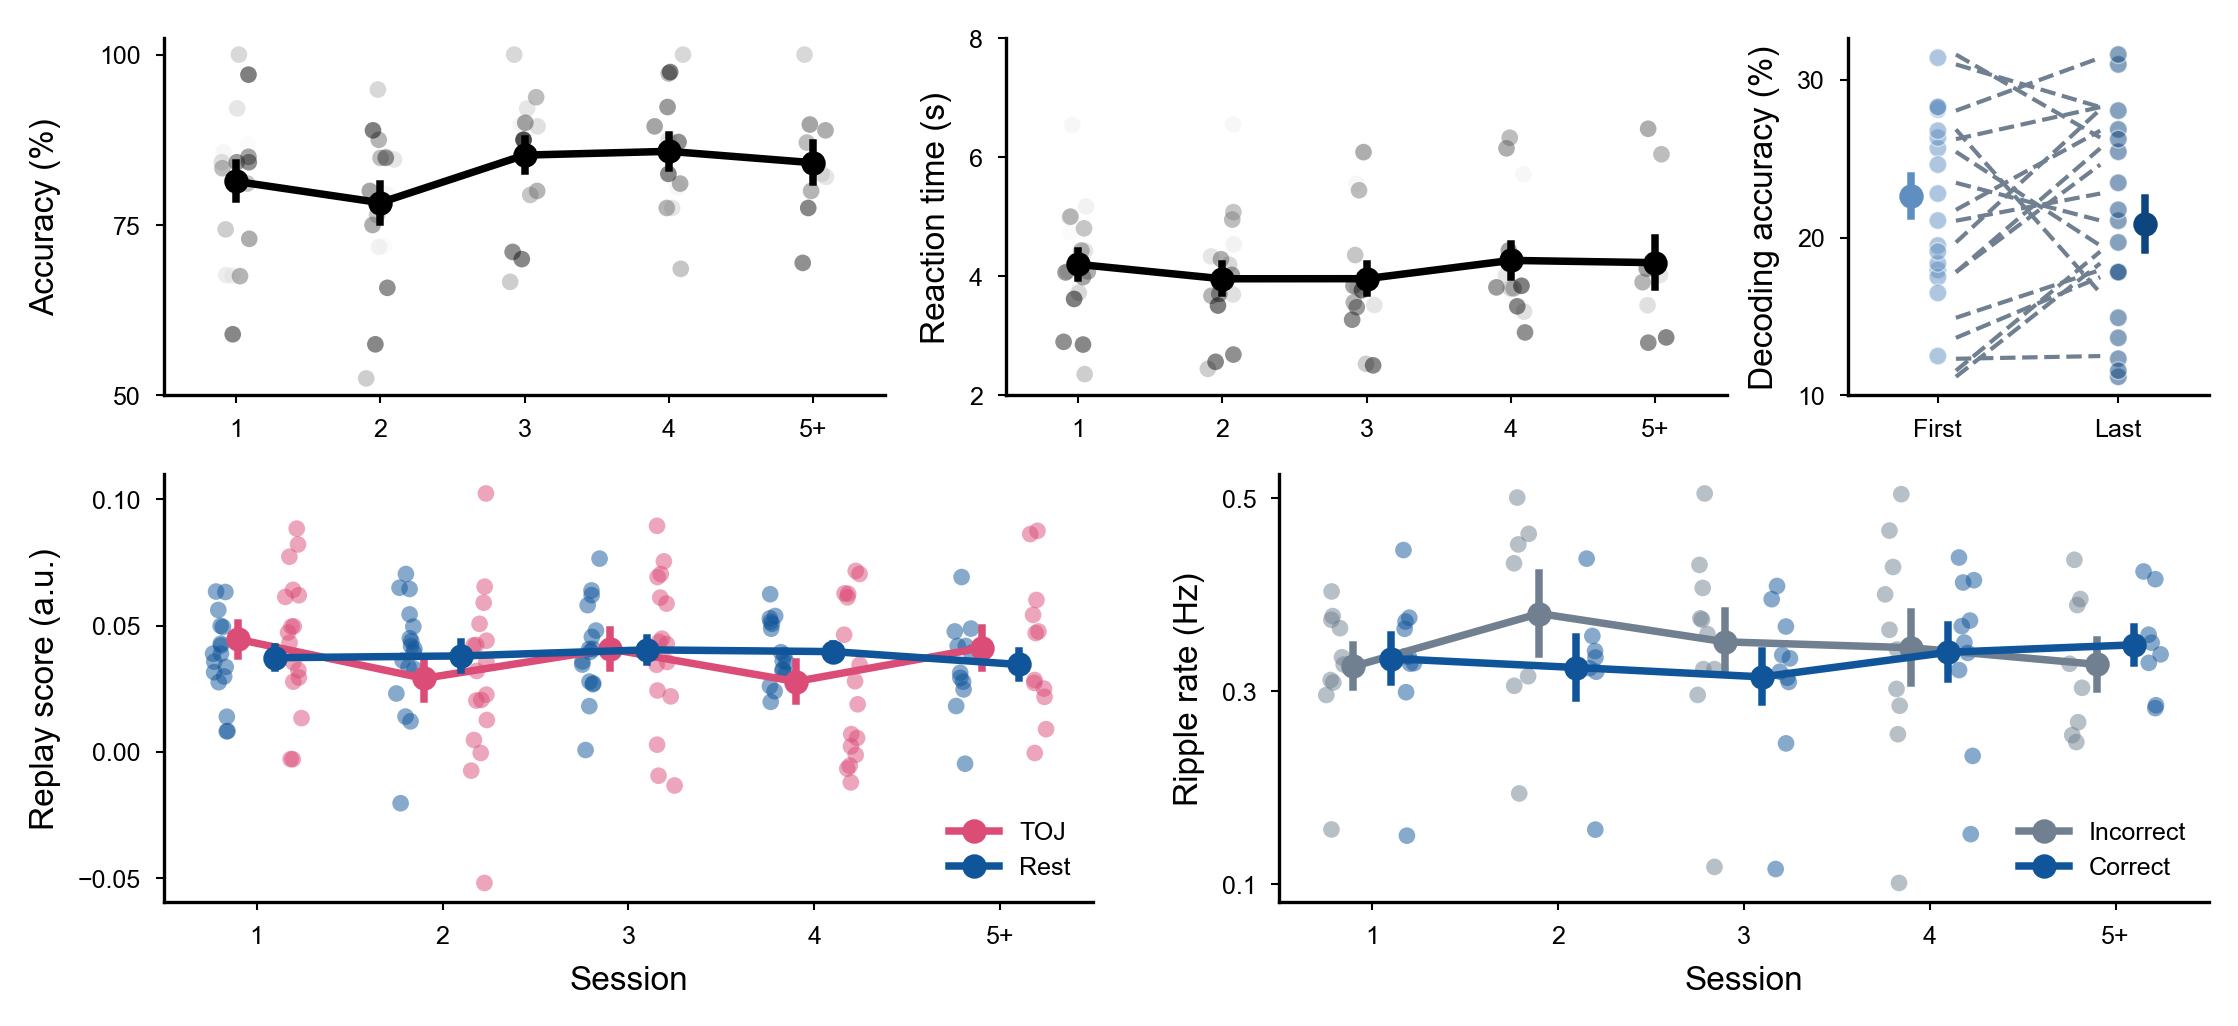

In [72]:
plt.clf()
strip_kws = dict(size=4, alpha=0.5, legend=False, zorder=0,)

fig = plt.figure(figsize=(7.1,3), dpi=300)

gs_main = fig.add_gridspec(
    nrows=2, ncols=1,
    height_ratios=[1,1.2],  # row1比row2略矮，可按需要调整
    top=0.98, bottom=0.02,
    left=0.02, right=0.98,
    hspace=0.2,
)

gs_beh = gs_main[0].subgridspec(
    nrows=1, ncols=3,
    width_ratios=[1, 1,.5],
    wspace=0.2
)


gs_neu = gs_main[1].subgridspec(
    nrows=1, ncols=2,width_ratios=[1,1],
    wspace=0.2
)

axes = [fig.add_subplot(gs_beh[_]) for _ in range(3)]


for ax, meas in zip(axes, ['Correct', 'RT']):
    df_scatter = beh_df.groupby(['SubjectID','Session_cut'])[meas].mean().reset_index()
    
    sns.pointplot(data=df_scatter, x='Session_cut', y=meas, 
                errorbar='se', units='SubjectID', 
                color='k', 
                ax=ax)

    
    sns.stripplot(data=df_scatter, x='Session_cut', y=meas, hue='SubjectID',
                palette='Greys',
                **strip_kws,
                dodge=False, 
                ax=ax,
                )
    
    ax.set_xlabel('')
    sns.despine(ax=ax)

ax_acc, ax_rt, ax_loss = axes
ax_acc.set_yticks([.5, .75, 1],[50,75,100])
ax_acc.set_ylabel('Accuracy (%)')

ax_rt.set_yticks([2,4,6,8])
ax_rt.set_ylabel('Reaction time (s)')



sns.scatterplot(
    data=df_loss, x='Session', y='Acc', hue='Session', 
    palette={'First':"#5f8fc0", 'Last':'#0d457e'},
    # order=['First', 'Last'],
    # legend=False, alpha=.5, zorder=0, size=4,
    **strip_kws,
    ax=ax_loss
)

# Pointplot with custom positions
sns.pointplot(
    data=df_loss, x='Session', y='Acc', hue='Session', 
    palette={'First':"#5f8fc0", 'Last':'#0d457e'},
    order=['First', 'Last'],
    errorbar='se', units='Subject', 
    dodge=.3,  # Shift points left/right
    ax=ax_loss
)

# Swarmplot with custom positions


# Connect dots with lines at custom x positions
for idx, grp in df_loss.groupby('Subject'):
    last_val = grp[grp.Session == 'Last'].Acc.values[0] 
    first_val = grp[grp.Session == 'First'].Acc.values[0]
    # Adjust line x positions to match the dodged points
    ax_loss.plot([.1, .9], [last_val, first_val], 
                 ls='--', color='slategray')

sns.despine(ax=ax_loss)
ax_loss.set_xticks([0, 1], ['First','Last'])
ax_loss.set_xlim([-.5,1.5])


ax_loss.set_yticks([.1, .2, .3],[10,20,30])
ax_loss.set_ylabel('Decoding accuracy (%)')
ax_loss.set_xlabel('')

ax_seq, ax_ripple = [fig.add_subplot(gs_neu[_]) for _ in range(2)]


sns.pointplot(data=tdlm_df, x='Session_cut', y='Seq', 
            errorbar='se', units='Subject',  
            hue='Event', palette=color_dict, hue_order=['TOJ','Rest'],
            dodge=.2,
            ax=ax_seq
            )


sns.stripplot(data=tdlm_df, x='Session_cut', y='Seq', 
            hue='Event', palette=color_dict,
            dodge=.8, 
            **strip_kws,
            ax=ax_seq
            )
ax_seq.legend(loc='lower right', frameon=False)

ax_seq.set_yticks([-0.05,0,0.05,0.10])

ax_seq.set_ylabel('Replay score (a.u.)')
ax_seq.set_xlabel('Session')
sns.despine(ax=ax_seq)


sns.pointplot(data=df_stats, x='Session_cut', y='rate',hue='TOJ_res', palette={'Incorrect':'slategray', 'Correct':'#10559a'},
              dodge=.2, errorbar='se', units='Site', hue_order=['Incorrect','Correct'],
              legend=True,
              ax=ax_ripple
              )

sns.stripplot(data=df_stats, x='Session_cut', y='rate', hue='TOJ_res', palette={'Incorrect':'slategray', 'Correct':'#10559a'},
              dodge=.8, 
              **strip_kws,
              ax=ax_ripple
              )

ax_ripple.set_yticks([.1,.3,.5])
ax_ripple.set_ylabel('Ripple rate (Hz)')
ax_ripple.legend(loc='lower right', frameon=False)
ax_ripple.set_xlabel('Session')

sns.despine(ax=ax_ripple)

for ax in [ax_acc, ax_rt, ax_seq, ax_ripple]:
    ax.set_xticks(np.arange(5), ['1','2','3','4','5+'])

fig.align_ylabels([ax_acc, ax_seq])
fig.align_xlabels([ax_seq, ax_ripple])

# S2

In [82]:
import colormaps as cmaps
state_cmaps = plt.get_cmap(cmaps.haline.discrete(9).reversed())
freq_labels = [r'$\delta$', r'$\theta$', r'$\alpha$', r'$\beta$', r'$\gamma$', 'High-' + r'$\gamma$']

sig_state_cmpas = dict(zip(np.arange(1,9), [state_cmaps(i) for i in range(8)]))
for i in range(1,9):
    sig_state_cmpas['NS'+str(i)] = 'silver'

## Read data

In [ ]:
_path = r'S2'

In [76]:
freq_df = pd.read_csv(os.path.join(_path,r'Group_frequency_ablation_ratio.csv'))
max_pairs_df = freq_df.loc[freq_df.groupby(['Subject', 'Freqs','FreqBand'])['Weight'].idxmax()][['Subject', 'Freqs', 'FreqBand', 'State']]
count_matrix = max_pairs_df.groupby(['Freqs','FreqBand', 'State'])['Subject'].nunique().unstack(fill_value=0)
count_matrix = count_matrix.groupby(level='FreqBand').mean().reindex(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma'])

nrom_mat = count_matrix.values / count_matrix.values.sum(axis=1, keepdims=True)
nrom_mat = nrom_mat.T

pval_list = list()
compares = list()
for idx, grp in freq_df.groupby(['State','FreqBand']):

    pval = stats.ttest_1samp(grp.ratio, 0, alternative='greater').pvalue
    pval_list.append(pval)
    compares.append(idx)

H0, p_correct = pg.multicomp(pval_list, 0.05, method='fdr_bh')
freq_df['Sig'] = freq_df.apply(lambda row: 'NS'+str(row.State) if (( row.State, row.FreqBand) == np.array(compares)[~H0]).all(axis=1).any() else row.State, axis=1)

In [77]:
anat_df = pd.read_csv(os.path.join(_path,r'Group_anatomical_ablation_ratio.csv'))
anat_df['ratio'] = anat_df['Weight'] * 100

pval_list = list()
compares = list()
for idx, grp in anat_df.groupby(['State','Lobe_5']):

    pval = stats.ttest_1samp(grp.ratio, 0, alternative='greater').pvalue
    pval_list.append(pval)
    compares.append(idx)

H0, p_correct = pg.multicomp(pval_list, 0.05, method='fdr_bh')
anat_df['Sig'] = anat_df.apply(lambda row: 'NS'+str(row.State) if (( row.State, row.Lobe_5) == np.array(compares)[~H0]).all(axis=1).any() else row.State, axis=1)

In [78]:
from ast import literal_eval
df_specific = pd.read_csv(os.path.join(_path,r'Group_anatomical_ablation_state_specificity.csv'))
df_specific['Max_weight_state'] = df_specific.Max_weight_state.combine(df_specific.Specific_meas, lambda x, y: 0 if y < 3 else x)
df_specific['MNI_arr'] = df_specific['MNI'].apply(literal_eval)
contact_coords = np.array(df_specific['MNI_arr'].values.tolist())
df_specific[['MNI_x', 'MNI_y', 'MNI_z']] = pd.DataFrame(contact_coords, index=df_specific.index)

## Plot

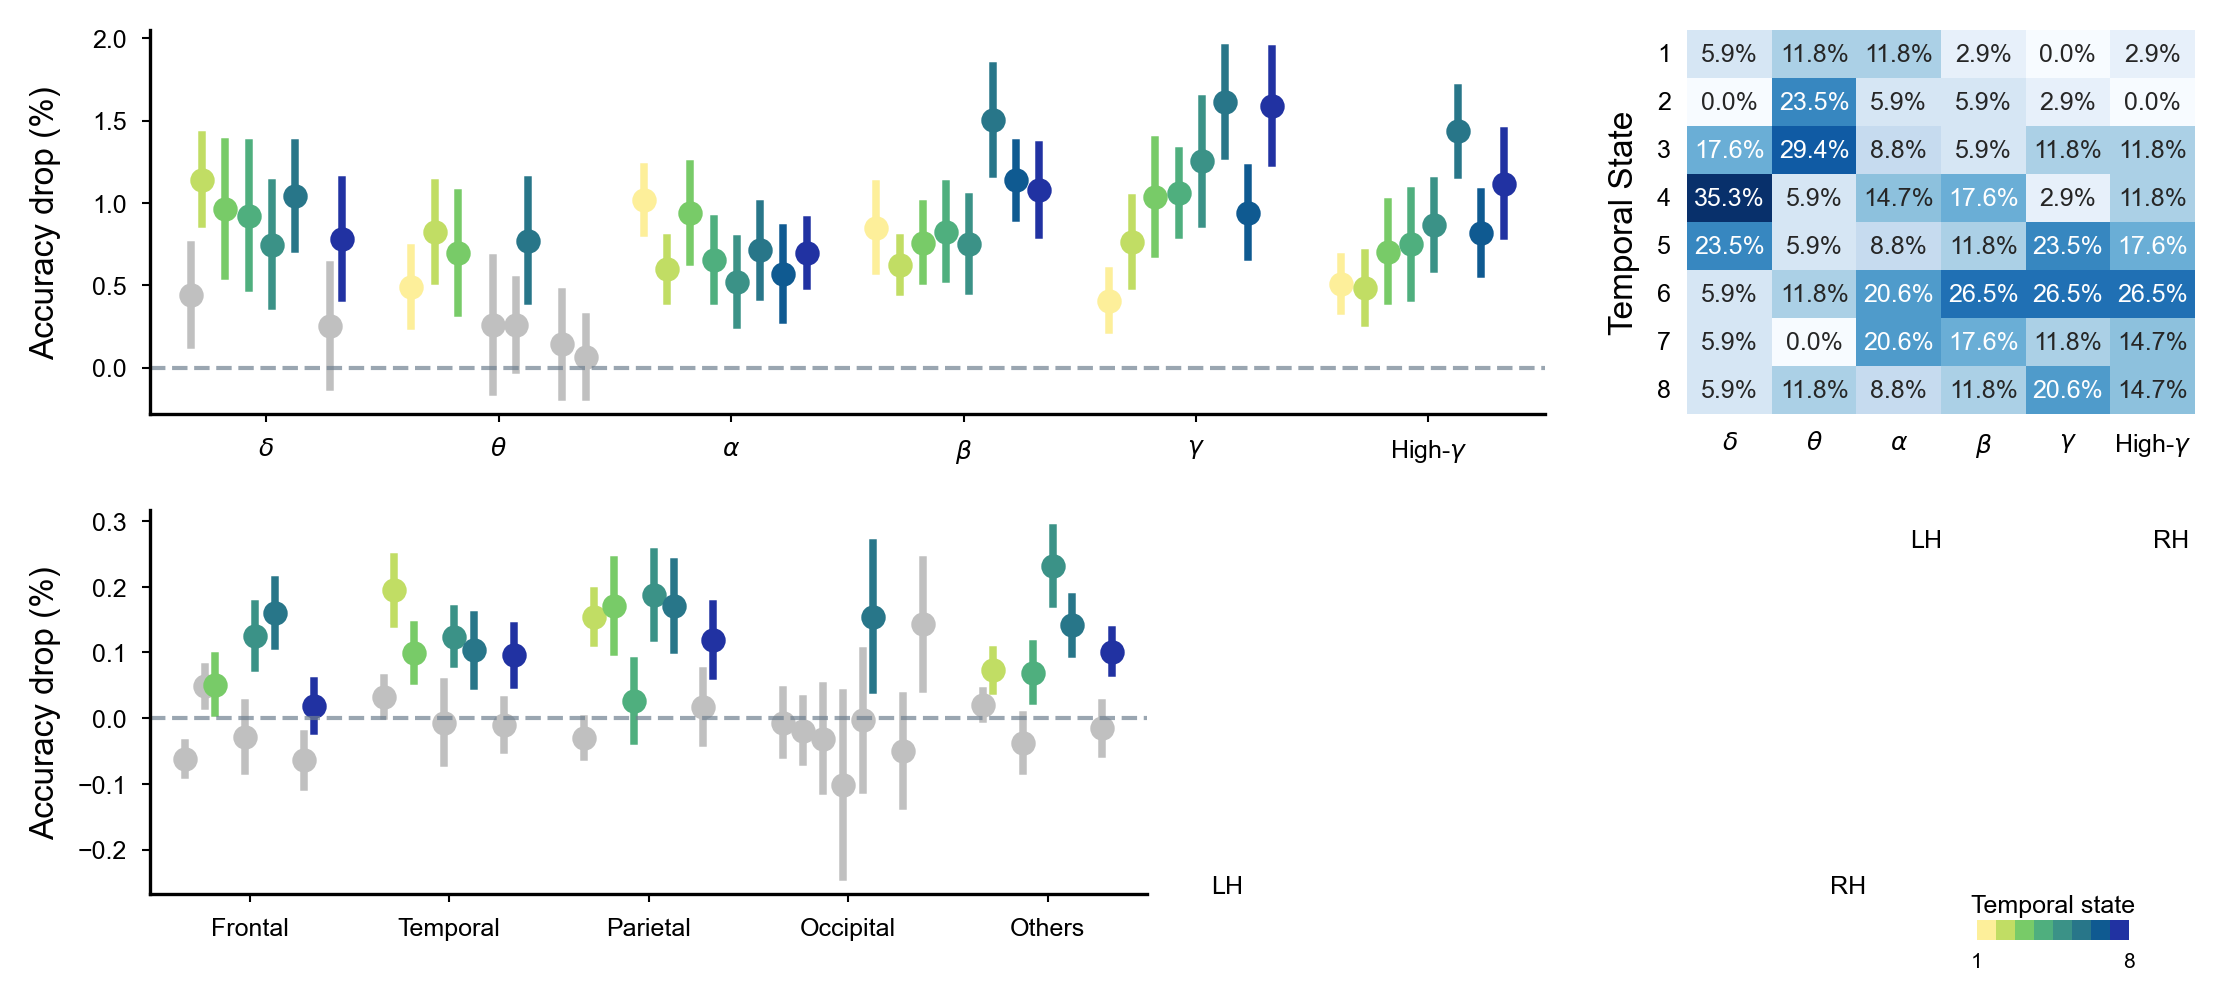

In [83]:
fig = plt.figure(figsize=(7.1,3), dpi=300)


gs = fig.add_gridspec(2,1,
                      hspace=.25, wspace=.1,
                        # height_ratios=[1.2,.8,1],
                      left=0.02, right=0.98, bottom=0.02, top=0.98)

gs_freq = gs[0].subgridspec(1, 2, wspace=.15, width_ratios=[2.75,1])

ax_point = fig.add_subplot(gs_freq[0])
ax_prop = fig.add_subplot(gs_freq[1])

# State X Freq profile

sns.pointplot(data=freq_df, x='FreqBand', y='ratio', 
              hue='Sig', 
              hue_order=[1,'NS1',2,'NS2', 3,'NS3',4,'NS4',5,'NS5',6,'NS6',7,'NS7',8,'NS8'],
              # hue = 'State',
              # palette='Grays',
              palette=sig_state_cmpas,
              errorbar='se', units='Subject', legend=False, 
              ls='', dodge=.75, 
              ax=ax_point)


ax_point.axhline(0, ls='dashed', color='slategray', alpha=.7)

ax_point.set_xticks(np.arange(6), freq_labels)

ax_point.set_xlabel('')
ax_point.set_ylabel('Accuracy drop (%)')

sns.despine(ax=ax_point)

# Proportion heatmap
import matplotlib as mpl
from matplotlib.colors import Normalize
from xarray import align

sm_hm = mpl.cm.ScalarMappable(cmap='Blues', norm=Normalize(vmin=nrom_mat.min()*100,
                                                               vmax=nrom_mat.max()*100))
sm_hm.set_array([])


sns.heatmap(nrom_mat, annot=True, cmap='Blues', ax=ax_prop,
             annot_kws=dict(fontsize=6),  square=False, fmt=".1%",
             cbar=False)

ax_prop.set_xticks(np.arange(6)+.5, freq_labels)
ax_prop.set_yticks(np.arange(8)+.5, np.arange(1,9), rotation=0)
ax_prop.tick_params(axis='both', which='both', left=False, bottom=False, pad=2)

ax_prop.set_ylabel('Temporal State')


# Anatomical profile
gs_anat = gs[1].subgridspec(1, 2, wspace=.05, width_ratios=[1,1])

gs_brain = gs_anat[1].subgridspec(1, 2, wspace=.05, width_ratios=[2,.85])

ax_lobe = fig.add_subplot(gs_anat[0])

sns.pointplot(data=anat_df[anat_df.tissues_segment=='Gray'], 
              y='ratio', x='Lobe_5', order=['Frontal','Temporal','Parietal','Occipital','Others'],
              # hue='State', palette=[state_cmaps(i) for i in range(8)],
              hue='Sig', 
              hue_order=[1,'NS1',2,'NS2', 3,'NS3',4,'NS4',5,'NS5',6,'NS6',7,'NS7',8,'NS8'],
              palette=sig_state_cmpas,
              ls='none', dodge=.75,
              errorbar='se', 
              legend=False,
              ax = ax_lobe
              )
ax_lobe.axhline(0, ls='dashed', color='slategray', alpha=.7)

ax_lobe.set_xlabel('')
ax_lobe.set_ylabel('Accuracy drop (%)')
sns.despine(ax=ax_lobe)



# Brain images
ax_Lat = fig.add_subplot(gs_brain[0])
# img = plt.imread(img_path('Flat_lat'))
# ax_Lat.imshow(img)
ax_Lat.axis('off')
ax_Lat.text(0.02, 0.05, 'LH', transform=ax_Lat.transAxes, 
           ha='left', va='top', fontsize=6,  color='black')
ax_Lat.text(0.98, 0.05, 'RH', transform=ax_Lat.transAxes, 
           ha='right', va='top', fontsize=6,  color='black')


ax_ven = fig.add_subplot(gs_brain[1])
# img = plt.imread(img_path('Both_dor'))
# ax_ven.imshow(img)
ax_ven.axis('off')
ax_ven.text(0.02, 0.95, 'LH', transform=ax_ven.transAxes, 
             ha='left', va='top', fontsize=6, color='black')
ax_ven.text(0.98, 0.95, 'RH', transform=ax_ven.transAxes, 
             ha='right', va='top', fontsize=6, color='black')

# Colorbar
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colorbar import Colorbar

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax_state = inset_axes(ax_ven, width="50%", height="5%", 
                       bbox_to_anchor=(0.42, -1.4, 0.6, 1),     # (x0, y0, width, height)
                       bbox_transform=ax_prop.transAxes,        # interpret in ax_prop coordinates
                       loc='lower center',                
                       )

state_cmap = ListedColormap([state_cmaps(i) for i in range(8)])
norm = plt.Normalize(vmin=1, vmax=8)
sm = ScalarMappable(cmap=state_cmap, norm=norm)
sm.set_array([])

# place colorbar at bottom or side depending on layout
# cax_state = fig.add_axes([0.87, ax_Both.get_position().y0-.05, 0.075, 0.02])  # adjust position
cb_state = fig.colorbar(sm, cax=cax_state,
                        orientation='horizontal', 
                        ticks=[1,8]
                        )
# cb_state.set_label('Temporal state', fontsize=6)
cb_state.ax.set_title('Temporal state', fontsize=6, pad=2)
cb_state.outline.set_visible(False)
cb_state.ax.tick_params(bottom=False, labelsize=5, pad=1)
fig.align_ylabels([ax_lobe, ax_point])


# S3

In [4]:
import matplotlib.cm as cm
nstates = 8

colors_pos = [cm.Blues(0.3 + 0.6 * i/(nstates-1)) for i in range(nstates)] # Blues
colors_neg= [cm.Greys(0.3 + 0.6 *i/(nstates-1)) for i in range(nstates)] # Greys

neg_color = colors_neg[len(colors_neg)//2]
pos_color = colors_pos[len(colors_pos)//2]

## Read data

In [ ]:
_path = r'S3'

In [6]:
duration_df = pd.read_csv(os.path.join(_path,r'Decoding_5fold_Movie_length.csv'))
shape_df = pd.read_csv(os.path.join(_path,r'Decoding_5fold_feature_sample.csv'))
plot_across = pd.read_csv(os.path.join(_path,r'pattern_similarity_across_boundary.csv'))

pattern_similarity_data = np.load(os.path.join(_path, 'pattern_similarity_boundary_poisition.npz'), allow_pickle=True)
within_cm = pattern_similarity_data['Within'].item()
across_cm = pattern_similarity_data['Across'].item()

In [7]:
across_df = pd.read_csv(os.path.join(_path, r"pattern_similarity_across_boundary.csv"))
plot_across = pd.melt(across_df, id_vars=['Subject','Ref','LagTrial'], value_vars=['Boundary_Sim','Position_Sim'], var_name='Type', value_name='Similarity')

## Plot

<Figure size 640x480 with 0 Axes>

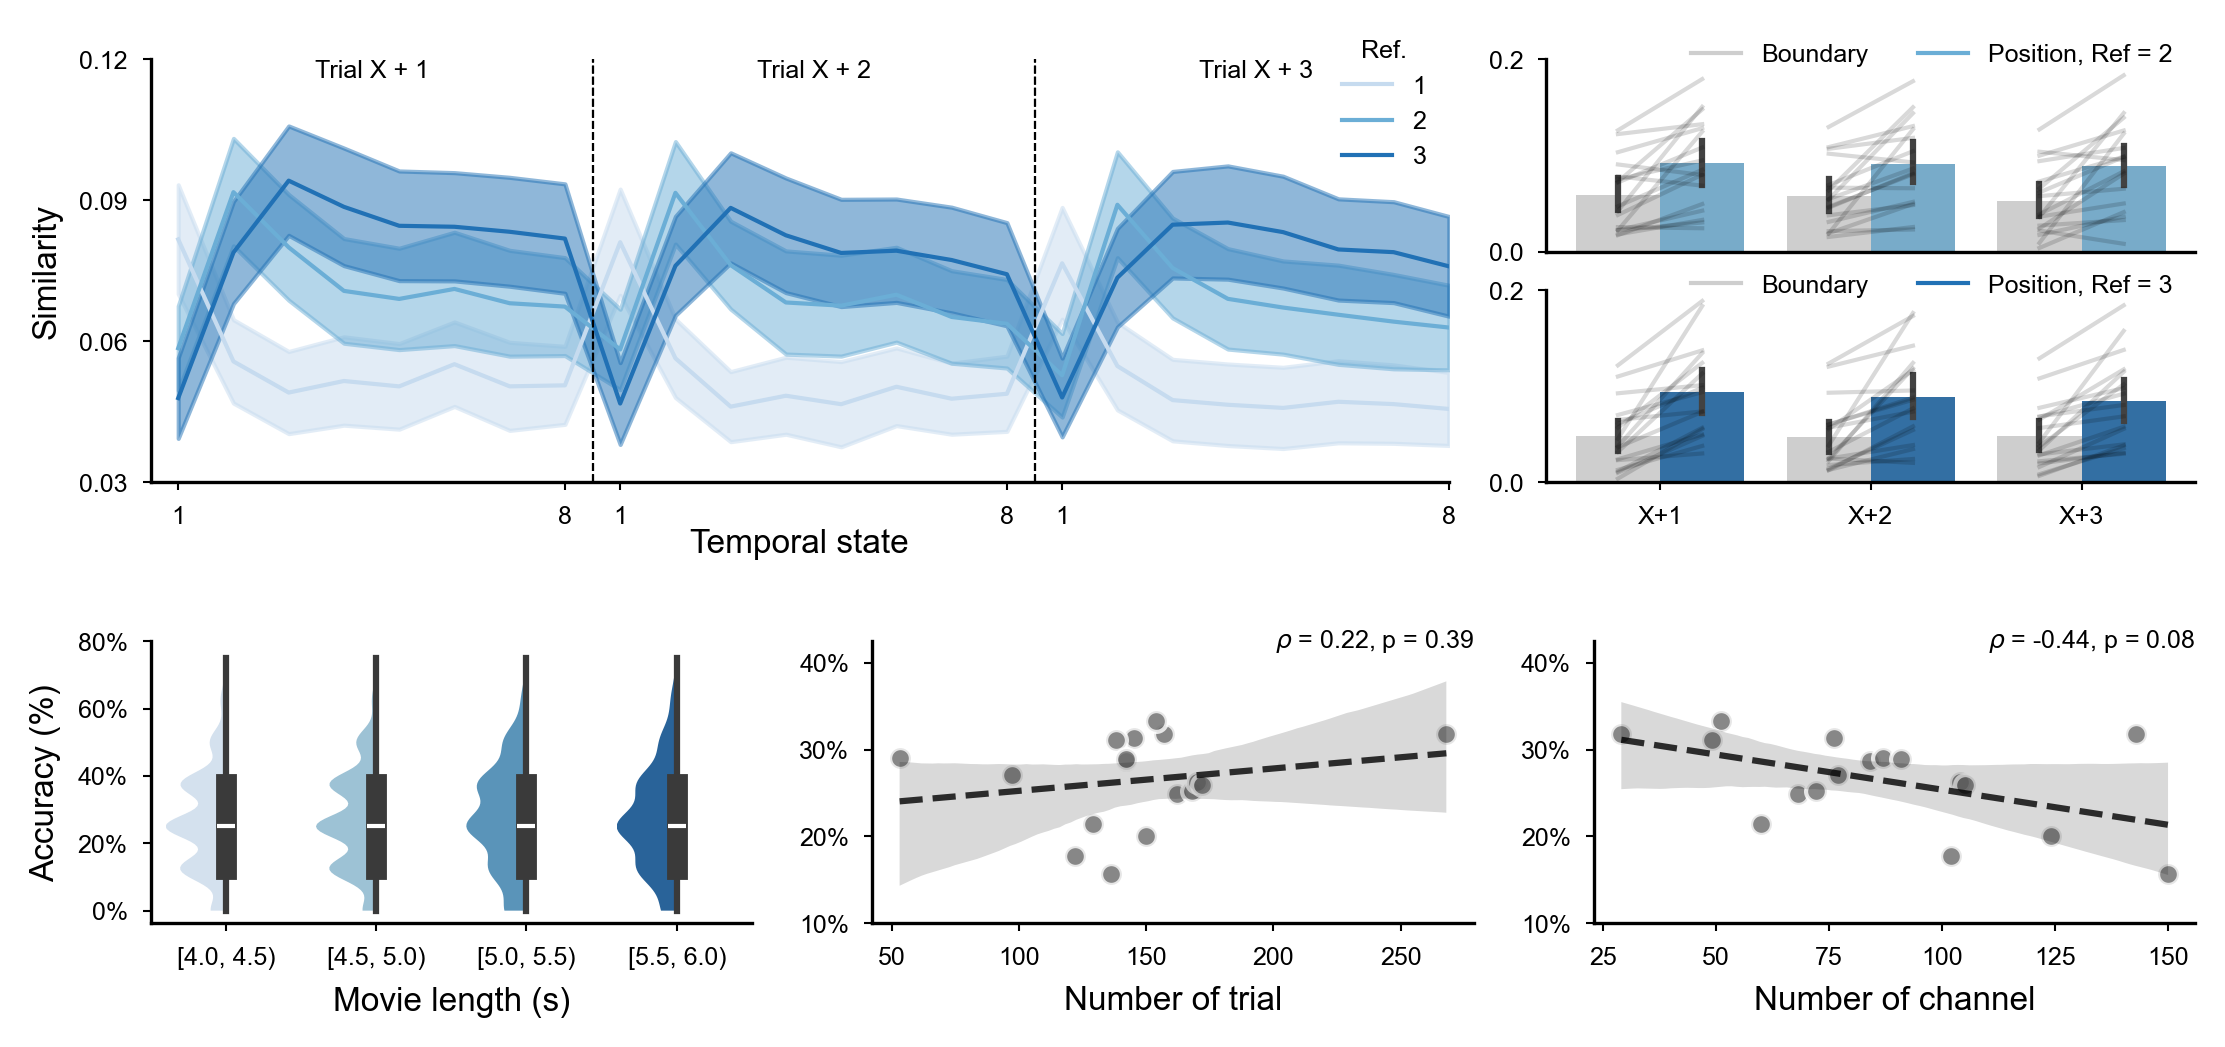

In [ ]:
plt.clf()

fig = plt.figure(figsize=(7.1,3), dpi=300)

gs_main = fig.add_gridspec(
    nrows=2, ncols=1,
    height_ratios=[1.5,1],
    top=0.98, bottom=0.02,
    left=0.02, right=0.98,
    hspace=0.45
)

gs_reg = gs_main[1].subgridspec(
    nrows=1, ncols=3,
    wspace=0.2
)


# Pattern similarity analysis
gs_across = gs_main[0].subgridspec(
    nrows=1, ncols=2,
    width_ratios=[2,1],
    wspace=0.1
)


# Across line plot
ax1 = fig.add_subplot(gs_across[0])


pos_palette = cmaps.blues.discrete(5)
for rp in range(3):
    avg_traces = list()
    for sub_sim in across_cm.values():
        traces = [np.mean(sub_sim[rp][latr],axis=0) for latr in range(3)]
        traces = np.concatenate(traces, axis=0)
        avg_traces.append(traces)
    
    _u = np.mean(avg_traces, axis=0)
    _err = stats.sem(avg_traces, axis=0)

    edge = [latr * nstates - 0.5 for latr in range(1, 3)]
    
    ax1.plot(_u, label=rp+1, color=pos_palette(1+rp))
    ax1.fill_between(np.arange(_u.shape[0]), _u - _err, _u + _err,  alpha=0.5, color=pos_palette(1+rp))

    for e in edge:
        ax1.axvline(e, color='k', linestyle='--', linewidth=0.5)
    

ax1.set_ylim([0.03,.12])
ax1.set_yticks([.03,.06,.09,.12])


ax1.set_xticks([0,7,8,15,16,23])
ax1.set_xticklabels([1,8,1,8,1,8])

ax1.set_xlim([-.5,23])

ax1.set_xlabel('Temporal state', labelpad=0)
ax1.set_ylabel('Similarity')
# ax1.set_title('Across Trial')

for i, x in enumerate([3.5,11.5,19.5]):
    ax1.text(x, .12, f'Trial X + {i+1}', va='top', ha='center', fontsize=6)

custom_lines = [
    Line2D([0], [0], color=pos_palette.colors[1], label="1"),
    Line2D([0], [0], color=pos_palette.colors[2], label="2"),
    Line2D([0], [0], color=pos_palette.colors[3], label="3"),
]

ax1.legend(handles=custom_lines, 
           loc="upper right", bbox_to_anchor=(1, 1.1),
           frameon=False, 
           title='Ref.', title_fontsize=6)


sns.despine(ax=ax1)

# Across stats barplot + scatterplot
gs_across_stats = gs_across[1].subgridspec(ncols=1,nrows=2, wspace=0.1,hspace=.2)
ax1 = fig.add_subplot(gs_across_stats[0])
sns.barplot(data=plot_across[plot_across.Ref==2], hue='Type', y='Similarity', x='LagTrial',
            palette=dict(Boundary_Sim=colors_neg[0], Position_Sim=pos_palette.colors[2]),
            ax = ax1,
            linewidth=1.5,
            legend=False,
            )


sns.despine(ax=ax1)

ax1.tick_params(axis='x',labelbottom=False, bottom=False)
ax1.set_xlabel('')
ax1.set_ylabel('')



ax2 = fig.add_subplot(gs_across_stats[1], sharex=ax1, sharey=ax1)
sns.barplot(data=plot_across[plot_across.Ref==3], hue='Type', y='Similarity', x='LagTrial',
            palette=dict(Boundary_Sim=colors_neg[0], Position_Sim=pos_palette.colors[3]),
            ax = ax2,
            linewidth=1.5,
            legend=False,
            )


dodge = 0.2
for (ref, lag), grp in across_df.groupby(['Ref','LagTrial']):
    ax = ax1 if ref == 2 else ax2
    for idx, row in grp.iterrows():
        ax.plot([row.LagTrial-1-dodge, row.LagTrial-1+dodge], [row.Boundary_Sim, row.Position_Sim], color='k', linewidth=1, alpha=.15)

ax1.set_yticks([0,.2])
ax2.set_xticks([0,1,2])
ax2.set_xticklabels(['X+1', 'X+2', 'X+3'])
ax2.set_ylabel('')
ax2.set_xlabel('')
sns.despine(ax=ax2)


custom_lines = [
    Line2D([0], [0], color=colors_neg[0], label="Boundary"),
    Line2D([0], [0], color=pos_palette.colors[2], label="Position, Ref = 2"),
    Line2D([0], [0], color=pos_palette.colors[3], label="Position, Ref = 3"),
]

ax1.legend(handles=custom_lines[:2], 
           loc="upper right", bbox_to_anchor=(1, 1.2),
           frameon=False, ncols=2,

           )

ax2.legend(handles=[custom_lines[0],custom_lines[-1]], 
           loc="upper right", bbox_to_anchor=(1, 1.2),
           frameon=False, ncols=2,
           )

# Decoding performance confounds

axes_reg = [fig.add_subplot(gs_reg[0, i]) for i in range(3)]


ax3 = axes_reg[0]

sns.violinplot(data=duration_df, x='MovieLengthBin', y='Accuracy', palette='Blues', hue='MovieLengthBin'
                    ,dodge=False
                    , inner_kws=dict(box_width=5, whis_width=1.5, linewidth=2)
                    , cut=0
                    ,legend=False
                    , ax = ax3
               )

xlim = ax3.get_xlim()
ylim = ax3.get_ylim()
for violin in ax3.collections:
    bbox = violin.get_paths()[0].get_extents()
    x0, y0, width, height = bbox.bounds
    violin.set_clip_path(plt.Rectangle((x0, y0), width / 2, height, transform=ax3.transData))
    violin.set_edgecolor('none')


ax3.set_yticks([0, .2,.4,.6,.8])
ax3.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 

ax3.set_xlabel('Movie length (s)')
ax3.set_ylabel('Accuracy (%)')
sns.despine(ax=ax3)


for ax, cond, bw, xlabel in zip(axes_reg[1:], ['Ntrials','Nchannels'], [50, 25], ['trial', 'channel']):
    sns.regplot(data=shape_df, x=cond, y='Train_acc', 
            scatter_kws={'color': 'dimgray', 'edgecolor':'white', 's':25},  # Adjust scatter point color
            line_kws={'color': 'k', 'linewidth': 1.5, 'alpha':0.8, 'ls':'dashed'},  
            ci=95,  # Confidence interval (default is 95%)
            scatter=True,  # Show scatter plot points
            fit_reg=True,
            ax = ax
            )
    ax.set_ylim([.1, .425])
    ax.set_yticks([.1, .2, .3, .4])
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
    
    ax.set_xticks(np.arange(bw, shape_df[cond].max()+1, bw))
    ax.set_xlabel('Number of ' +xlabel)
    ax.set_ylabel('')
    sns.despine(ax=ax)
    
    r, p = stats.spearmanr(shape_df[cond], shape_df.Train_acc)
    ax.text(ax.get_xlim()[1], ax.get_ylim()[1], r'${\rho}$ = ' + str(np.round(r,2)) + ', p = ' + str(np.round(p,2)), 
                 ha='right', va='center',
                 fontsize=6)  
    


# S4

In [ ]:
order = ['benchmark', 'norm', 'content','Delta','Theta','Alpha','Beta','Gamma','HG']
freq_band_labels = {
    'Delta': [3],
    'Theta': [5],
    'Alpha': [8, 12],
    'Beta': [19, 31],
    'Gamma': [40, 79],
    'High Gamma': [130, 210]
}

## Read data

In [ ]:
_path = r'S4'

In [22]:
df_melt = pd.read_csv(os.path.join(_path, r"CV_performance_model_variant.csv"))

spect_data = np.load(os.path.join(_path, 'Event_psd.npz'), allow_pickle=True)

freqs = spect_data['freqs']
event_psd = {event: spect_data[event].item() for event in ['Rest', 'TOJ']}

plot_data = np.load(os.path.join(_path,'Encoding_probas_variant.npz'), allow_pickle=True)

group_tdlm = np.load(os.path.join(_path, 'TDLM_variant.npz'), allow_pickle=True)['data'].item()

## Plot

<Figure size 640x480 with 0 Axes>

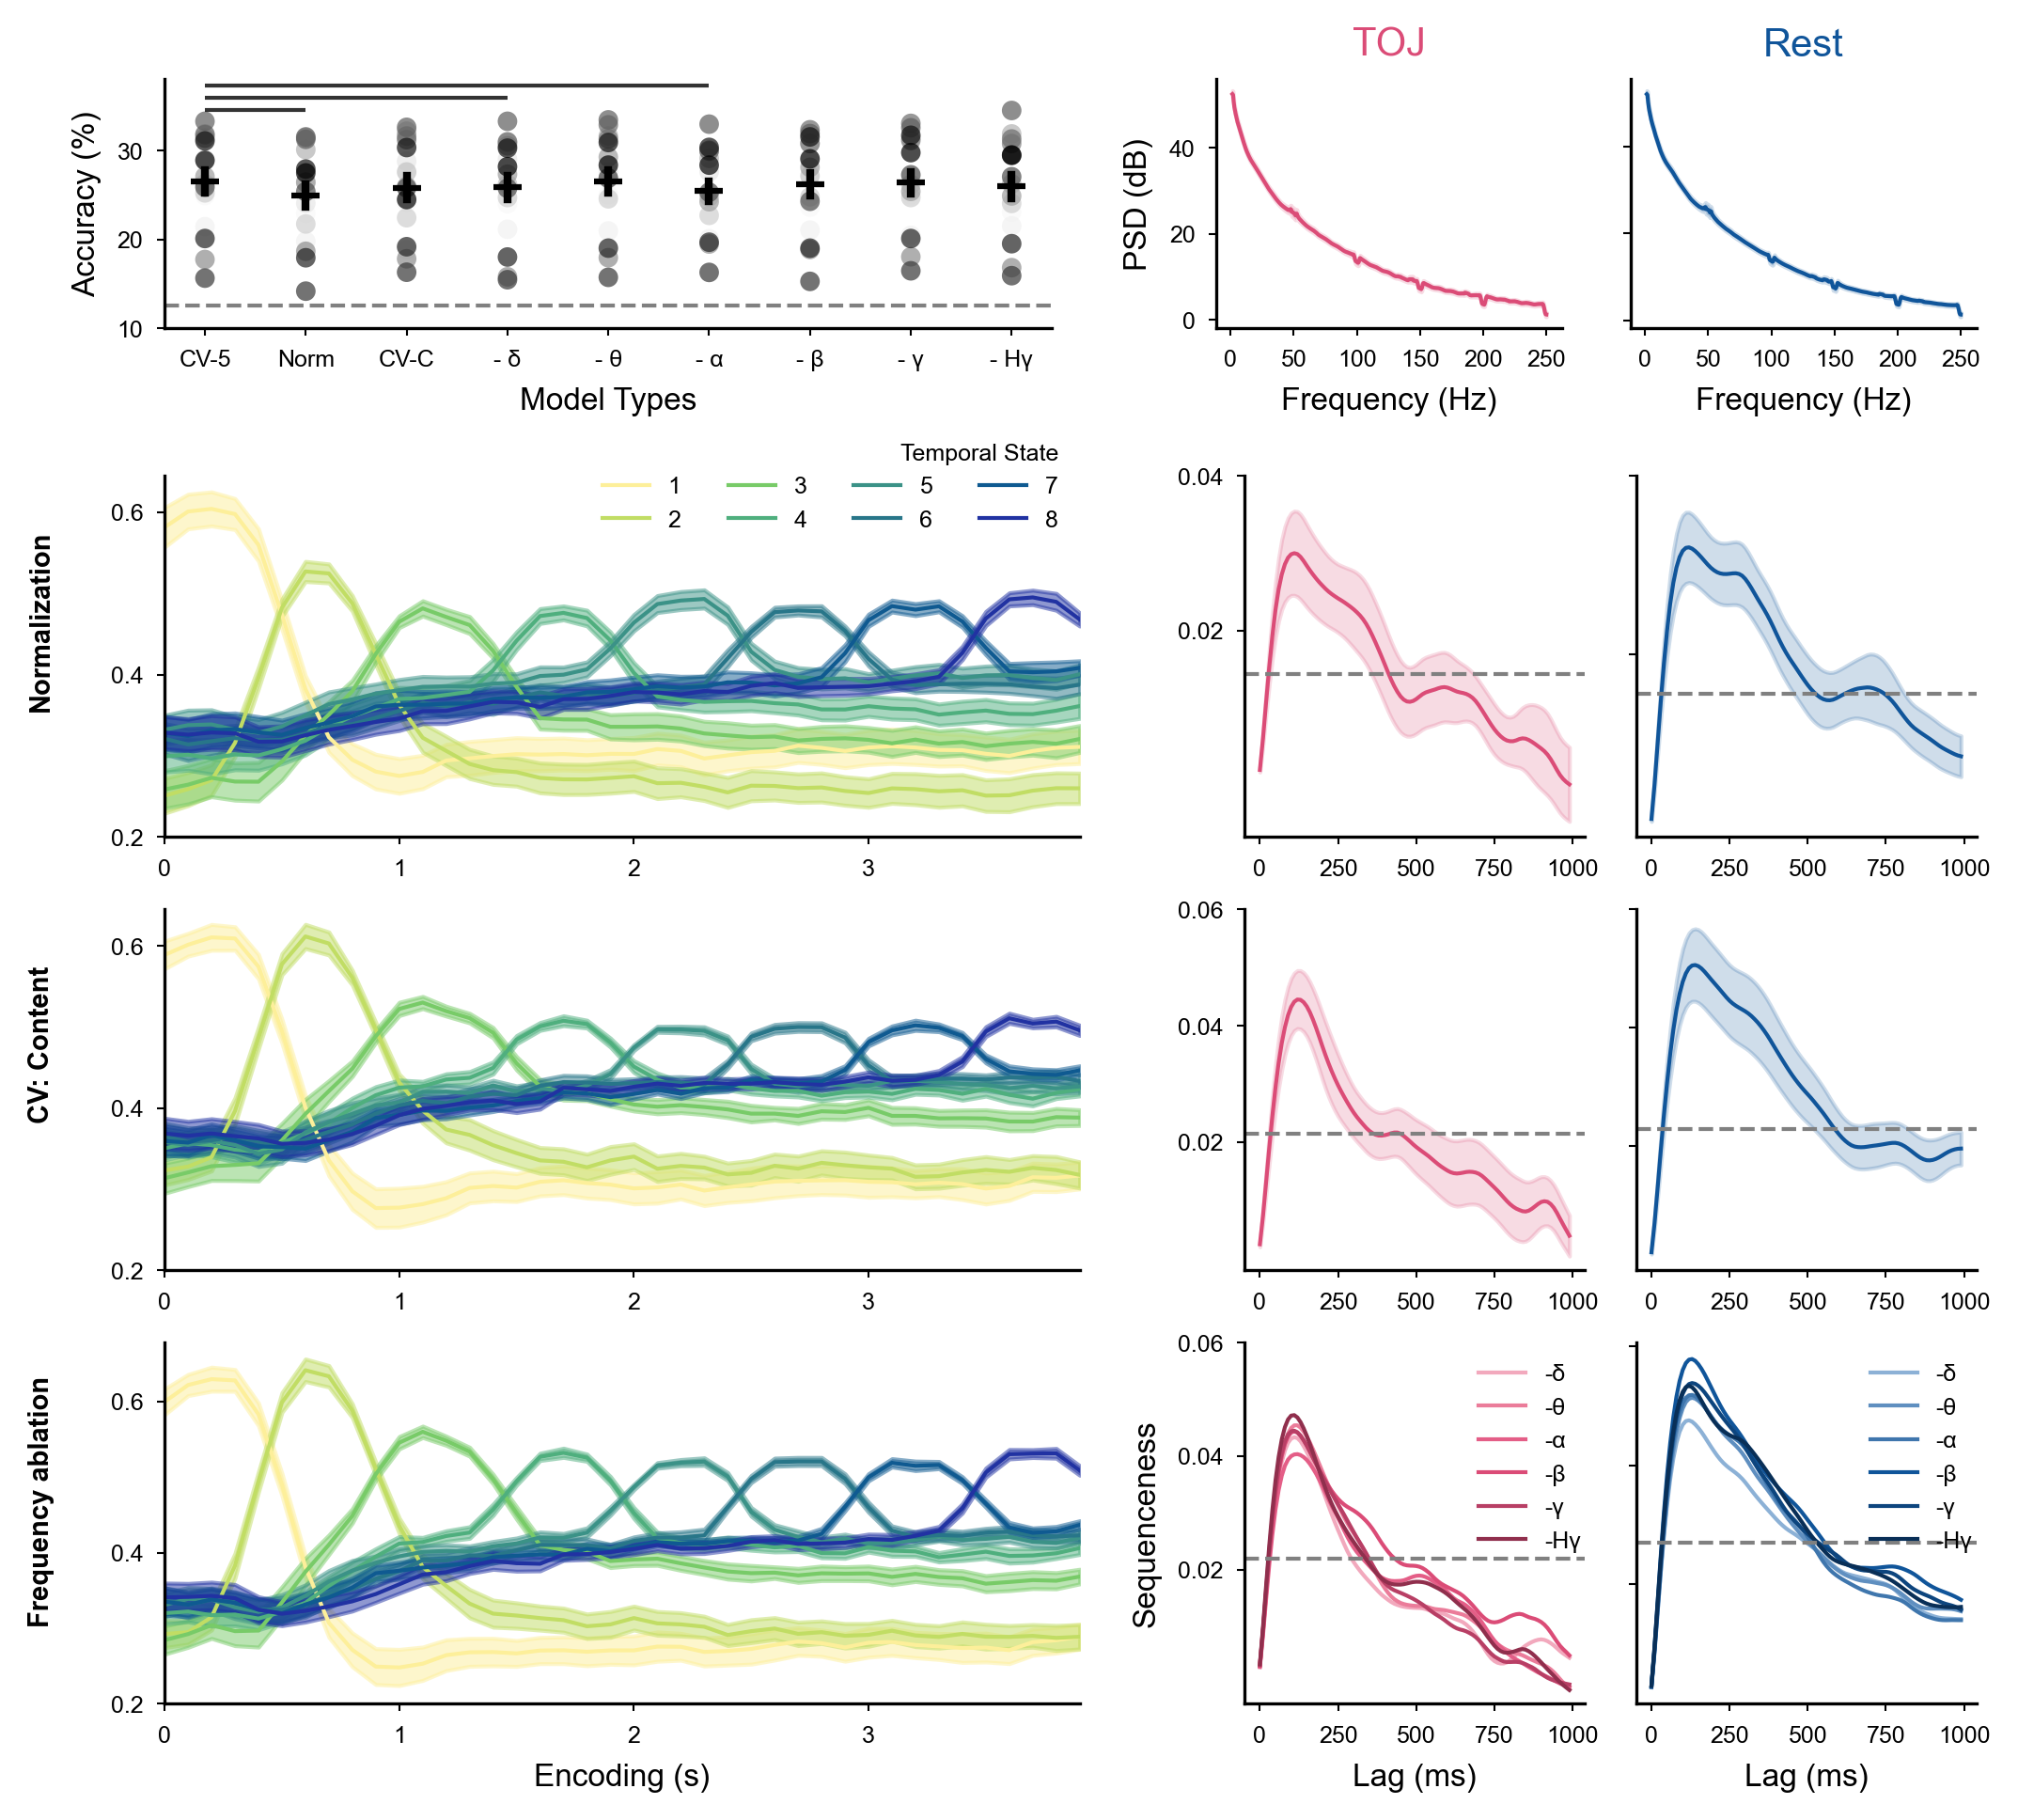

In [23]:
plt.clf()

fig = plt.figure(figsize=(7.1,6), dpi=300)

gs_main = fig.add_gridspec(
    nrows=4, ncols=1,
    height_ratios=[.8,1,1,1],
    top=0.98, bottom=0.02,
    left=0.075, right=0.98,
    hspace=0.5
)

gs_des = gs_main[0].subgridspec(
    nrows=1, ncols=2,
    width_ratios=[1.168,1],
    wspace=0.2
)


gs_spec = gs_des[1].subgridspec(
    nrows=1, ncols=2,
    wspace=0.2
)

gs_var = gs_main[1:].subgridspec(
    nrows=1, ncols=2,
    wspace=0.2, width_ratios=[1.25,1],
    )

gs_probas = gs_var[0].subgridspec(
    nrows=3, ncols=1,
    hspace=0.2
)

gs_tdlm = gs_var[1].subgridspec(
    nrows=3, ncols=2,
    hspace=0.2, wspace=0.15
)

freq_band_labels = {
    'Delta': [3],
    'Theta': [5],
    'Alpha': [8, 12],
    'Beta': [19, 31],
    'Gamma': [40, 79],
    'High Gamma': [130, 210]
}
       
toj_colors = [
    "#f2a9bd",  # very light pink
    "#eb7c9a",  # lighter pink
    "#e45e87",  # mid pink
    "#db4c77",  # base
    "#b83f65",  # dark rose
    "#902f4d",  # deepest
]
rest_colors = [
    "#8cb1d6",  # very light blue
    "#5f8fc0",  # lighter blue
    "#3f76ad",  # mid blue
    "#10559a",  # base
    "#0d457e",  # darker navy
    "#092f57",  # deepest
]

freq_labels = ["-δ", "-θ", "-α", "-β", "-γ", "-Hγ"]


ax_acc = fig.add_subplot(gs_des[0])
sns.stripplot(data=df_melt, x='Variant', y='Accuracy',
            order=order,
            hue='Subject',  palette='Greys', 
            legend=False, dodge=False, jitter=False, alpha=0.7, size=5, zorder=0,
            ax=ax_acc
            )

sns.pointplot(data=df_melt, x='Variant', y='Accuracy',
            order=order,
            color='k', 
            legend=False, ls='none', errorbar='se', units='Subject', 
            marker='_', markersize=7, lw=2,
            ax=ax_acc
            )


ax_acc.set_xticks(np.arange(9), ['CV-5', 'Norm', 'CV-C', '- δ', '- θ', '- α', '- β', '- γ', '- Hγ'])

# ax_acc.yaxis.set_major_formatter(FuncFormatter(lambda x,position: '%1.0f'%(100*x)+'%'))
ax_acc.axhline(0.125, ls='--', color='grey', lw=1, zorder=-1)
ax_acc.set_ylim(0.1,0.38)
for i, pairs in enumerate([(0,1),(0,3),(0,5)]):
    x1, x2 = pairs
    y, h = .825,.05
    ax_acc.hlines(y + h *(1+i), x1, x2, color='k', alpha=.8, lw=1,
                  transform=ax_acc.get_xaxis_transform()
                  )

ax_acc.set_yticks([.1,.2,.3],[10,20,30])
ax_acc.set_xlabel('Model Types')
ax_acc.set_ylabel('Accuracy (%)')

sns.despine(ax=ax_acc)

ax_spec = [fig.add_subplot(gs_spec[i]) for i in range(2)]
for ax, event in zip(ax_spec, ['TOJ','Rest']):
    ax.set_title(event, color=color_dict[event])
    event_dict = event_psd[event]
    mean_psd = [np.mean(psd, axis=0) + 120 for sub, psd in event_dict.items()]

    _u = np.mean(mean_psd, axis=0)
    _err = stats.sem(mean_psd, axis=0)
    # _err = np.std(mean_psd, axis=0)

    ax.plot(freqs, _u, color=color_dict[event])
    ax.fill_between(freqs, _u - _err, _u + _err, color=color_dict[event], alpha=0.2)
    
    ax.set_xticks([0,50,100,150,200,250])
    ax.set_xlabel('Frequency (Hz)')
    sns.despine(ax=ax)
    
ax_spec[1].tick_params(axis='y', which='both', left=True, labelleft=False)
ax_spec[0].set_ylabel('PSD (dB)')


axes_probas = [fig.add_subplot(gs_probas[i]) for i in range(3)]


nstates = 8
cmap = plt.get_cmap(cmaps.haline.discrete(1+nstates).reversed())

for ax, variant in zip(axes_probas, ['norm', 'content']):
    cv_probas = np.array(plot_data[variant])
    _u = cv_probas.mean(axis=0)
    _err = stats.sem(cv_probas, axis=0)

    for s in range(nstates):
        ax.plot(_u[s], label=s+1, color=cmap(s))
        ax.fill_between(np.arange(_u.shape[1]), _u[s]-_err[s], _u[s]+_err[s], alpha=0.5, color=cmap(s))
    sns.despine(ax=ax)


leg = axes_probas[0].legend(loc='upper right', ncols=nstates//2, frameon=False, 
            bbox_to_anchor = (1,1.15),
            title='Temporal State',  
            title_fontproperties=dict(family='arial', size=6),
            )    


leg._legend_box.align = "right" # force title right alignment


ax = axes_probas[-1]
freq_probas = [np.mean(plot_data['No_' + (freq_band if freq_band != 'High Gamma' else 'HG')], axis=0)
            for freq_band in freq_band_labels.keys()] # nfreqs, ntimes, nstates

_u = np.mean(freq_probas, axis=0)
lb, ub = np.percentile(freq_probas, [0, 100], axis=0)

for s in range(nstates):
    ax.plot(_u[s], label=f'State {s+1}', color=cmap(s))
    ax.fill_between(np.arange(_u.shape[1]), _u[s]-_err[s], _u[s]+_err[s], alpha=0.5, color=cmap(s))
    sns.despine(ax=ax)


for ax in axes_probas:
    ax.set_yticks([.2,.4,.6])
    ax.set_xticks(np.arange(0,40+1,10), np.arange(5))
    
ax.set_xlabel('Encoding (s)')


for event, col_idx in zip(['TOJ', 'Rest'], [0, 1]):
    axes_event = [fig.add_subplot(gs_tdlm[i,col_idx]) for i in range(2)]

    for dir_name, ax, yticks in zip(['Normalization', 'Content_raw'], axes_event, [[.02,.04],[.02,.04,.06]]):
        event_dict = group_tdlm[dir_name][event]

        obs, perms = event_dict['obs'], event_dict['perm']
        
        _u = obs.mean(axis=0)
        _err = stats.sem(obs, axis=0)
        _thresh = np.percentile(perms.max(axis=0), 95, axis=0)

        ax.plot(obs.mean(axis=0), color=color_dict[event])
        ax.fill_between(np.arange(_u.shape[0]), _u - _err, _u + _err, color=color_dict[event], alpha=0.2)
        ax.axhline(_thresh, ls='--', color='grey', lw=1)

        ax.set_xticks(np.arange(0,101,25),np.arange(0,1001,250))
        ax.set_yticks(yticks)
        sns.despine(ax=ax)
        
axes_event = [fig.add_subplot(gs_tdlm[2,i]) for i in range(2)]
for ax, event in zip(axes_event, ['TOJ', 'Rest']):
    color_list = rest_colors if event == 'Rest' else toj_colors
    
    thresholds = list()
    for f_id, freq_band in enumerate(freq_band_labels.keys()):
        freq_key = 'No' + (freq_band if freq_band != 'High Gamma' else 'HG') + '_raw'
        
        event_dict = group_tdlm[freq_key][event]
        obs, perms = event_dict['obs'], event_dict['perm']
        
        _u = obs.mean(axis=0)
        _thresh = np.percentile(perms.max(axis=0), 95, axis=0)
        
        ax.plot(_u, color=color_list[f_id], label=freq_labels[f_id])

        thresholds.append(_thresh)
        
        
    max_threshold = max(thresholds)
    
    ax.axhline(max_threshold, color='gray', ls='dashed')
    
    ax.set_yticks([.02,.04,.06])
    ax.set_xticks(np.arange(0,101,25),np.arange(0,1001,250))
    
    ax.legend(frameon=False, loc='upper right', bbox_to_anchor=(1.05, 1))
    sns.despine(ax=ax)


for ax in axes_probas:
    ax.margins(x=0) 

for idx in [-1,-3,-4]:
    fig.axes[idx].tick_params(axis='y', which='both', left=True, labelleft=False)

fig.axes[-2].set_ylabel('Sequenceness')
fig.axes[-1].set_xlabel('Lag (ms)')
fig.axes[-2].set_xlabel('Lag (ms)')

for i, event in zip([6,8], ['TOJ','Rest']):
    ax = fig.axes[i]



for label, y in zip(['Normalization', 'CV: Content', 'Frequency ablation'], [0.66, 0.41, 0.14]):
    fig.text(
        0.02, y, label, 
        ha='right', va='center',
        fontsize=7, fontweight='bold', rotation=90
    )


fig.subplots_adjust()


# S5

## Read data

In [ ]:
_path = r'S5'

In [29]:
confusion_dict = np.load(os.path.join(_path, 'BinWidth_refit_confusion_matrix.npz'), allow_pickle=True)['data'].item()
tdlm_dict = np.load(os.path.join(_path, 'Group_TDLM_results.npz'), allow_pickle=True)['data'].item()

## Plot

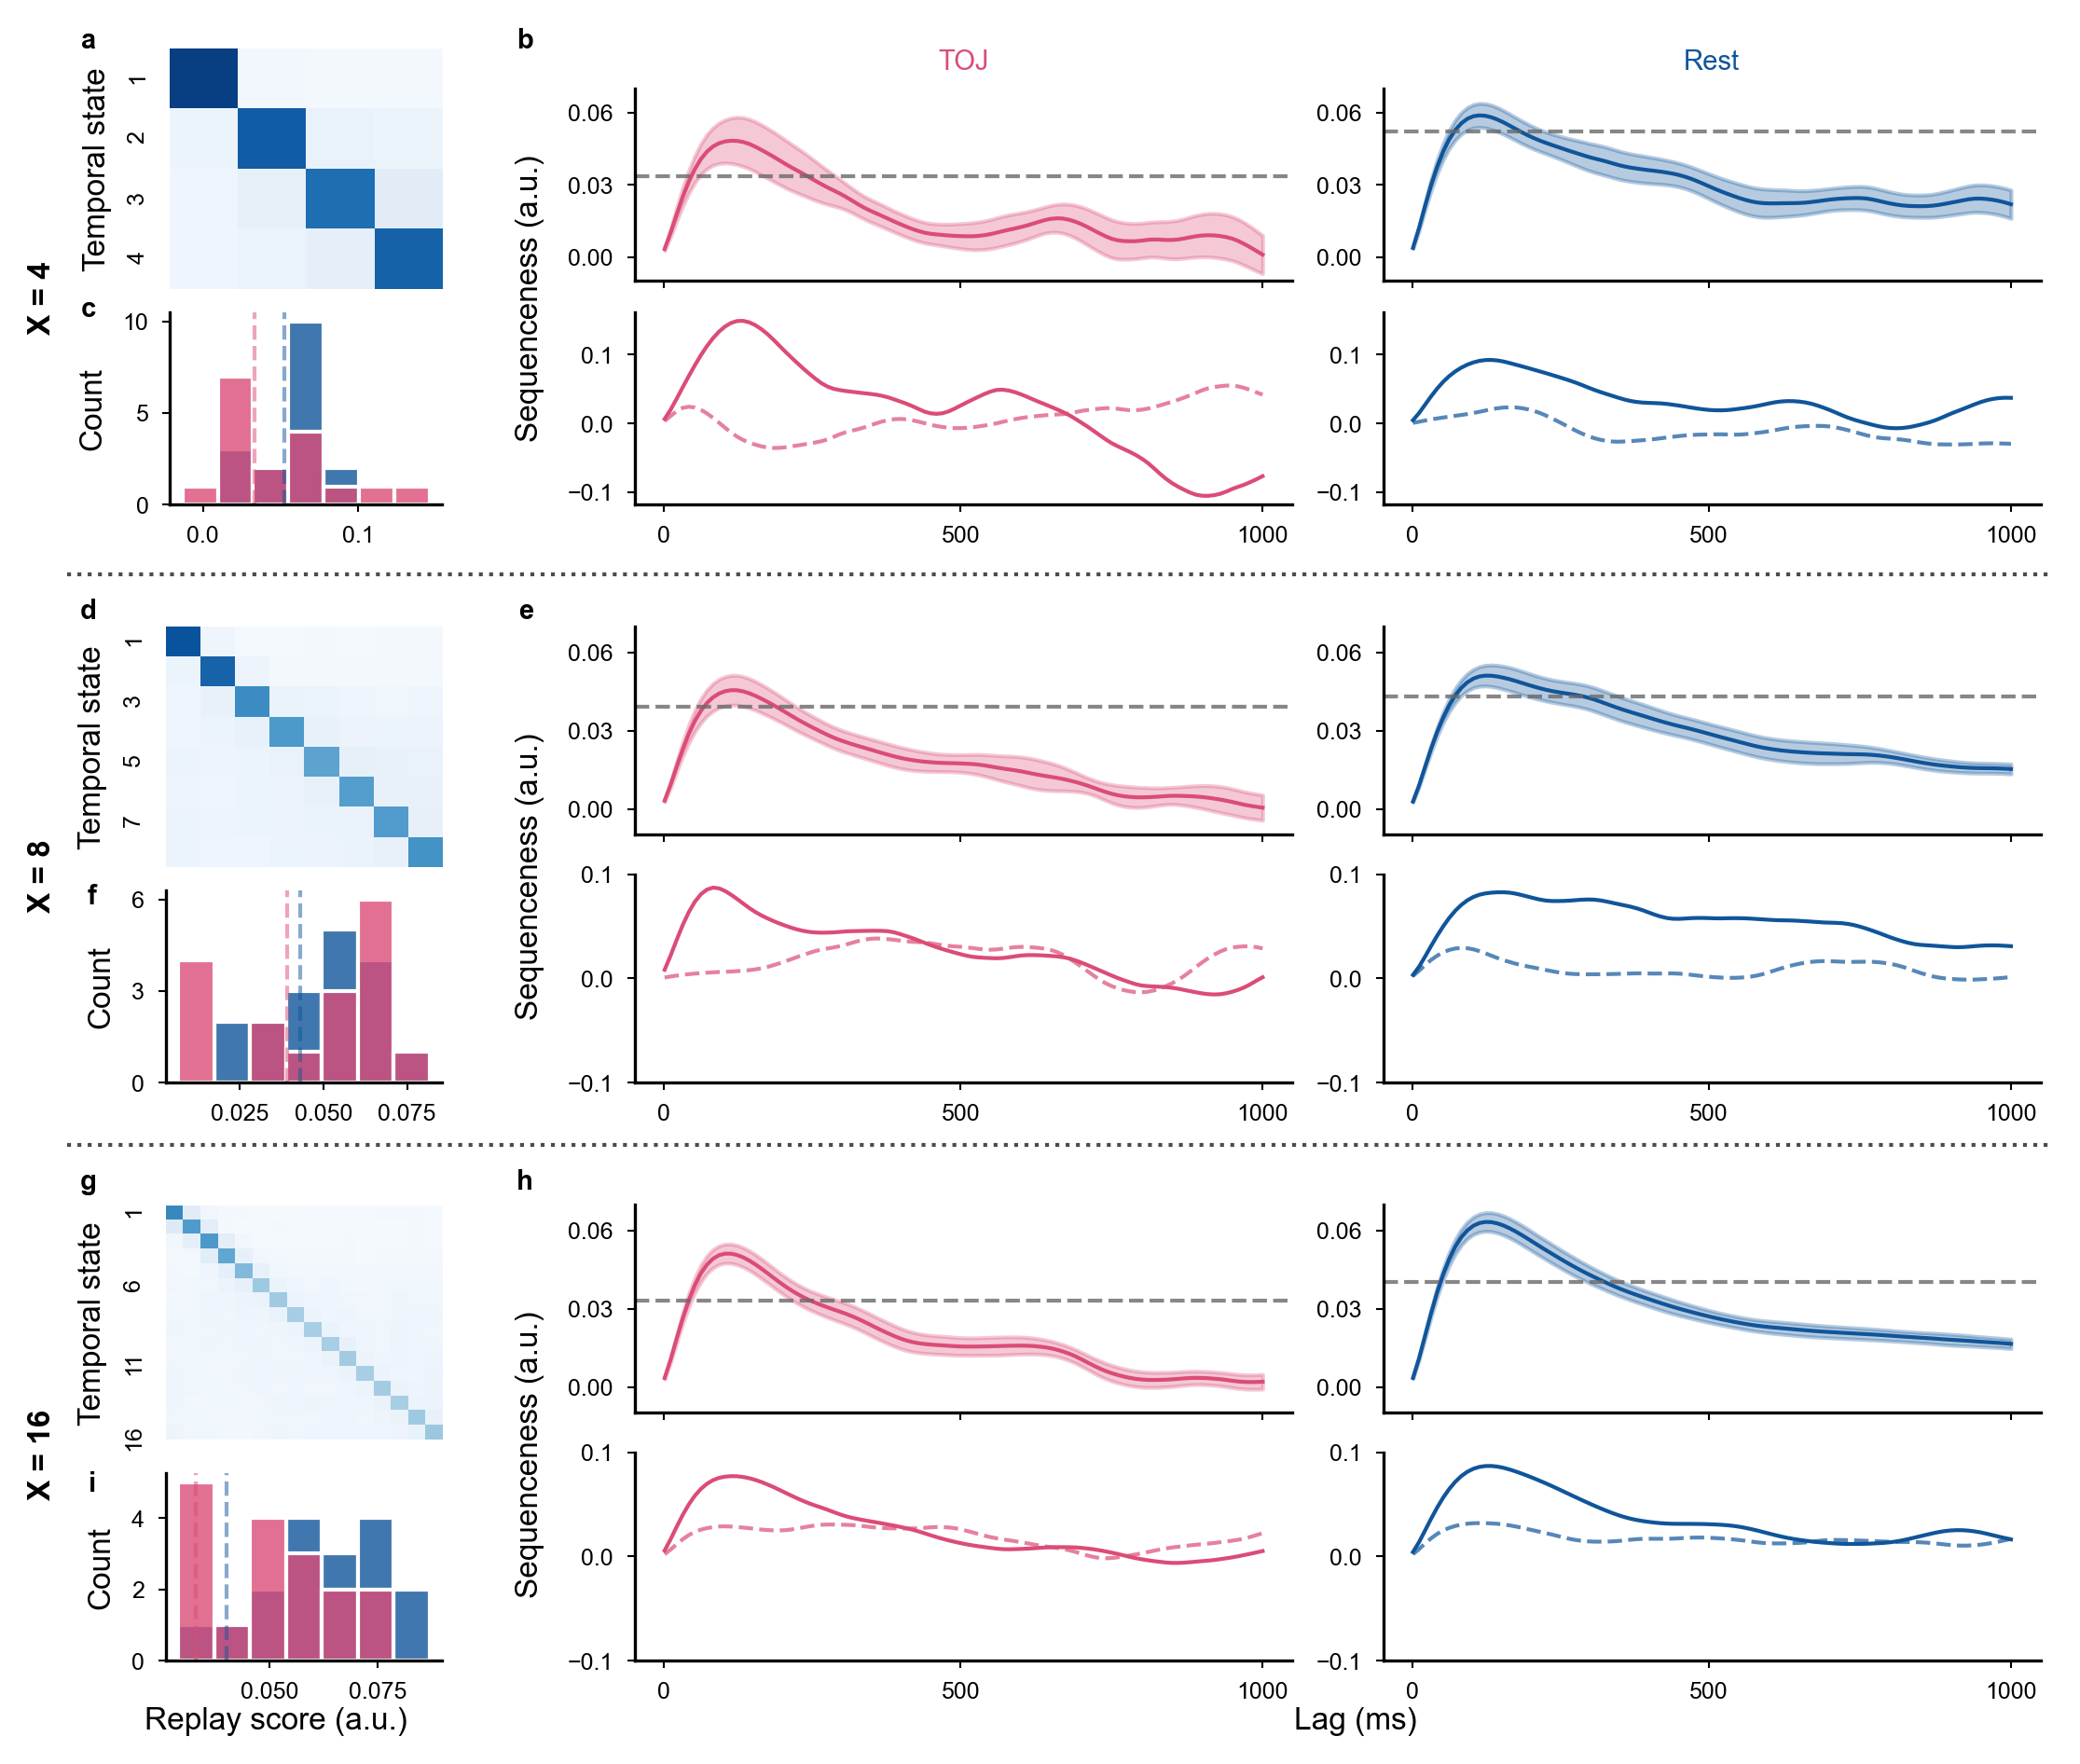

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7.1,6), layout='constrained', dpi=300)

subfigs = fig.subfigures(3, 2, 
                         width_ratios=[1,4],
                         hspace=.1, wspace=.05
                         )  



for bw, row_idx in zip([1000,500,250],[0,1,2]):
    ax0, ax3 = subfigs[row_idx,0].subplots(2,1,
                            height_ratios=[1.25,1],
                        )

    bw_cm = confusion_dict[f'BW{bw}']
    ax0.imshow(bw_cm, cmap='Blues', vmin=0, vmax=1, aspect='auto', origin='upper')
    # ax0.set_axis_off()
    sns.despine(ax=ax0, bottom=True, left=True)

    axes = subfigs[row_idx,1].subplots(2,2, sharex=True)
    df = list()
    for ax_col, event in zip([0,1], ['TOJ','Rest']):
        
        ax1, ax2 = axes[:,ax_col]
        # ax2.sharey(ax1)
        if row_idx == 0:
            ax1.set_title(event, color=color_dict[event], fontsize=7, y=.98)
            
        
        event_dict = tdlm_dict[f'BW{bw}'][event]
        group_obs = np.sum(event_dict['obs'], axis=-1)[...,0]
        
        null_dist = np.sum(event_dict['perm'], axis=-1)[...,0].mean(axis=0).max(axis=0)
        thresh = max(null_dist)

        
        _u = np.mean(group_obs, axis=0)
        _err = stats.sem(group_obs, axis=0)
        
        ax1.plot(_u, color=color_dict[event])
        ax1.fill_between(np.arange(_u.shape[0]), _u - _err,  _u + _err, alpha=.3, color=color_dict[event])
        ax1.axhline(thresh, ls='dashed', color='dimgrey', alpha=.8)
        
        peak_lag = np.mean(group_obs, axis=0).argmax()
        subj_obs = group_obs[:, peak_lag]
        
        res = pd.DataFrame(np.transpose([np.arange(subj_obs.shape[0]), subj_obs]), columns=['SubjectID','Seq'])
        res['Event'] = event
        df.append(res)
            
        
        peak_subj = group_obs[:,peak_lag].argmax()
        trough_subj = group_obs[:,peak_lag].argmin()
        
        ax2.plot(group_obs[peak_subj], color=color_dict[event])
        ax2.plot(group_obs[trough_subj], color=color_dict[event], ls='dashed', alpha=.7)
        
        ax3.axvline(thresh, ls='dashed', color=color_dict[event], alpha=.5)
        
    df = pd.concat(df, ignore_index=True)
    sns.histplot(data=df,x='Seq', 
                edgecolor ='w', 
                hue='Event', palette=color_dict, legend=False, 
                alpha=.8,
                ax=ax3
                )

    sns.despine(ax=ax3)
    ax3.set_xlabel('')
    ax3.set_ylabel('')
        
    subfigs[row_idx,1].supylabel("Sequenceness (a.u.)", fontsize=8)
    for ax in axes[0,:]:
        ax.set_yticks([0,.03,.06])
        ax.set_ylim([-0.01,0.07])
        sns.despine(ax=ax)


    for ax in axes[1,:]:
        ax.set_yticks([-.1,0,.1])
        ax.set_xticks([-.1,49,99],[0,500,1000])
        sns.despine(ax=ax)
        
    axes[1,1].sharey(axes[1,0])
    
    ax0.set_ylabel('Temporal state')
    ax0.tick_params(axis='both', labelbottom=False, bottom=False, left=False)
    
    ax3.set_ylabel('Count')
    
    if bw == 1000:
        ax0.set_yticks(np.arange(4), [1,2,3,4], rotation=90)
    elif bw == 500:
        ax0.set_yticks(np.arange(0,8,2), [1,3,5,7], rotation=90)
        ax3.set_yticks([0,3,6])

    else:
        ax0.set_yticks(np.arange(0,16,5), [1,6,11,16], rotation=90)


subfigs[-1,-1].supxlabel('Lag (ms)', fontsize=8, x=.55, ha='center', y=-.04)   
subfigs[-1,0].supxlabel('Replay score (a.u.)', fontsize=8, x=.54, ha='center',y=-.04)   


fig.align_ylabels([fig.axes[i] for i in [0,1,6,7,11,12]])
for ax_row, bw in zip(subfigs[:,0], [1000,500,250]):
    ax_row.supylabel(f'X = {4000 // bw}', fontsize=8, fontweight='bold', x= -.1)



for label, pos_y in zip(['a','d','g'],[.99,.65,.31]):
    fig.text(.015, pos_y, label,
              fontsize=7, fontweight='bold', va='bottom', ha='right'
             )
    
for label, pos_y in zip(['b','e','h'],[.99,.65,.31]):
    fig.text(.235, pos_y, label,
              fontsize=7, fontweight='bold', va='bottom', ha='right'
             )

for label, pos_y in zip(['c','f','i'],[.83,.48,.13]):
    fig.text(.015, pos_y, label,
              fontsize=7, fontweight='bold', va='bottom', ha='right'
             )


import matplotlib.lines as lines

fig.add_artist(lines.Line2D([0, 1], [0.68, 0.68], ls='dotted', color='k', alpha=.7))
fig.add_artist(lines.Line2D([0, 1], [0.34, 0.34], ls='dotted', color='k', alpha=.7))


# S6

## Read data

In [ ]:
_path = r'S6'

In [33]:
data = np.load(os.path.join(_path, r'TDLM_Simulation.npz'), allow_pickle=True)
results = data['data'].item()
group_cm = data['cm'].item()

del data

n_samples = 1000
n_channels = 1
n_bands = 10

# -------------------------
# Hypothesis 1: DC offset or single-band drift
# -------------------------
X_ar = np.random.randn(n_samples, n_bands) 
for t in range(1, n_samples):
    X_ar[t] += 0.8 * X_ar[t-1]  # AR(1) process

# baseline noise
X1 = np.zeros((n_samples, n_bands))

# add slow drift in band 3 (arbitrary)
drift = np.linspace(0, 1.5, n_samples)  # linear offset
X1[:, 3] += drift
X1 += X_ar * 0.05

# -------------------------
# Hypothesis 2: Sliding frequency peak with constant total power
# -------------------------
X2 = np.zeros((n_samples, n_bands))

band_idx_float = np.linspace(0, n_bands-1, n_samples) 


for t in range(n_samples):
    idx = int(band_idx_float[t])
    frac = band_idx_float[t] - idx
    if idx < n_bands - 1:
        X2[t, idx] = 1 - frac
        X2[t, idx + 1] = frac
    else:
        X2[t, idx] = 1

# add small noise
X2 += X_ar * 0.05

## Plot

<Figure size 640x480 with 0 Axes>

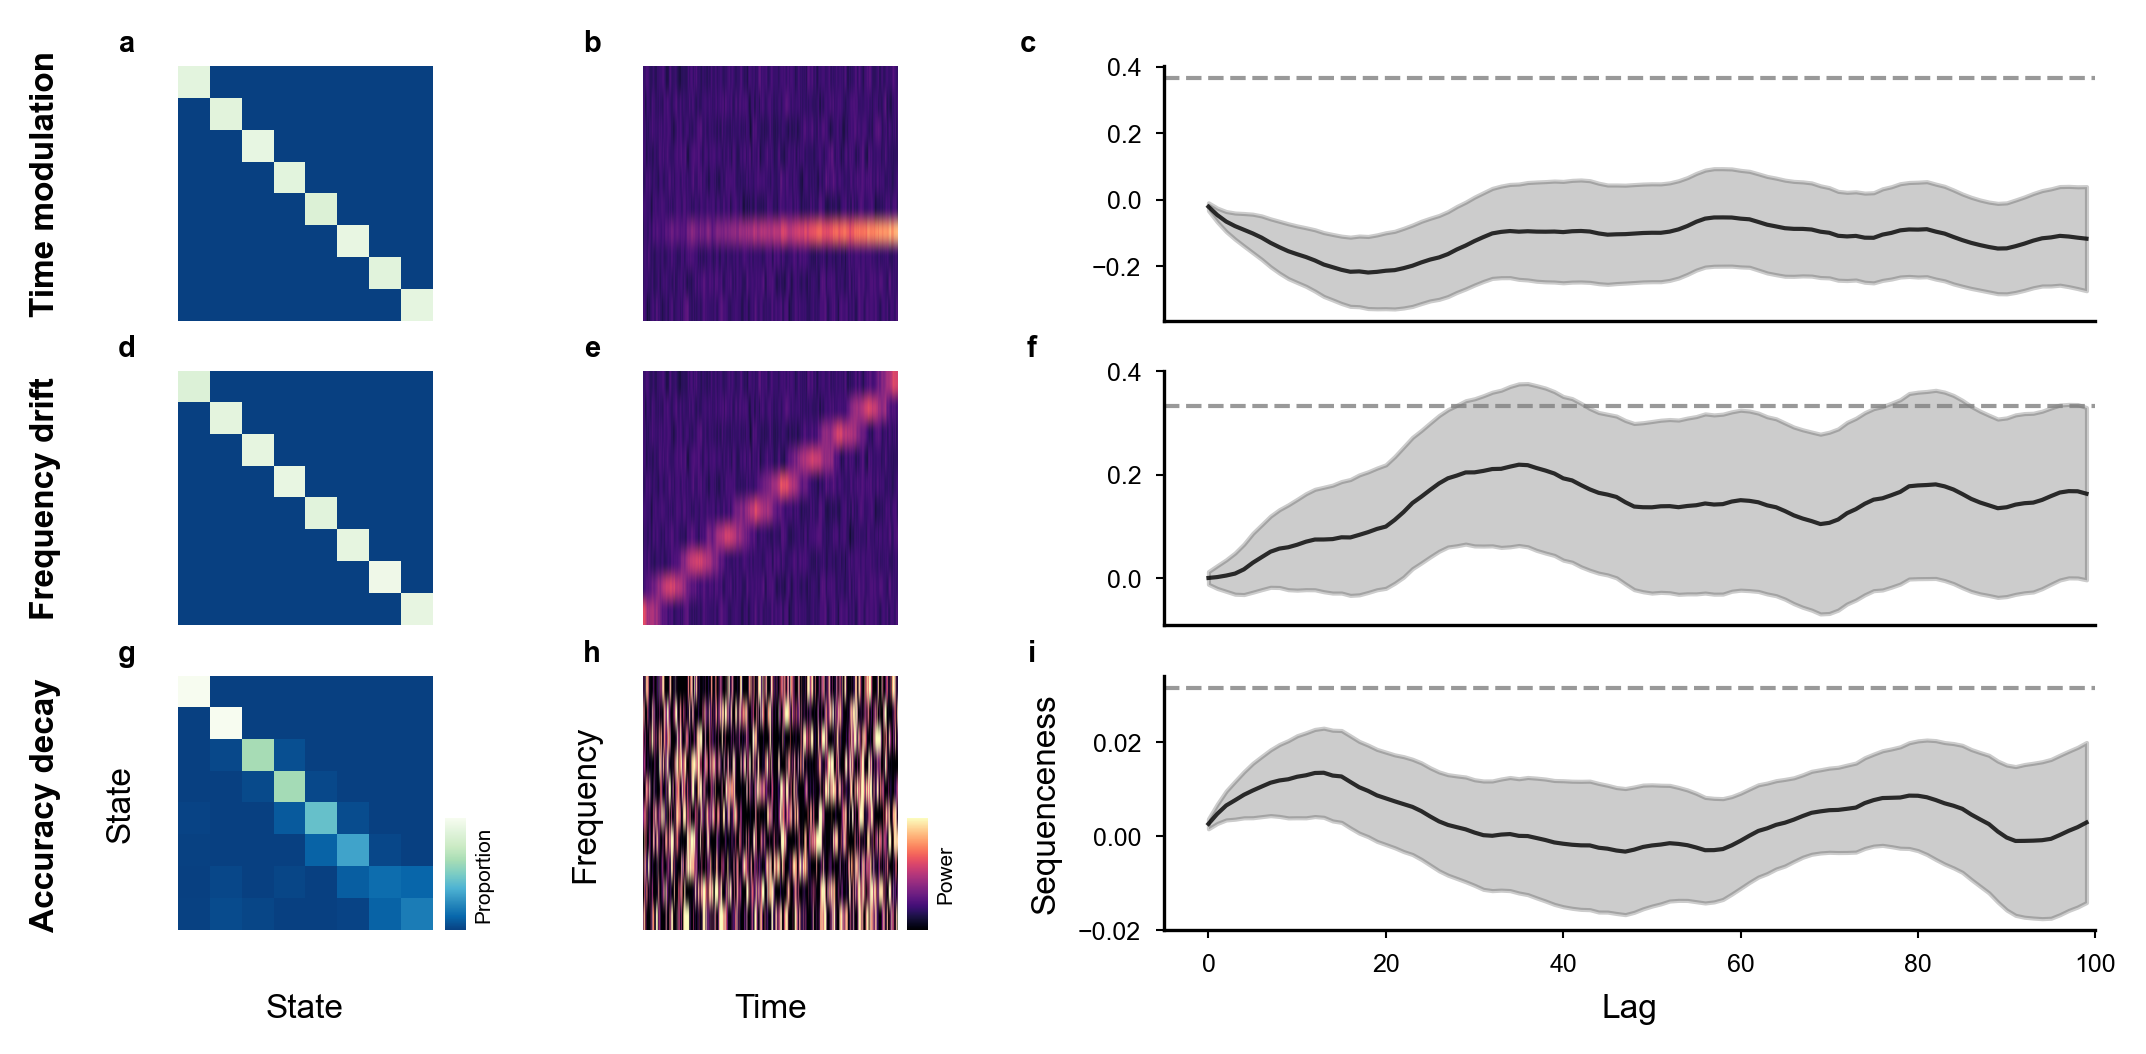

In [34]:
plt.clf()

fig = plt.figure(figsize=(7.1,3), dpi=300)

gs_main = fig.add_gridspec(
    nrows=1, ncols=2,
    width_ratios=[1.,1],
    top=0.98, bottom=0.02,
    left=0.04, right=0.98,
    hspace=0.1, wspace=0.15
)

gs_square = gs_main[0].subgridspec(
    nrows=3, ncols=2, 
    width_ratios=[1,1.2],
    hspace= 0.2, wspace=0.
)

gs_tdlm = gs_main[1].subgridspec(
    nrows=3, ncols=1,
    hspace=.2
)

axes_cm = [fig.add_subplot(gs_square[i,0]) for i in range(3)]
cm_list = np.array(group_cm['benchmark'])
for ax in axes_cm[:-1]:
    sample_cm = cm_list[np.random.choice(cm_list.shape[0],cm_list.shape[0],replace=True)]
    cm = np.mean(sample_cm, axis=0)
    cm = cm / np.sum(cm, keepdims=True, axis=1)
    ax.imshow(cm, aspect="equal", origin="upper", cmap="GnBu_r", vmin=0.1, vmax=.65)

cm_list = np.array(group_cm['overlap'])
ax = axes_cm[-1]
cm = np.mean(cm_list, axis=0)
cm = cm / np.sum(cm, keepdims=True, axis=1)
im_cm = ax.imshow(cm, aspect="equal", origin="upper", cmap="GnBu_r", vmin=0.1, vmax=.65)
ax.set_xlabel('State')
ax.set_ylabel('State', labelpad=10)

for ax in axes_cm:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
  
  
axes_feature = [fig.add_subplot(gs_square[i,1]) for i in range(3)]
for ax, x in zip(axes_feature,[X1, X2, X_ar]):
    im_feat = ax.imshow(x.T, aspect="auto", origin="lower", cmap="magma", vmin=-.5,vmax=2)
    ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False)
    sns.despine(ax=ax, left=True, bottom=True)
    
axes_feature[-1].set_xlabel('Time')
axes_feature[-1].set_ylabel('Frequency', labelpad=10)

for ax in axes_feature:
    ax.set_box_aspect(1)

axes_tdlm = [fig.add_subplot(gs_tdlm[i]) for i in range(3)]
for ax, var in zip(axes_tdlm, ['dc','freq','overlap']):
    obs = np.sum(results[('obs', var)], axis=1)
    
    _u = np.mean(obs, axis=0)
    _err = stats.sem(obs, axis=0)
    
    ax.plot(_u, color='k', alpha=.8)
    ax.fill_between(np.arange(len(_u)), _u-_err, _u+_err, color='k', alpha=.2)
    
    _thresh = np.percentile(np.sum(results[('permutation', var)], axis=2).mean(axis=0).max(axis=-1), 95)
    ax.axhline(_thresh, color='gray', linestyle='--', alpha=.8)
    ax.tick_params(axis='both', which='both', bottom=False, labelbottom=False)
    # ax.margins(x=0) 
    ax.set_xlim(-5,100)
    sns.despine(ax=ax)

ax = axes_tdlm[-1]

ax.tick_params(axis='both', which='both', bottom=True, labelbottom=True)
ax.set_xlabel('Lag')
ax.set_ylabel('Sequenceness')



for ax, xticks in zip(axes_tdlm, [[-.2,0,.2, .4],[0,.2, .4],[-.02,0,.02]]):
    ax.set_yticks(xticks)


cax_feat = fig.add_axes([0.422, 0.020, 0.01, 0.125])  # manual placement

# Make the colorbar in that new axis
cbar_feat = fig.colorbar(im_feat, cax=cax_feat)

# Style
cbar_feat.set_label("Power", fontsize=5, labelpad=2)
cbar_feat.ax.tick_params(right=False, labelright=False)
cbar_feat.outline.set_visible(False)


cax_cm = fig.add_axes([0.205, 0.020, 0.01, 0.125])  # manual placement

# Make the colorbar in that new axis
cbar_cm = fig.colorbar(im_cm, cax=cax_cm)

# Style
cbar_cm.set_label("Proportion", fontsize=5, labelpad=2)
cbar_cm.ax.tick_params(right=False, labelright=False)
cbar_cm.outline.set_visible(False)


for label, idx in enumerate([0,3,6,1,4,7,2,5,8]):
    ax = fig.axes[idx]
    pos = ax.get_position()  # Bbox(left,bottom,right,top)
    fig.text(pos.x0 - (0.02 if idx not in [6, 7, 8] else 0.06), 
             pos.y1 + 0.01, 
             chr(97+label), 
             fontsize=7, 
             fontweight='bold', va='bottom', ha='right')




for label, y in zip(['Time modulation','Frequency drift','Accuracy decay'], [0.85, 0.5, 0.16]):
    fig.text(
        0.025, y, label, 
        ha='right', va='center',
        fontsize=8, fontweight='bold', rotation=90
    )

fig.align_xlabels([axes_tdlm[-1], axes_cm[-1], axes_feature[-1]])
fig.subplots_adjust()


# S7

In [ ]:
_path = r'S7'

In [36]:
df_trial = pd.read_csv(os.path.join(_path,r'TDLM_direction_glm.csv'))
df_group = pd.read_csv(os.path.join(_path,r'TDLM_direction_lm_group.csv'))

anova_df = pd.pivot(df_group, index=['Subject','RT'], columns='Event', values='direc').reset_index()

anova_df.columns = ['Subject',  'LogRT', 'SeqOff', 'SeqOn']

In [41]:
df_fixef = pd.read_csv(os.path.join(_path,r'TDLM_direction_glm_boot_summary.csv'))

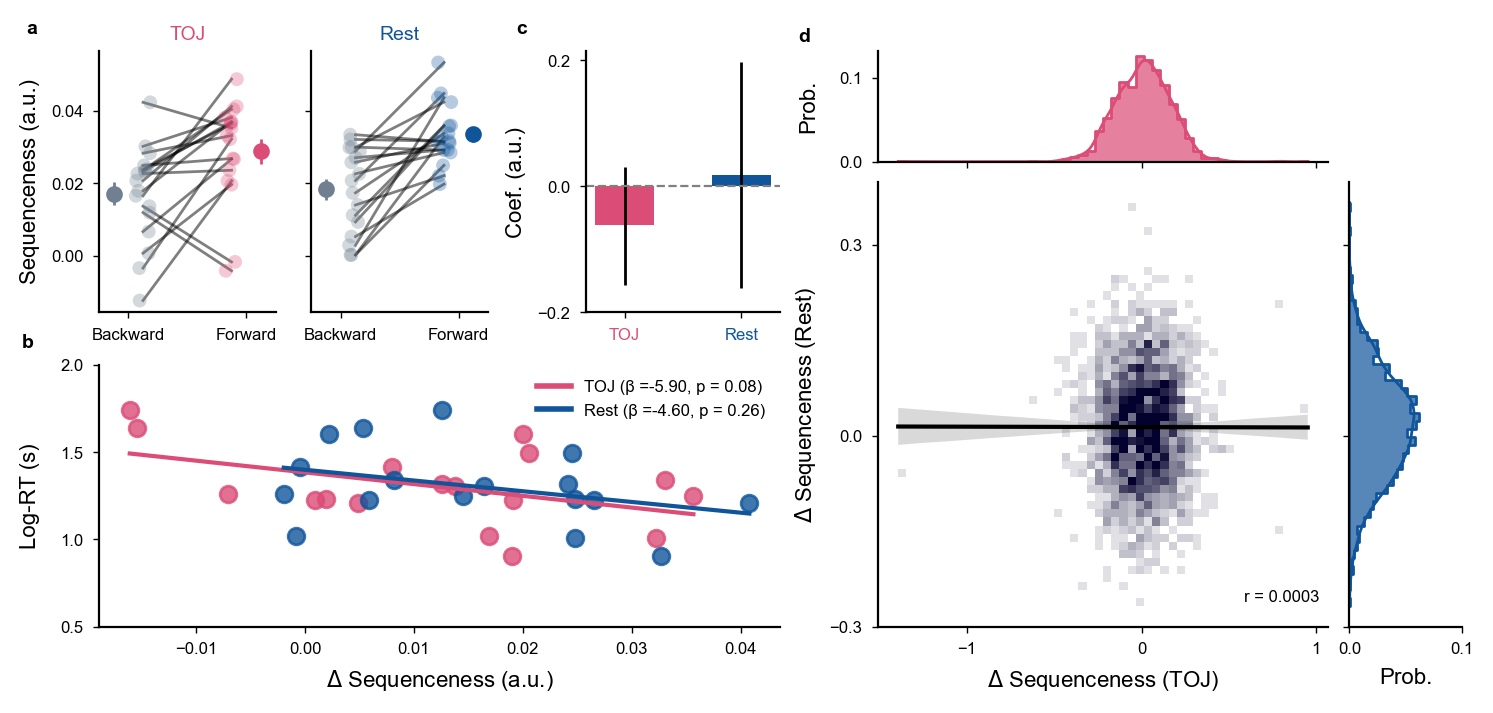

In [42]:
custom_lines = [
    Line2D([0], [0], color=color_dict['TOJ'], lw=2, label=r"TOJ (β =-5.90, p = 0.08)"),
    Line2D([0], [0], color=color_dict['Rest'], lw=2, label=r"Rest (β =-4.60, p = 0.26)")
]


fig = plt.figure(figsize=(7.1, 3), dpi=200)
gs = fig.add_gridspec(nrows=2, ncols=3,
                      width_ratios=[2,1,3],    
                      height_ratios=[1.0, 1.0],
                      left=0.02, right=0.98, top=0.98, bottom=0.02,
                      wspace=0.25, hspace=0.2)


gs_pair = gs[0,0].subgridspec(nrows=1, ncols=2, wspace=0.2)

ax_pairs = [fig.add_subplot(gs_pair[_]) for _ in range(2)]
ax_pairs[1].sharey(ax_pairs[0])
ax_pairs[1].sharex(ax_pairs[0])

for ax, event in zip(ax_pairs, ['TOJ', 'Rest']):
    df_condition = df_group[df_group.Event==event].reset_index(drop=True)
    df_condition = pd.melt(df_condition, id_vars='Subject', value_vars=['fwd', 'rev'], 
                        var_name='Direction', value_name='Seq')
    sns.stripplot(
        data=df_condition, x='Direction', y='Seq', hue='Direction', 
        palette={'rev':'slategray', 'fwd':color_dict[event]},
        order=['rev', 'fwd'],
        dodge=.1, alpha=.3, legend=False, s=5,
        ax=ax
    )
    
    for idx, grp in df_condition.groupby('Subject'):
        fwd = grp[grp.Direction == 'fwd'].Seq.values[0]
        rev = grp[grp.Direction == 'rev'].Seq.values[0]
        ax.plot([.2,.8],[rev, fwd], alpha=.5, ls='-', color='k')
        
    
    for idx, direc in enumerate(['rev', 'fwd']):
        direc_vals = df_condition[df_condition.Direction==direc].Seq
        _u = np.mean(direc_vals)
        _err = stats.sem(direc_vals)

        ax.errorbar(idx, _u, yerr=_err, fmt='o', markersize=5,
                capsize=0, color=color_dict[event] if direc=='fwd' else 'slategray'
                )
    ax.set_title(event, color=color_dict[event], y=.98, fontsize=7)
    sns.despine(ax=ax)
    ax.set_xlabel('')
    if event == 'Rest':
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)

        ax.set_xlim([-.1,1.1])
        ax.set_xticks([.1,.9], ['Backward', 'Forward'])
    else:
        ax.set_ylabel('Sequenceness (a.u.)')

ax_reg = fig.add_subplot(gs[1, :2])

for event in ['TOJ', 'Rest']:
    sns.regplot(data=df_group[df_group.Event==event], y='RT', x='direc', 
                ci=0,
                ax=ax_reg, color=color_dict[event])

sns.despine(ax=ax_reg)
ax_reg.set_ylabel('Log-RT (s)')
ax_reg.set_yticks([.5, 1,1.5,2])
ax_reg.set_xlabel(r'$\Delta$ Sequenceness (a.u.)')

ax_reg.legend(handles=custom_lines, loc='upper right', frameon=False)

    
ax_coef = fig.add_subplot(gs[0, 1])

for x_pos, event in zip([0.2, 0.8], ['TOJ', 'Rest']):
    res = df_fixef[df_fixef.param == ('SeqOn' if event=='TOJ' else 'SeqOff')].iloc[0]

    
    ax_coef.bar(x_pos, res['est'], 
                yerr=np.expand_dims([res['est'] - res['ci_lower'], res['ci_upper'] - res['est']], axis=1),
                width=0.3, 
                color=color_dict[event]
                )
        

ax_coef.axhline(0, color='gray', linestyle='--', linewidth=0.8)
sns.despine(ax=ax_coef)
ax_coef.set_yticks([-.2,0,.2])
ax_coef.set_ylabel('Coef. (a.u.)')
ax_coef.set_xlim([0,1])
ax_coef.set_xticks([0.2,0.8],['TOJ','Rest'], color='#db4c77')

plt.setp(ax_coef.get_xticklabels()[1], color='#10559a')


gs_right = gs[:, 2].subgridspec(nrows=2, ncols=2,
                               height_ratios=[1, 4],
                               width_ratios=[4, 1],
                               hspace=0.075, wspace=0.075)


ax_joint = fig.add_subplot(gs_right[1, 0])
ax_margx = fig.add_subplot(gs_right[0, 0], sharex=ax_joint)
ax_margy = fig.add_subplot(gs_right[1, 1], sharey=ax_joint)

# ---------------------
# 3) joint-distribution

ax_margx.tick_params(axis='x', labelbottom=False)
ax_margx.set_xlabel('')
ax_margx.set_ylabel('')
ax_margy.tick_params(axis='y', labelleft=False)
ax_margy.set_xlabel('')
ax_margy.set_ylabel('')


sns.histplot(data=df_trial, x="SeqOn", kde=True, alpha=0.7, color=color_dict['TOJ'], 
                ax=ax_margx, stat='probability', bins=50,
                element="step"
                )

sns.histplot(data=df_trial, y="SeqOff", kde=True, alpha=0.7, color=color_dict['Rest'], 
                ax=ax_margy, stat='probability', bins=50,
                element="step"
                )

ax_margy.set_ylabel("")
ax_margy.set_xlabel("Prob.")
ax_margy.set_xticks([0,.1])
ax_margy.set_xlim([0,.1])

ax_margx.set_xlabel("")
ax_margx.set_ylabel("Prob.")
ax_margx.set_yticks([0,.1])

sns.despine(ax=ax_margx)
sns.despine(ax=ax_margy)


sns.histplot(data=df_trial, x="SeqOn", y="SeqOff", pmax=0.8, bins=50,
             ax=ax_joint, 
             cbar=False,
             cmap="light:#03012d",
             )
sns.regplot(data=df_trial, x="SeqOn", y="SeqOff", 
                ax=ax_joint, 
                scatter=False,
                color='k', 
                line_kws={'lw':1.5}
                )

r, p = stats.spearmanr(df_trial["SeqOn"], df_trial["SeqOff"])
ax_joint.text(0.98, 0.05, f'r = {r:.4f}', fontsize=6,
                transform=ax_joint.transAxes, 
                # bbox=dict(boxstyle="round", facecolor='white', alpha=0.8),
                va='bottom', ha='right')
ax_joint.set_xticks([-1,0,1])
ax_joint.set_yticks([-.3,0,.3])

ax_joint.set_xlabel(r'$\Delta$ Sequenceness (TOJ)')
ax_joint.set_ylabel(r'$\Delta$ Sequenceness (Rest)')

sns.despine(ax=ax_joint)

for (i, ax_i), x_pos in zip(enumerate([0, 2, 3, 5]), [-.35, -0.095, -.3, -.15]):
    ax = fig.axes[ax_i]
    ax.text(
        x_pos, 
        1.05, 
        chr(97 + i), 
        transform=ax.transAxes, 
        fontsize=7, fontweight='bold', va='bottom', ha='right'
    )

fig.align_ylabels([ax_joint, ax_margx])
fig.align_ylabels([ax_pairs[0], ax_reg])


# S8

In [ ]:
_path = r'S8'

In [45]:
data = np.load(os.path.join(_path, r'Ripple_event_summary.npz'), allow_pickle=True)

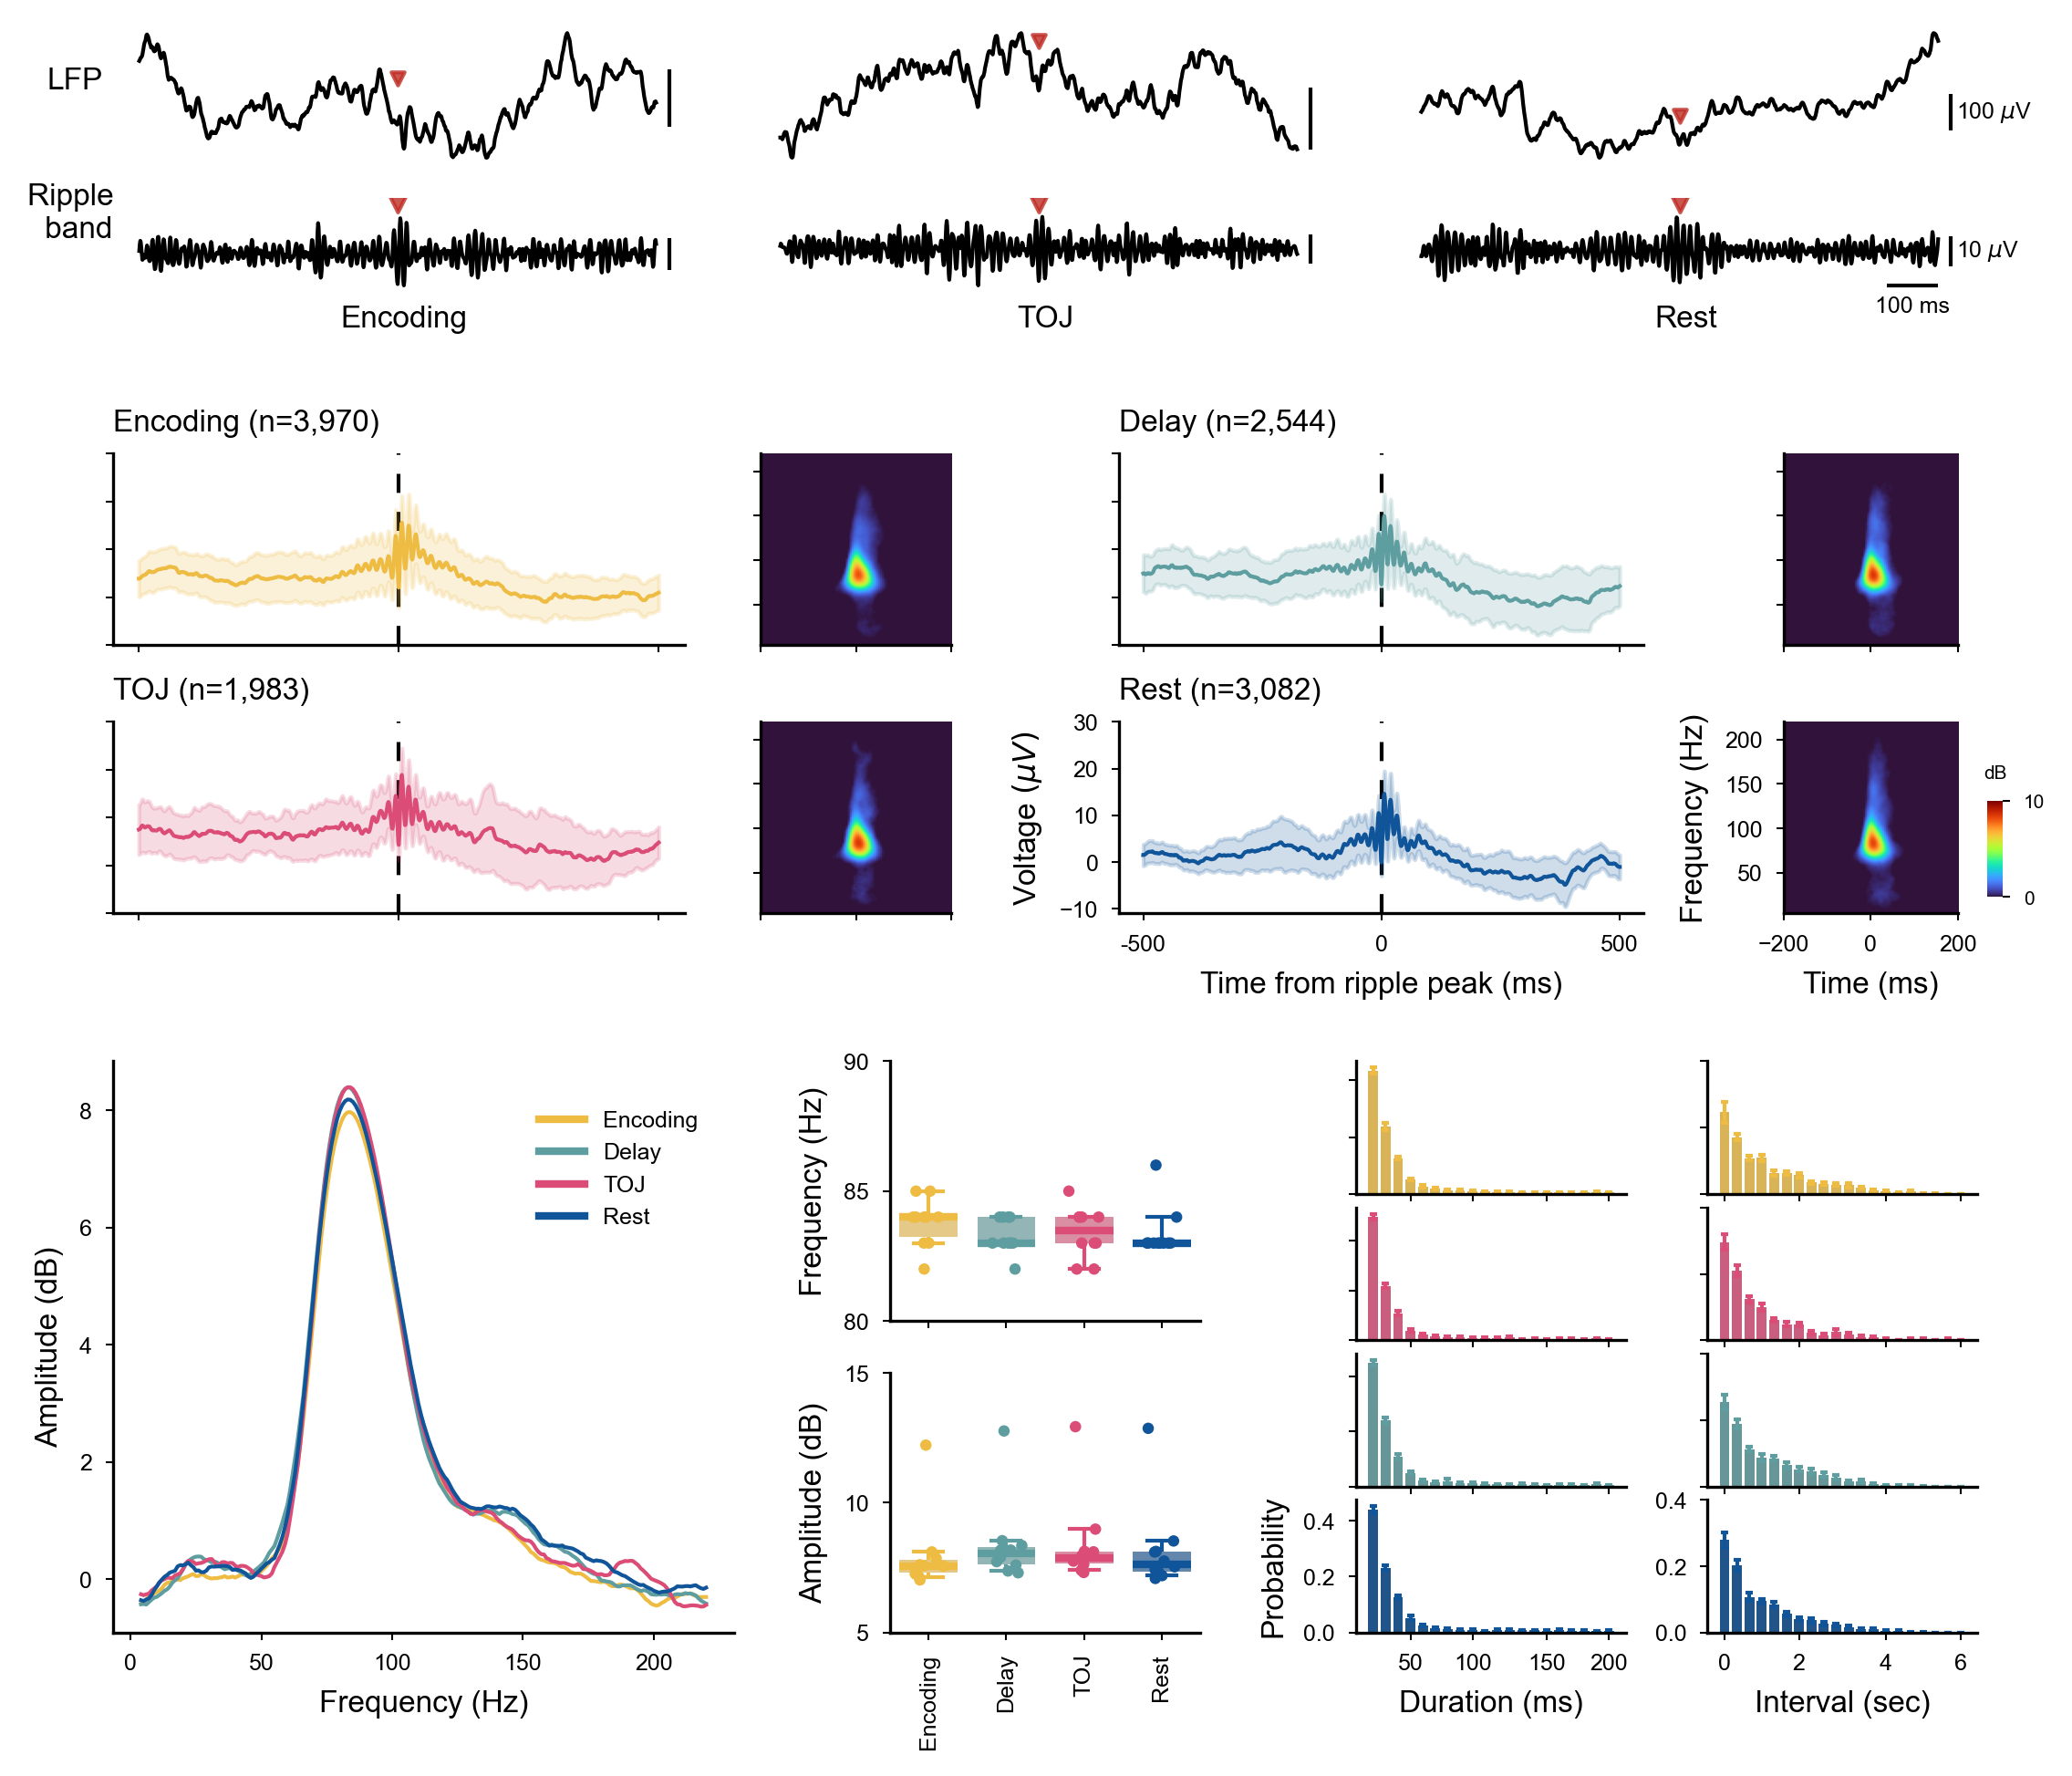

In [47]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(7.1, 6), dpi=300)

gs1 = gridspec.GridSpec(2, 3, figure=fig,
                        top = .98,bottom=.82,
                        left=.02, right=.98,
                        wspace=0.1,hspace=0.3,
                        height_ratios=[1.5,1]
                        )

example_lfp = data['example_lfp'].item()
for col, event in enumerate(['Encoding', 'TOJ', 'Rest']):
    event_data = example_lfp[event]
    lfp, ripple_lfp = event_data['lfp'], event_data['ripple_lfp']
    
    ax_lfp = fig.add_subplot(gs1[0, col])
    ax_ripple = fig.add_subplot(gs1[1, col], sharex=ax_lfp)
    
    ax_lfp.plot(lfp[500:-500], label=event, color='k')

    ax_ripple.plot(ripple_lfp[500:-500], label=event, color='k')
    # ax_ripple.axis('off')
    
    y_lfp = lfp[1000] + 80
    y_ripple = ripple_lfp.max() + 5

    ax_lfp.scatter(500, y_lfp, color='#bf2c23', alpha=.8, marker='v', s=12)
    ax_ripple.scatter(500, y_ripple, color='#bf2c23', alpha=.8, marker='v', s=25)

    # ax_ripple.set_ylim(-10,10)


    ax_lfp.vlines(1025, ymin=lfp.mean()-50, ymax=lfp.mean()+50, color='k')
    ax_ripple.vlines(1025, ymin=ripple_lfp.mean()-5, ymax=ripple_lfp.mean()+5, color='k')

    if col == 2:
        ax_ripple.hlines(ripple_lfp.min() - 1, xmin=900, xmax=1000, color='k')

        ax_lfp.text(1035, lfp.mean(), '100 $\mu$V',  va='center', fontsize=6)
        ax_ripple.text(1035, ripple_lfp.mean(), '10 $\mu$V',  va='center',  fontsize=6)
        ax_ripple.text(950, ripple_lfp.min() - 10, '100 ms',  ha='center', fontsize=6)


    elif col == 0:
        ax_lfp.set_ylabel('LFP', rotation=0, labelpad=10, ha='center')
        ax_ripple.set_ylabel('Ripple \n band', rotation=0, labelpad=10, ha='center')
        
    
    for ax in [ax_lfp, ax_ripple]:
        ax.tick_params(axis='both', which='both', left=False, bottom=False, labelleft=False, labelbottom=False, pad=0)
        sns.despine(ax=ax, left=True, bottom=True)
    ax_ripple.set_xlabel(event)
    
    del event_data, lfp, ripple_lfp
    gc.collect()
    

gs_plots = fig.add_gridspec(2, 2, width_ratios=[ 1, 1], 
                          left=.02, right=.97,
                          top = .72, bottom=.44,
                          wspace=0.2,hspace=0.4)

vmin = 0
vmax = 10
im = None

erp_dict, spect_dict, cnt_dict = data['erp_dict'].item(), data['spect_dict'].item(), data['cnt_dict'].item()

# Loop through conditions
for i, cond in enumerate(['Encoding','Delay','TOJ','Rest']):
    row, col = i // 2, i % 2
    
    lfp = np.array(erp_dict[cond])
    spec = spect_dict[cond]
    cnt = np.sum(cnt_dict[cond])
    
    c = color_dict[cond]

    # Create subplot
    ax_main = fig.add_subplot(gs_plots[row, col])
    
    # Create sub-gridspec for LFP and Spectrogram within this subplot
    if col == 0:
        gs_sub = ax_main.get_subplotspec().subgridspec(1, 2, width_ratios=[3, 1], wspace=0.2)
    else:
        gs_sub = ax_main.get_subplotspec().subgridspec(1, 2, width_ratios=[3, 1], wspace=0.4)
    ax_lfp = fig.add_subplot(gs_sub[0])
    ax_spec = fig.add_subplot(gs_sub[1])
    
    # Hide the main axis
    ax_main.set_axis_off()
    
    # Remove spines for cleaner look
    for ax in [ax_lfp, ax_spec]:
        sns.despine(ax=ax)
    
    # ---- LFP ----
    _u = np.mean(lfp, axis=0)
    _err = stats.sem(lfp, axis=0)

    ax_lfp.plot(_u, color=c)
    ax_lfp.fill_between(np.arange(len(_u)), _u + _err, _u - _err, alpha=0.2, color=c)
    ax_lfp.axvline(500, color='k', lw=1, ls='dashed', zorder=0, dashes=(5,5))

    # Title positioning - move up and center better
    ax_lfp.set_title(f"{cond} (n={cnt:,})", fontsize=8,
                     x=0, ha='left')  # x=1.0 centers across both subplots
    
    # ---- Spectrogram ----
    im = ax_spec.imshow(
        np.mean(spec, axis=0)[:, 200:-200], origin="lower", aspect='auto',
        extent=[-200, 200, 4, 220],
        vmin=vmin, vmax=vmax, cmap="turbo"
    )
    
    # Set ticks for all panels but only show labels where needed
    ax_lfp.set_yticks([-10, 0, 10, 20, 30])
    ax_spec.set_yticks([50, 100, 150, 200])
    ax_lfp.set_xticks([0, 500, 1000], [-500,0,500])
    

    
    # Show labels only on appropriate panels
    if row == 1 and col == 1:
        ax_spec.set_xlabel("Time (ms)")
        ax_spec.set_ylabel("Frequency (Hz)")
        ax_lfp.set_xlabel("Time from ripple peak (ms)")
        ax_lfp.set_ylabel(r'Voltage $(\mu V)$')
    else:
        ax_spec.tick_params(labelleft=False, labelbottom=False)
        ax_lfp.tick_params(labelleft=False, labelbottom=False)


last_spec_pos = ax_spec.get_position()
cbar_height = (last_spec_pos.y1 - last_spec_pos.y0) * 0.5  
cbar_y0 = last_spec_pos.y0 + (last_spec_pos.y1 - last_spec_pos.y0) * 0.25  

cbar_ax = fig.add_axes([.985, .45, 
                        .008, cbar_height])
# Add colorbar
cbar = fig.colorbar(im, cax=cbar_ax, shrink=.4)
cbar.ax.set_title("dB", fontsize=5)  # Added title "dB"
cbar.outline.set_color(None)
cbar.set_ticks([0, 10])
cbar.ax.tick_params(labelsize=5)



# Create gridspec with height ratios [1, 1, 1] and width ratios [2, 1, 2]
gs3 = fig.add_gridspec(4, 3, 
                      width_ratios=[2, 1, 2],
                      top=.35, bottom=.002,
                      left=.02, right=.98,
                      wspace=0.3)

freqs = np.arange(4, 221, 1) 
hue_order = ['Encoding', 'Delay', 'TOJ', 'Rest']
boxprops = {'edgecolor': 'none', 'alpha': 0.7, 'zorder':0}
lineprops = {'color': 'k', 'linewidth': 1}
boxplot_kwargs = {'boxprops': boxprops, 'medianprops':  {'linewidth': 2},
                  'whiskerprops': lineprops, 'capprops': lineprops,
                  'width': 0.75, 'palette': color_dict,
                  'hue_order': hue_order}
stripplot_kwargs = { 'size': 3,
                    'palette': color_dict, 'hue_order': hue_order}


duration_dict, ipi_dict = data['duration_dict'].item(), data['ipi_dict'].item()
peak_df = pd.DataFrame(data['peak_df'], columns=['event','id','peak_amp','peak_freq'])


ax1 = fig.add_subplot(gs3[:,0])

ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude (dB)')



for event, event_list in spect_dict.items():
    ax1.plot(freqs, np.mean(event_list,axis=0)[:,250], label=event, color=color_dict[event])

leg = ax1.legend(frameon=False, loc='upper right', bbox_to_anchor=(.975,.95))
for line in leg.get_lines():
    line.set_linewidth(2.0)

sns.despine(ax=ax1)


gs_box = gs3[:, 1].subgridspec(2,1, hspace=0.2)
for row, meas in enumerate(['peak_freq', 'peak_amp']):
    ax = fig.add_subplot(gs_box[row])
    sns.despine(ax=ax)
    
    sns.boxplot(x='event', y=meas, hue='event', data=peak_df, ax=ax,
        fliersize=0, 
        whis=(2.5, 97.5), 
        **boxplot_kwargs)
    sns.stripplot(x='event', y=meas, hue='event', data=peak_df, ax=ax,
        jitter=0.2, **stripplot_kwargs)


    for i, cat in enumerate(hue_order):
        color = color_dict[cat]

        for j in range(i*6,i*6+6):
            line = ax.lines[j]
            line.set_color(color)
            line.set_mfc(color)
            line.set_mec(color)
            if j == i*6 + 4:
                line.set_linewidth(2)
            
    
    if meas == 'peak_freq':
        ax.set_ylabel('Frequency (Hz)')
        
        ax.set_ylim([80,90])
        ax.set_yticks([80,85,90], [80,85,90])
        ax.tick_params(axis='x', labelbottom=False)
        
    else:
        ax.set_ylabel('Amplitude (dB)')
        ax.set_ylim([5,15])
        ax.set_yticks([5,10,15])
    ax.set_xlabel('')
    ax.set_xticks(['Encoding', 'Delay', 'TOJ', 'Rest'], ['Encoding', 'Delay', 'TOJ', 'Rest'],
                  rotation=90
                  )

gs_hist = gs3[:, 2].subgridspec(4, 2, hspace=0.1, wspace=.3)

for row, (ax_col, meas) in enumerate(zip([0, 1], ['Duration', 'IPI'])):
    if meas == 'Duration':
        data_dict = duration_dict
        bins_arange = np.linspace(20, 200, 21)
        desired_ticks = [50, 100, 150, 200]
        x_label = 'Duration (ms)'
        x_lim = (0, 200)
        y_label = 'Probability'
    else:
        data_dict = ipi_dict
        bins_arange = np.linspace(0, 6, 21)
        desired_ticks = [0, 2, 4, 6]
        x_label = 'Interval (sec)'
        x_lim = (0, 6)
        y_label = ''

    bin_centers = (bins_arange[:-1] + bins_arange[1:]) / 2
    
    for col, (event, event_dict) in enumerate(data_dict.items()):
        ax = fig.add_subplot(gs_hist[col, ax_col])
        sns.despine(ax=ax)
        
        event_hist = list()
        for k, v in event_dict.items():
            counts, _ = np.histogram(v, bins=bins_arange)
            event_hist.append(counts / counts.sum()) # probability
        mean_hist = np.mean(event_hist, axis=0)
        err_hist = stats.sem(event_hist, axis=0)
        
        sns.barplot(x=bin_centers, y=mean_hist, ax=ax, color=color_dict[event], lw=2)
        ax.errorbar(np.arange(len(bin_centers)), mean_hist, yerr=err_hist, color=color_dict[event], capsize=1, ls = '', lw=1)
        

        tick_indices = [np.argmin(np.abs(bin_centers - tick)) for tick in desired_ticks]
        ax.set_xticks(tick_indices)
        ax.set_xticklabels(desired_ticks)
        
        # ax.set_ylim([0,0.5])
        ax.set_yticks([0,0.2,0.4])
        
        if col == 3:
            ax.set_xlabel(x_label)
            ax.set_ylabel(y_label)
        else:
            ax.set_ylabel('')
            ax.tick_params(axis='both', labelleft=False, labelbottom=False)
            
        sns.despine(ax=ax)


fig.subplots_adjust()


# S9

In [ ]:
_path = r'S9'

## Read data

In [59]:
df = pd.read_csv(os.path.join(_path, r"Ripple_records.csv"))

unique_participants = np.unique(df.Subject)
participant_accuracy = {sub: df[df.Subject==sub].Correct.mean() for sub in unique_participants}
sorted_participant = sorted(unique_participants, key=lambda x: participant_accuracy[x])

df['Accuracy'] = df['Correct'] * 100
mean_df = df.groupby(['Subject']).agg({
    'Accuracy': ['mean', 'sem']
}).reset_index(drop=False)
mean_df.columns = ['Subject','mean_acc','sem_acc']
mean_df = pd.merge(mean_df, df[['Subject','Site']].drop_duplicates(), on='Subject', how='inner').sort_values('mean_acc', ascending=True).reset_index(drop=True)

In [60]:
event_ripple = pd.read_csv(os.path.join(_path,
                             f'Ripple_rate_event_records.csv'))
event_ripple = event_ripple.groupby(['Subject', 'event','Site']).aggregate({'duration': 'sum', 'ripple_count': 'sum'}).reset_index()
event_ripple['rate'] = event_ripple['ripple_count'] / event_ripple['duration']

event_df = event_ripple[event_ripple.event.isin(['Encoding', 'Delay', 'TOJ', 'Rest'])].reset_index(drop=True)

In [ ]:
from collections import defaultdict
bin_size = .1
sigma = 1.5
group_psth = np.load(os.path.join(_path, f'Group_event_ripple_psth_CA1_{int(bin_size*1000)}ms_{sigma}sigma_smoothed.npz'), allow_pickle=True)['data'].item()

tdlm_avg = np.load(os.path.join(os.path.dirname(_path), 'M4', 'Peri_Ripple_TDLM_CA1_avg_lag.npz'),
                    allow_pickle=True
                    )['data'].item()
tdlm_res = np.load(os.path.join(os.path.dirname(_path), 'M4', 'Peri_Ripple_TDLM_CA1_avg_lag_correctness.npz'),
                    allow_pickle=True
                    )['data'].item() # Correct, Incorrect, Correct - Incorrect


contrast_dict = defaultdict(list)
event_bins = defaultdict(list)
for sub, sub_dict in group_psth.items():
    for ch, ch_dict in sub_dict.items():
        for event in ['Encoding', 'Delay', 'Retrieval', 'Rest']:
            event_dict = ch_dict[event]
            times = event_dict['bins']
            psth = event_dict['correct'] - event_dict['incorrect']
            
            _event = 'TOJ' if event == 'Retrieval' else event
            contrast_dict[_event].append(psth)
            event_bins[_event] = times
            
loso_si = np.load(os.path.join(_path, 'LOSO_cluster_permutation_results.npz'), allow_pickle=True)['data'].item()

## Plot

<Figure size 640x480 with 0 Axes>

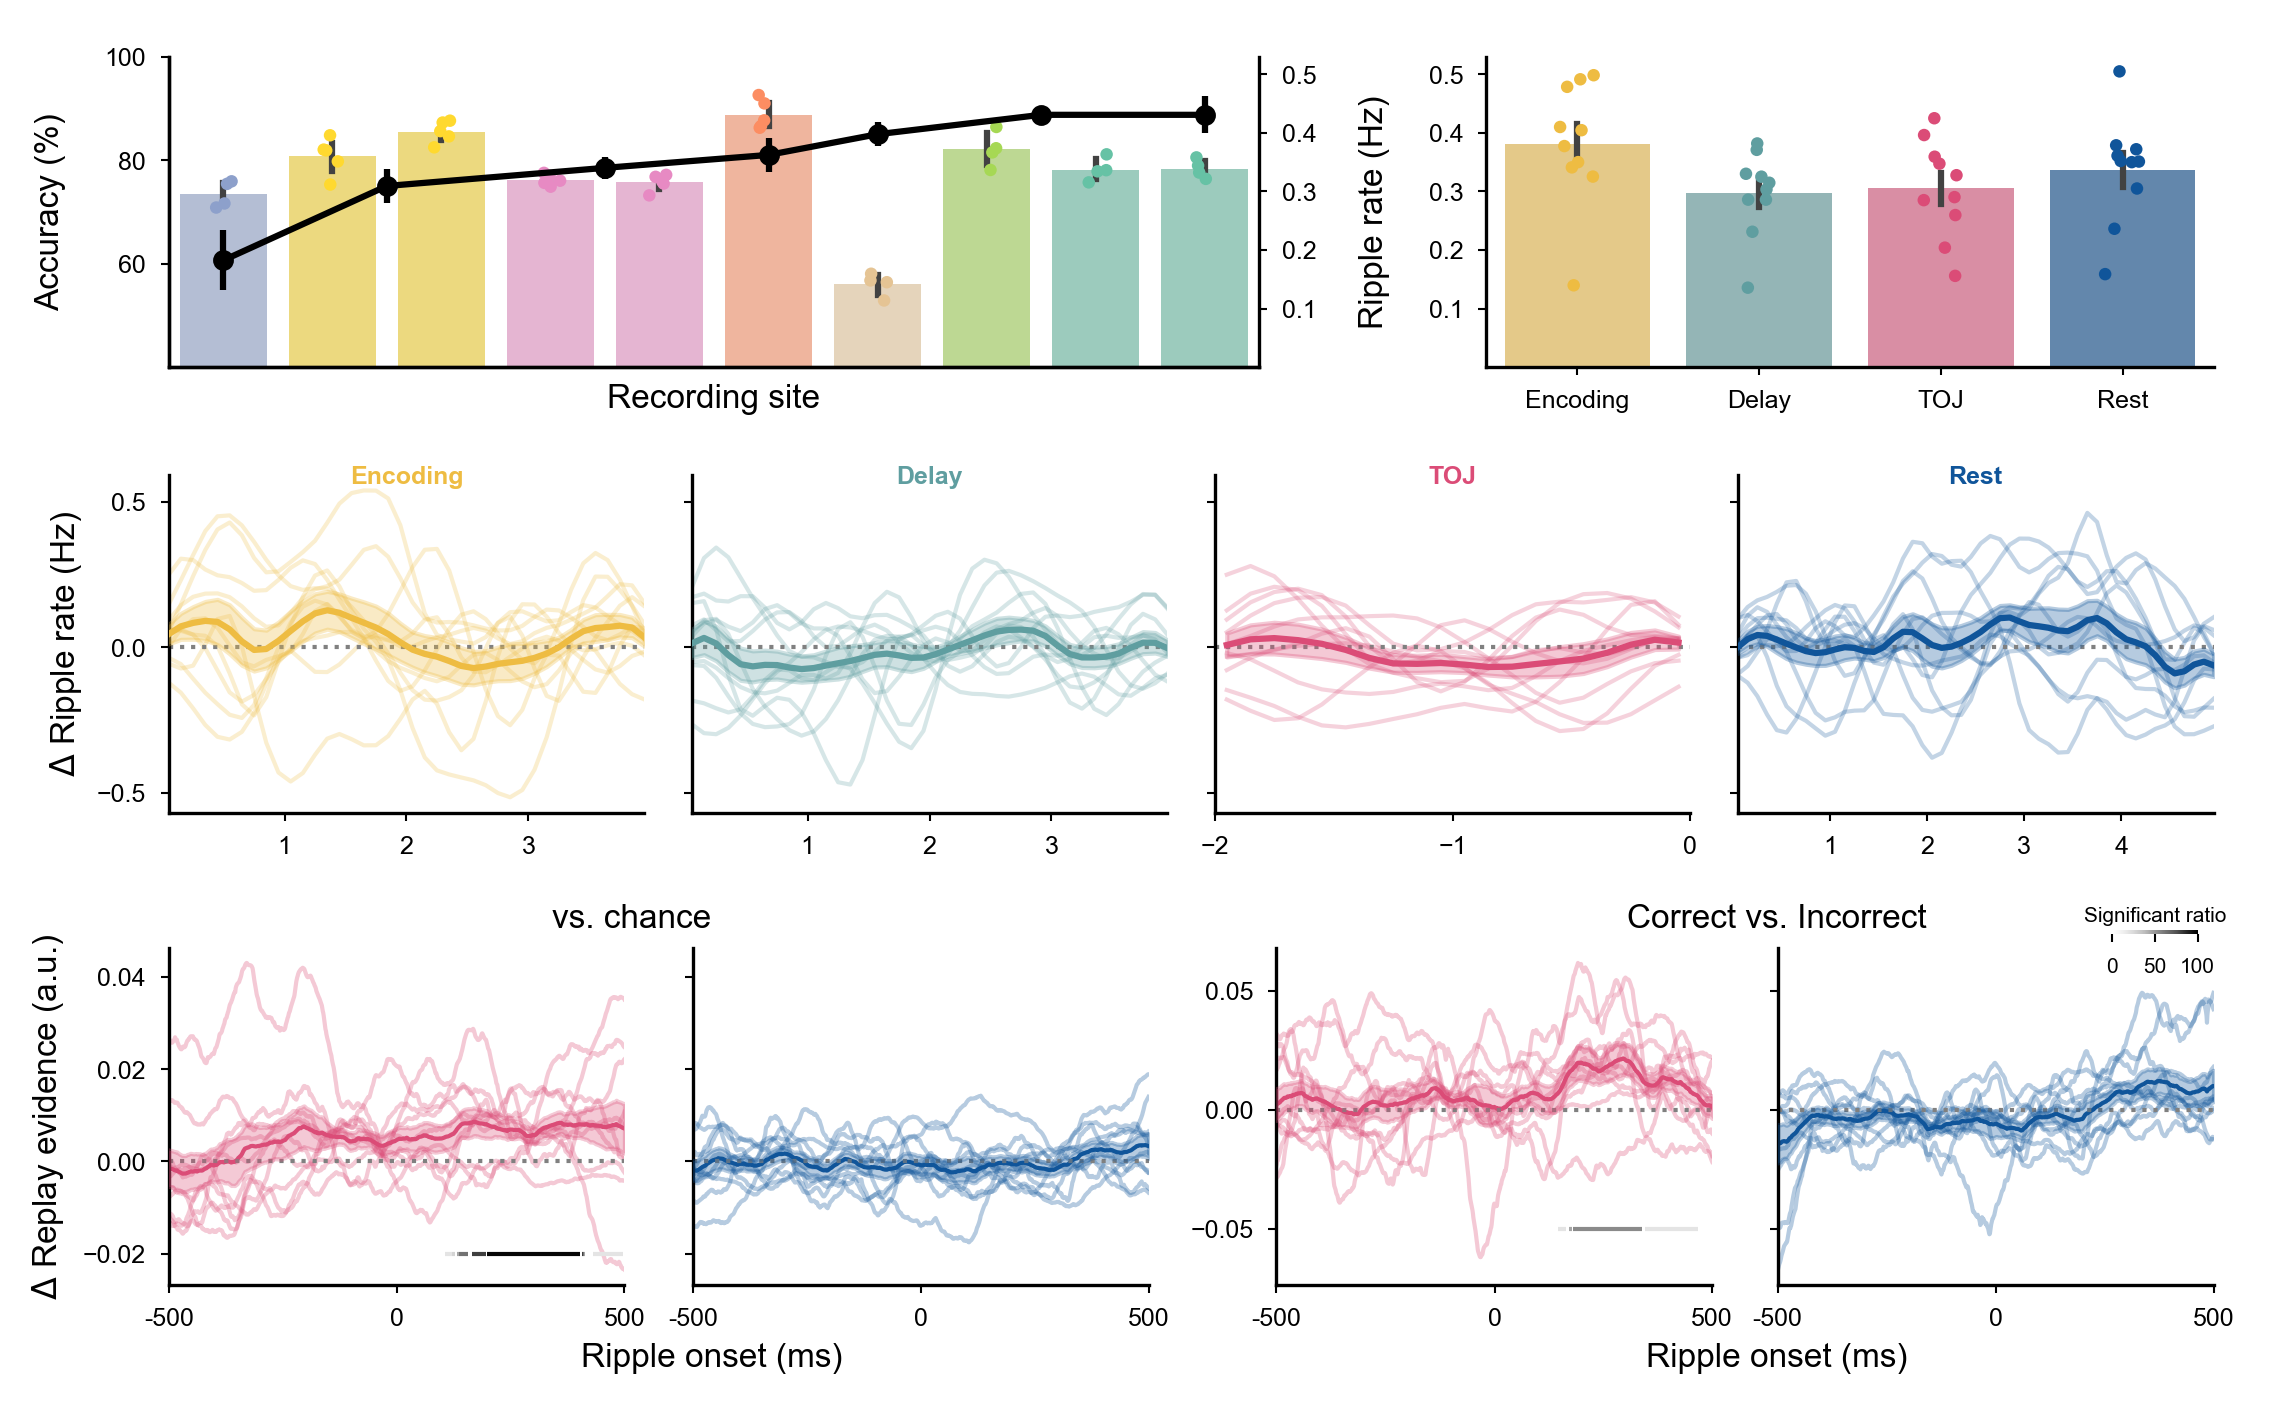

In [75]:
plt.clf()

fig = plt.figure(figsize=(7.1,4.5), dpi=300)

subfigs = fig.subfigures(
    nrows=3, ncols=1,
    height_ratios=[1,1,1.5],  
    hspace=0.05
    )  

gs_bar = subfigs[0].add_gridspec(
    nrows=1, ncols=2,
    left=0.02, top=0.98, bottom=0.75,right=.98,
    width_ratios=[1.5, 1],
    wspace=0.25
)

gs_psth = subfigs[1].add_gridspec(
    nrows=1, ncols=4,
    left=0.02, top=0.67, bottom=0.42, right=.98,
    wspace=0.1
)

sf_ripples = subfigs[2].subfigures(1, 2)

gs_null = sf_ripples[0].add_gridspec(
    nrows=1, ncols=2,
    left=0.02, top=0.32, bottom=0.07, right=.48,
    wspace=0.15
)

gs_res = sf_ripples[1].add_gridspec(
    nrows=1, ncols=2,
    left=0.54, top=0.32, bottom=0.07, right=.98,
    wspace=0.15
)


sf_ripples[0].supxlabel('Ripple onset (ms)', fontsize=8, ha='center', x=.55)
sf_ripples[1].supxlabel('Ripple onset (ms)', fontsize=8, ha='center', x=.55)

sf_ripples[0].suptitle('vs. chance', fontsize=8, ha='center', x=.475, y=.85)
sf_ripples[1].suptitle('Correct vs. Incorrect', fontsize=8, ha='center', x=.55, y=.85)



ax2 = fig.add_subplot(gs_bar[0])
ax1 = ax2.twinx()
ax1.set_zorder(ax2.get_zorder() - 1)
ax2.patch.set_visible(False)


x_vals = []
y_mean = []
y_err = []

for sub in sorted_participant:
    mask = mean_df['Subject'] == sub
    x_mean = np.mean([i for i, m in enumerate(mask) if m])
    x_vals.append(x_mean)
    y_mean.append(mean_df.loc[mask, 'mean_acc'].mean()) 
    y_err.append(mean_df.loc[mask, 'sem_acc'].mean())

ax2.plot(x_vals, y_mean, color='k', marker='o', linewidth=1.5, markersize = 4, zorder=10)
ax2.errorbar(x_vals, y_mean, yerr=y_err, color='k', capsize=0, ls = '', lw=1.5, zorder=10)

ax2.set_ylabel('Accuracy (%)')
ax2.set_xlabel('Recording site')

ax2.set_ylim(40, 100)  

ax2.set_yticks([60,  80,  100])


sns.barplot(
    data=df,
    x='Site',
    y='Rate',
    hue='Subject',
    palette='Set2',
    alpha=.7,
    legend=False,
    ax=ax1,
    zorder=1
)

sns.stripplot(
    data=df,
    x='Site',
    y='Rate',
    hue='Subject',
    palette='Set2',
    size=3,
    dodge=False,
    legend=False,
    ax=ax1,
    zorder=2,
)

ax1.set_xticks([])
ax1.set_yticks([.2,.4,.6])
ax1.set_ylabel('Ripple rate (Hz)', labelpad=10)

ax1.tick_params(axis='both', which='both', labelleft=False, labelright=True)

sns.despine(ax=ax2, right=True)
sns.despine(ax=ax1, right=False, left=False)



ax3 = fig.add_subplot(gs_bar[1], sharey=ax1)

sns.barplot(data=event_df, x='event', y='rate', hue='event', 
            order=['Encoding','Delay','TOJ','Rest'],
            palette=color_dict, legend=False, errorbar='se', units='Site', alpha=.7, zorder=1,
            ax=ax3
            )
sns.stripplot(data=event_df, x='event', y='rate', hue='event', 
              order=['Encoding','Delay','TOJ','Rest'],
              palette=color_dict, legend=False, size=3,  zorder=2,
              ax=ax3)


ax3.set_ylabel('')
ax3.set_xlabel('')
ax3.set_yticks([.1,.2,.3,.4,.5])

sns.despine(ax=ax3)


axes_psth = [fig.add_subplot(gs_psth[i]) for i in range(4)]

for ax, event in zip(axes_psth, ['Encoding','Delay','TOJ','Rest']):
    event_list= contrast_dict[event]
    for val in event_list:
        ax.plot(event_bins[event], val, color=color_dict[event], alpha=0.25, zorder=0)
    _u = np.mean(event_list, axis=0)
    _err = stats.sem(event_list, axis=0)
    lb, ub =  _u - _err, _u + _err

    ax.fill_between(event_bins[event], lb, ub, color=color_dict[event], alpha=0.3, zorder=5)  
    ax.plot(event_bins[event], _u, color=color_dict[event], linewidth=1.5, zorder=10)

    ax.set_yticks([-.5,0,.5])
    ax.axhline(0, ls='dotted', color='grey', lw=1)
    sns.despine(ax=ax)
    ax.margins(x=0)
    ax.set_title(event, fontsize=6, color=color_dict[event], fontweight='bold', y=.9)
    # ax.set_xlabel(event)
    


axes_psth[0].set_ylabel(r'$\Delta$ Ripple rate (Hz)', va='center', ha='center')
# axes_psth[-1].set_xlabel('Time (s)')
for ax in axes_psth[1:]:
    ax.sharey(axes_psth[0])
    ax.set_ylabel('')
    ax.tick_params(axis='both', which='both', labelleft=False)
    
    if ax == axes_psth[2]:
        ax.set_xticks([-2,-1,0])


axes_rr = [fig.add_subplot(gs_null[_]) for _ in range(2)] + [fig.add_subplot(gs_res[_]) for _ in range(2)]

axes_rr[0].set_ylabel(r'$\Delta$ Replay evidence (a.u.)')

for ax, event in zip(axes_rr[:2], ['TOJ', 'Rest']):
    for val in tdlm_avg[event]:
        ax.plot(val, color=color_dict[event], alpha=0.3, zorder=0)

    _u = np.mean(tdlm_avg[event],axis=0)
    _err = stats.sem(tdlm_avg[event], axis=0)
    # lb, ub = np.percentile(tdlm_avg[event], [2.5, 97.5], axis=0)
    lb, ub = _u - _err, _u + _err
    ax.fill_between(np.arange(_u.shape[0]), lb, ub, color=color_dict[event], alpha=0.3, zorder=5)
    ax.plot(_u  , color=color_dict[event], alpha=1, zorder=0)
    ax.axhline(0, ls='dotted', color='grey', lw=1)
    ax.margins(x=0)
    sns.despine(ax=ax)
    
for ax, event in zip(axes_rr[2:], ['TOJ', 'Rest']):
    group_vals = np.array(tdlm_res[event])[:,-1]
    for val in group_vals:
        ax.plot(val, color=color_dict[event], alpha=0.3, zorder=0)

    _u = np.mean(group_vals,axis=0)
    _err = stats.sem(group_vals, axis=0)
    # lb, ub = np.percentile(tdlm_avg[event], [2.5, 97.5], axis=0)
    lb, ub = _u - _err, _u + _err
    ax.fill_between(np.arange(_u.shape[0]), lb, ub, color=color_dict[event], alpha=0.3, zorder=5)
    ax.plot(_u  , color=color_dict[event], alpha=1, zorder=0)
    ax.axhline(0, ls='dotted', color='grey', lw=1)
    ax.margins(x=0)
    sns.despine(ax=ax)
    
for ax in axes_rr:
    ax.set_xticks([0,501,1000],[-500,0,500])


import matplotlib.cm as cm

vals = np.array(tdlm_avg['TOJ'])
alpha_levels = np.linspace(0.1, 1.0, 10)
for k, records in loso_si.items():
    if k[0] == 'all':
        y_pos = -.02
        if k[1] == 'TOJ':
            ax = axes_rr[0]
        else:
            ax = axes_rr[1]
    else:
        y_pos = -0.05
        if k[1] == 'TOJ':
            ax = axes_rr[2]
        else:
            ax = axes_rr[3]
            
    coverage = np.zeros(vals.shape[1])
    for rcd in records:
        coverage[rcd[1]:rcd[2]+1] += 1
    coverage = coverage / vals.shape[0]
    
    for alpha in alpha_levels:
        mask = np.where(coverage == alpha)[0]
        if mask.size > 0:
            breaks = np.where(np.diff(mask) > 1)[0]
            cluster_starts = [mask[0]] + list(mask[breaks + 1])
            cluster_ends = list(mask[breaks]) + [mask[-1]]
            
            # Plot each cluster separately
            for start, end in zip(cluster_starts, cluster_ends):
                ax.hlines(y=y_pos,  
                        xmin=start, xmax=end, 
                        color=cm.Greys(0.1+0.88*alpha),
                        )

for i in [1,3]:
    axes_rr[i].sharey(axes_rr[i-1])
    axes_rr[i].tick_params(axis='both', which='both', labelleft=False)
    
axes_rr[0].set_yticks([-.02,0,.02,.04])
axes_rr[2].set_yticks([-.05,0,.05])


import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = plt.cm.ScalarMappable(cmap=cm.Greys, norm=norm)
sm.set_array([])

sf_pos = axes_rr[-1].get_position()

cbar_ax = sf_ripples[1].add_axes([sf_pos.x1-.115, sf_pos.y0+.725, 0.08, 0.008 ])
# Add colorbar
cbar = sf_ripples[1].colorbar(sm, cax=cbar_ax, orientation='horizontal', 
                   ticks=[0,.5, 1],
                   format='%.1f')
cbar.ax.set_title('Significant ratio', fontsize=5, pad=2)
cbar.ax.tick_params(labelsize=5, labelleft=False)
cbar.ax.set_xticklabels(['0','50', '100'])

# Remove the outline of colorbar
cbar.outline.set_visible(False)

fig.align_ylabels([ax2, axes_psth[0], axes_rr[0]])


# S10

In [ ]:
_path = r'S10'

## Read data

In [ ]:
Data = [[],[]]
for i, dir in enumerate(['Vaz','Norman_single_contact']):
    fn = os.path.join(_path, f'Replication_detection_{dir}.npz')
    data = np.load(fn, allow_pickle=True)
    
    group_lfp = data['lfp']
    group_power = data['power']
    group_dict = data['histogram'].item()
    group_psth = data['psth'].item()
    group_perm = data['all_perm'].item()
    correct_perm = data['correct_perm'].item()
    
    Data[i] =  (group_lfp, group_power, group_dict, group_psth, group_perm, correct_perm)
    del data
    

Vaz_data, SNorman = Data
del Data

In [89]:
sig_cluster = np.load(os.path.join(_path, f'Replication_detection_cluster_permutation_results.npz'), allow_pickle=True)['data'].item()

## Plot

Text(0.0, 0.25, 'Norman et al. 2019 (N = 7)')

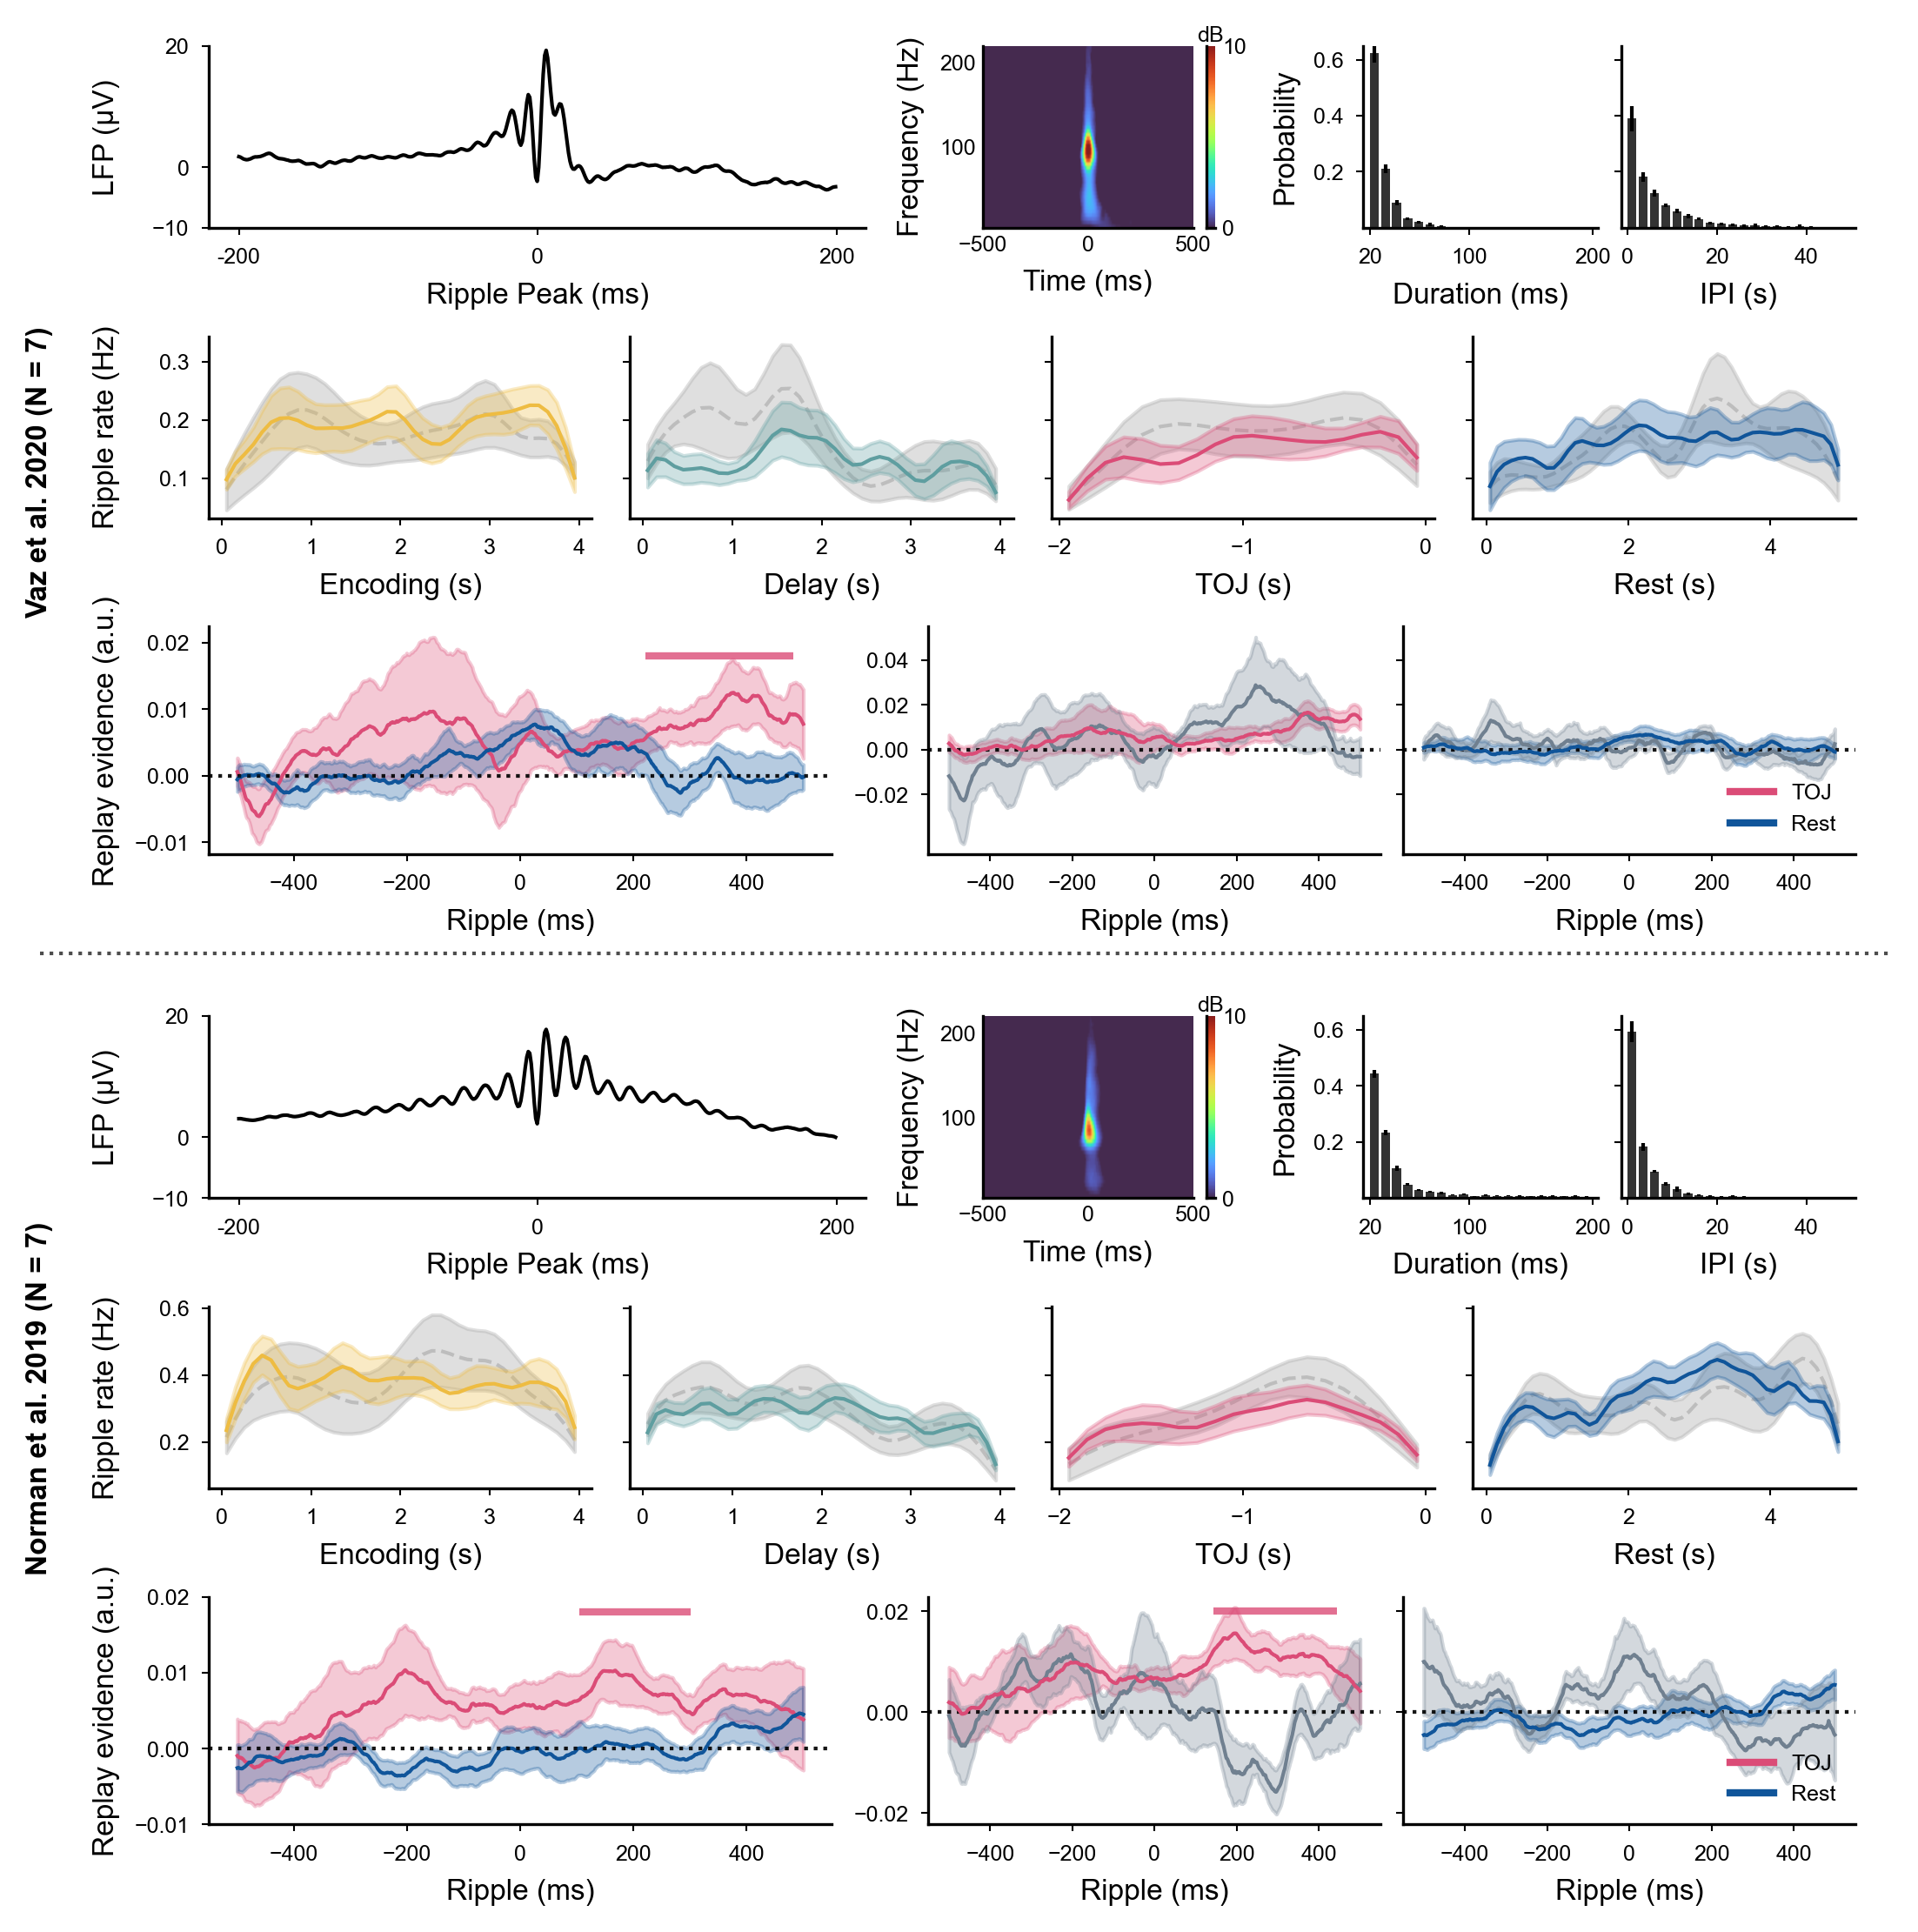

In [92]:
custom_lines = [
    Line2D([0], [0], color="#db4c77", lw=2, label="TOJ"),
    Line2D([0], [0], color="#10559a", lw=2, label="Rest"),
]

fig = plt.figure(figsize=(7.1,7.1), dpi=300)

gs = fig.add_gridspec(1,2,
                      hspace=.2, width_ratios=[.075,1], wspace=.01,
                      left=0.02, right=0.98, bottom=0.02, top=0.98)
gs_main = gs[1].subgridspec(2,1,hspace=.2)

gs_upper = gs_main[0].subgridspec(3,1,hspace=.55, height_ratios=[.8,.8,1])
gs_bottom = gs_main[1].subgridspec(3,1,hspace=.55, height_ratios=[.8,.8,1])

for gs, (group_lfp, group_power, group_dict, group_psth, group_perm, correct_perm), dataset_name in zip([gs_upper, gs_bottom], [Vaz_data, SNorman], ['Vaz', 'Norman']):
    gs_describe = gs[0].subgridspec(1, 3, wspace=.25, width_ratios = [2,.8,1.5])
    gs_hist = gs_describe[2].subgridspec(1,2, wspace=.1)

    gs_psth = gs[1].subgridspec(1,4, wspace=.1)

    gs_perm = gs[2].subgridspec(1,3, wspace=.2, width_ratios=[1.5,1,1])
    gs_subset = gs_perm[1:].subgridspec(1,2, wspace=.05)

    ax_lfp = fig.add_subplot(gs_describe[0])
    ax_spec = fig.add_subplot(gs_describe[1])
    axes_hist = [fig.add_subplot(gs_hist[0]), fig.add_subplot(gs_hist[1])]
    axes_psth = [fig.add_subplot(gs_psth[i]) for i in range(4)]
    axes_perm = [fig.add_subplot(gs_perm[0])] +  [fig.add_subplot(gs_subset[i]) for i in range(2)]  
    
    
    ax_lfp.plot(np.mean(group_lfp  * 1e6, axis=0)[800:-800] , color='k', lw=1, zorder=10)
    ax_lfp.set_xticks([0,200,401],[-200,0,200])
    ax_lfp.set_ylabel('LFP (µV)')
    ax_lfp.set_xlabel('Ripple Peak (ms)')
    
    ax_spec.imshow(np.mean(group_power, axis=0)[0][:,100:-100], cmap='turbo', aspect='auto', 
               extent=[-500, 500, 4, 220],
               origin='lower', 
               alpha=.9, vmin=0, 
               vmax=10)
    
    cbar = plt.colorbar(ax_spec.images[0], ax=ax_spec, ticks=[0, 10])
    cbar.ax.tick_params(axis='y', right=False, pad=0)
    cbar.outline.set_linewidth(0)
    cbar.ax.set_title('dB', fontsize=6, pad=0)


    ax_spec.set_xticks([-500, 0, 500])
    ax_spec.tick_params(axis='both', bottom=False, left=False, pad=0)
    ax_spec.set_xlabel('Time (ms)')
    ax_spec.set_ylabel('Frequency (Hz)')
    sns.despine(left=True, bottom=True, ax=ax_spec)

    for ax, (k, vals) in zip(axes_hist, group_dict.items()):
        if k == 'ipi':
            bins_arange = np.linspace(0, 50, 21)
            desired_ticks = [0, 20,40]
            tick_locations = [(x-0)/2.5-.4 for x in desired_ticks]
            
        else:
            bins_arange = np.linspace(25, 200, 21)
            desired_ticks = [20,100,200]
            tick_locations = [(x-20)/9-.4 for x in desired_ticks]
            
        bin_centers = (bins_arange[:-1] + bins_arange[1:]) / 2

        hist_list = list()
        for v in vals:
            if k == 'ipi':
                counts, _ = np.histogram(v / 1e3, bins=bins_arange)
            else:
                counts, _ = np.histogram(v, bins=bins_arange)
            hist_list.append(counts / counts.sum())

        mean_hist = np.mean(hist_list,axis=0)
        err_hist = stats.sem(hist_list, axis=0)
        
        sns.barplot(x=bin_centers, y=mean_hist, color='k', alpha=.8, ax=ax)
        ax.errorbar(np.arange(len(bin_centers)), mean_hist, yerr=err_hist,
                        capsize=0, ls = '',
                        lw=1,
                        color='k')
        ax.set_xticks(tick_locations, desired_ticks)
        sns.despine(ax=ax)
        
        ax.margins(x=0) 
        ax.set_xlim([-1,20])

    axes_hist[0].set_ylabel('Probability')
    axes_hist[1].set_ylabel('')
    axes_hist[1].set_xlabel('IPI (s)')
    axes_hist[0].set_xlabel('Duration (ms)')

    axes_hist[0].set_yticks([ 0.2, 0.4, 0.6])
    axes_hist[1].sharey(axes_hist[0])
    axes_hist[1].tick_params(axis='y',labelleft=False)
    axes_hist[1].set_ylim([0,.65])

    
    for event_name, ax in zip(['Encoding','Delay', 'Retrieval', 'Rest'], axes_psth):
        event = event_name if event_name != 'Retrieval' else 'TOJ'
        
        psth_corr = list()
        psth_incorr = list()

        for sub, ch_data in group_psth.items():
            for ch, event_data in ch_data.items():
                psth_corr.append(
                    event_data[event_name]['correct']
                    )
                psth_incorr.append(
                    event_data[event_name]['incorrect']
                    )
                    

        x = event_data[event_name]['bins']

        # ax.set_title(f"{event_name if event_name != 'Retrieval' else 'TOJ'}", color=color_dict[event], y =.9, fontsize=7)
        for data,label in zip([psth_corr, psth_incorr], ['Correct', 'Incorrect']):
            line_params = dict(
                color = color_dict[event] if label == 'Correct' else  "#b0b0b0",
                ls = '-' if label == 'Correct' else '--',
                zorder = 10 if label == 'Correct' else 0,
            )
            _u = np.mean(data, axis=0)
            _err = stats.sem(data, axis=0)

            ax.plot(x, _u, alpha= 1 if label == 'Correct' else 0.7, **line_params)
            ax.fill_between(x, _u - _err, _u + _err, alpha=0.3 if label == 'Correct' else 0.4, color=line_params['color'], zorder=line_params['zorder'])
            ax.set_xlabel(f"{event_name if event_name != 'Retrieval' else 'TOJ'} (s)")
        sns.despine(ax=ax)
        
    axes_psth[0].set_ylabel('Ripple rate (Hz)')
    for ax in axes_psth[1:]:
        ax.sharey(axes_psth[0])
        ax.set_ylabel('')
        # ax.set_yticks([.1,.2,.3,.4,.5])
        ax.tick_params(axis='both', which='both', labelleft=False)
        
        if ax == axes_psth[2]:
            ax.set_xticks([-2,-1,0])

    # # Ripple ~ Replay
    for event, event_vals in group_perm.items():
        vals = np.array(event_vals)
          
        u = np.mean(vals, axis=0)
        err = stats.sem(vals, axis=0)
        axes_perm[0].plot(np.arange(-500,500+1), u, label=event, color=color_dict[event])
        axes_perm[0].fill_between(np.arange(-500,500+1), u-err, u+err, alpha=.3, color=color_dict[event])
        axes_perm[0].axhline(y=0, color='k', linestyle=':', alpha=.7)

    axes_perm[0].set_xlabel('Ripple (ms)')
    axes_perm[0].set_ylabel('Replay evidence (a.u.)')


    for ax, event in zip(axes_perm[1:], ['TOJ', 'Rest']):
        vals = np.array(correct_perm[event])[:,:2]
        
        correct_u, incorr_u = vals.mean(axis=0)
        correct_err, incorr_err = stats.sem(vals, axis=0)
        
        for u, err, c in zip([correct_u, incorr_u], [correct_err, incorr_err], [color_dict[event], 'slategray']):
            ax.plot(np.arange(-500,500+1), u, label=event, color=c, zorder=10 if c != 'slategray' else 5)
            ax.fill_between(np.arange(-500,500+1), u-err, u+err, alpha=.3, color=c, zorder=0)
            ax.axhline(y=0, color='k', linestyle=':', alpha=.7, zorder=1)

        ax.set_xlabel('Ripple (ms)')

    axes_perm[2].sharey(axes_perm[1])
    axes_perm[2].tick_params(axis='y', which='both', labelleft=False)
    
    if sig_cluster[dataset_name].get('PSTH') is not None:
        for event, event_dict in sig_cluster[dataset_name]['PSTH'].items():
            for p_val, xmin, xmax in event_dict:
                axes_psth[['Encoding','Delay','Retrieval','Rest'].index(event)].hlines(0.55, xmin, xmax, 
                                                                                        color=color_dict[event if event != 'Retrieval' else 'TOJ'], 
                                                                                        alpha=0.8, lw=2)
    
    if sig_cluster[dataset_name].get('Ripple_ns') is not None:
        for event, event_dict in sig_cluster[dataset_name]['Ripple_ns'].items():
            for p_val, xmin, xmax in event_dict:
                axes_perm[0].hlines(0.018, xmin-500, xmax-500, color=color_dict[event], alpha=0.8, lw=2)
            
    
    if sig_cluster[dataset_name].get('Ripple_corr') is not None:
        for event, event_dict in sig_cluster[dataset_name]['Ripple_corr'].items():       
            for p_val, xmin, xmax in event_dict:
                axes_perm[1 + (0 if event == 'TOJ' else 1)].hlines(0.02, xmin-500, xmax-500, color=color_dict[event], alpha=0.8, lw=2)
            
    if dataset_name == 'Vaz':
        axes_perm[1].set_yticks([-.02,0,.02,.04])

    else:
        axes_perm[1].set_yticks([-.02,0,.02])
        axes_perm[0].set_yticks([-0.01,0,0.01,.02])
        
    ax_lfp.set_yticks([-10,0,20])
    ax_lfp.set_ylim([-10,20])
    
    axes_perm[-1].legend(handles=custom_lines, frameon=False, 
                     loc='lower right', bbox_to_anchor=(1, 0),
                     ncols=1, 
                     )
    
sns.despine()

fig.align_ylabels([fig.axes[ax_i] for ax_i in [0,4,8,12,16,20]])
fig.align_xlabels(fig.axes[:4])
fig.align_xlabels(fig.axes[12:16])
fig.align_xlabels(fig.axes[8:11])
fig.align_xlabels(fig.axes[20:23])


import matplotlib.lines as lines

fig.add_artist(lines.Line2D([0, 1], [0.49, 0.49], ls='dotted', color='k', alpha=.7))

fig.text(
    0.0, 0.75, 'Vaz et al. 2020 (N = 7)', fontsize=8, fontweight='bold', ha='center', va='center', rotation=90,
)

fig.text(
    0.0, 0.25, 'Norman et al. 2019 (N = 7)', fontsize=8, fontweight='bold', ha='center', va='center', rotation=90,
)

# S11

In [93]:
replay_type_colors = {
    "Both": "#F7B6DB",
    "State": "#87C2EF",
    "Time": "#B2E6C0",
    "Neither": "#D6D6D6"
}

## Read

In [ ]:
_path = r'S11'

In [ ]:
example_data =np.load(os.path.join(_path, r'Group_event_ripple_replay_example.npz'))

In [96]:
group_df = pd.read_csv(os.path.join(_path, r"WithinRipple_replay_records.csv"))
df_ratios = group_df.groupby(['Site'])['ReplayType'].value_counts(normalize=True).reset_index()
event_ratios = group_df.groupby(['Site','event']).ReplayType.value_counts(normalize=True).reset_index()

event_rates = pd.read_csv(os.path.join(_path, r"Ripple_rate_event_records.csv"))
df = event_rates.groupby(['Subject', 'event','Site']).aggregate({'duration': 'sum', 'ripple_count': 'sum'}).reset_index()
df['rate'] = df['ripple_count'] / df['duration']
df_events = pd.merge(df[df.event.isin(['TOJ','Rest'])].iloc[:,[2,1,-1]], event_ratios[event_ratios.ReplayType == 'Both'])

## Plot

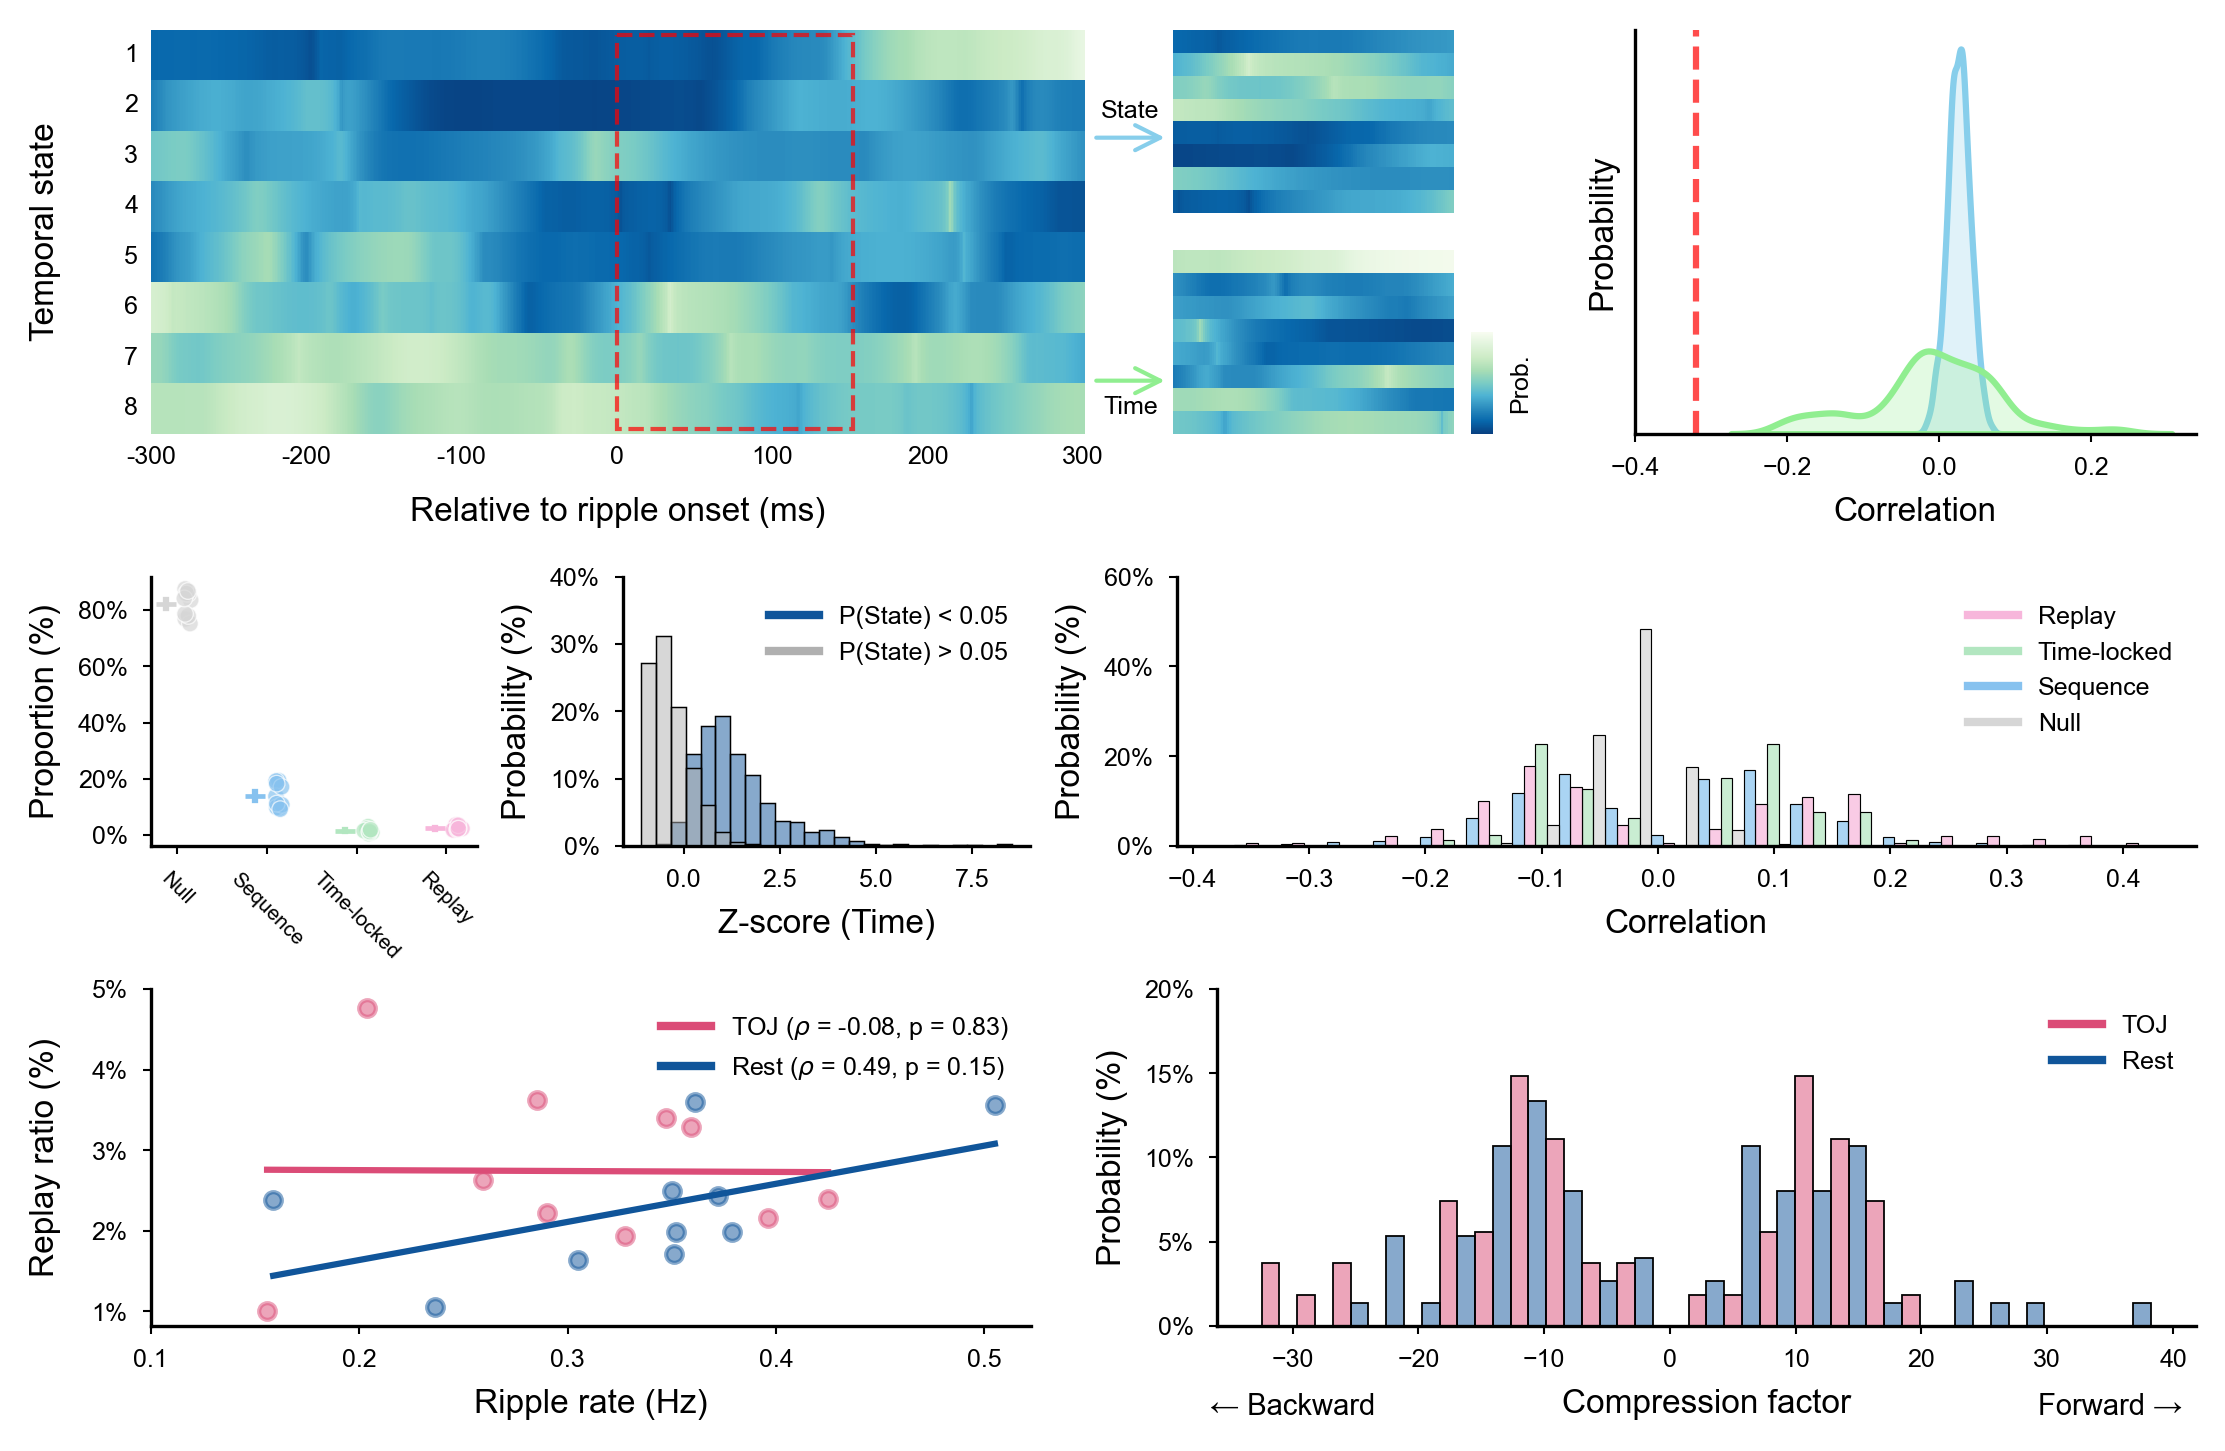

In [97]:
from matplotlib.patches import Rectangle, FancyArrowPatch

fig = plt.figure(figsize=(7.1,4.5), dpi=300)


gs = fig.add_gridspec(3,1,
                      hspace=.425, wspace=.01,
                        height_ratios=[1.2,.8,1],
                      left=0.02, right=0.98, bottom=0.02, top=0.98)

gs_method = gs[0].subgridspec(2, 4, wspace=.2, hspace=.2, width_ratios=[2.5,.75,.01,1.5])
gs_types = gs[1].subgridspec(1, 3, wspace=.25, width_ratios=[.8,1,2.5])
gs_event = gs[2].subgridspec(1, 2, wspace=.2, width_ratios=[.9,1])

ax_react = fig.add_subplot(gs_method[:, 0])
axes_cm = [fig.add_subplot(gs_method[0, 1]), fig.add_subplot(gs_method[1, 1])]
ax_chance = fig.add_subplot(gs_method[:, -1])

sns.heatmap(example_data['trial_reacti'][700:-700].T, cmap="GnBu_r", cbar=False, ax=ax_react, vmin=0, vmax=1)

rect = Rectangle((300, 0.1), example_data['duration'], 7.8, alpha=.7,
                 linewidth=1, edgecolor="red", facecolor="none", linestyle="--")
ax_react.add_patch(rect)

ax_react.tick_params(left=False, labelleft=True, bottom=False, labelbottom=True, pad=1)
ax_react.set_xticks([0,100,200,300,400,500,600],[-300,-200, -100, 0, 100, 200, 300], rotation=0)
ax_react.set_yticks(np.arange(8)+.5,np.arange(1,9), rotation=0)
ax_react.set_xlabel('Relative to ripple onset (ms)')
ax_react.set_ylabel('Temporal state')


for ax, k in zip(axes_cm, ['state_cm', 'time_cm']):
    sns.heatmap(example_data[k].T, cmap="GnBu_r", cbar=False, ax=ax, vmin=0, vmax=1)
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.axis('off')


for k, color in zip(['state_null', 'time_null'], ['skyblue', 'lightgreen']):
    sns.kdeplot(example_data[k], fill=True, lw=1.5, color=color, ax=ax_chance)

ax_chance.axvline(-.32, color="red", linestyle="--", linewidth=1.5, alpha=.7)
# # ax_c.set_title("State-shuffled null")
ax_chance.set_xlabel("Correlation")
ax_chance.tick_params(left=False, labelleft=False)
ax_chance.set_ylabel('Probability')
ax_chance.set_xticks([-0.4, -0.2, 0, 0.2])

# Row 2
ax_ratio, ax_zval, ax_corr = [fig.add_subplot(gs_types[i]) for i in range(3)]

sns.histplot(data= group_df, x= 'Correlation', bins=20, stat='probability', hue='ReplayType', 
              alpha=.7, palette=replay_type_colors, legend=False, 
             common_norm=False, common_bins=True, multiple='dodge', ax=ax_corr)

custom_lines = [
    Line2D([0], [0], color="#F7B6DB", lw=2, label="Replay"),
    Line2D([0], [0], color="#B2E6C0", lw=2, label="Time-locked"),
    Line2D([0], [0], color="#87C2EF", lw=2, label="Sequence"),
    Line2D([0], [0], color="#D6D6D6", lw=2, label="Null"),
]
ax_corr.legend(handles=custom_lines, frameon=False, 
                     loc='upper right', bbox_to_anchor=(1., .975))


sns.pointplot(data=df_ratios, x='ReplayType', y='proportion', 
            order = ['Neither', 'State','Time',  'Both' ], 
            palette=replay_type_colors, marker='_', errorbar='se', lw=1.5, markersize=5,
            hue = 'ReplayType', ax=ax_ratio)

# Map categories to numeric x positions
x_order = ['Neither', 'State', 'Time', 'Both']
x_map = {cat: i+.25 for i, cat in enumerate(x_order)}

# Compute x positions with a small offset (e.g., +0.1)
df_ratios['x_pos'] = df_ratios['ReplayType'].map(x_map) + np.random.uniform(-0.05, 0.05, len(df_ratios))


sns.scatterplot(
    data=df_ratios, x='x_pos', y='proportion',
    palette=replay_type_colors, hue='ReplayType',
    alpha=0.7, s=16, legend=False, ax=ax_ratio, zorder=0)

ax_ratio.set_xticks(np.arange(len(x_order))+.125)
ax_ratio.set_xticklabels(['Null', 'Sequence', 'Time-locked', 'Replay'], rotation=-45, fontsize=5)

ax_ratio.set_xlabel('')
ax_ratio.set_ylabel('Proportion (%)')


sns.histplot(data=group_df, x='zval_time', hue='Replay_state', bins=25, stat='probability', common_norm=False, kde=False, ax=ax_zval,
             palette={True:'#10559a', False:'#b0b0b0'}, alpha=.5,
             legend=False)  
ax_zval.set_xlabel('Z-score (Time)')


custom_lines = [
    Line2D([0], [0], color="#10559a", lw=2, label="P(State) < 0.05"),
    Line2D([0], [0], color="#b0b0b0", lw=2, label="P(State) > 0.05"),
]
ax_zval.legend(handles=custom_lines, frameon=False, 
                     loc='upper right', bbox_to_anchor=(1., .975))

# Row 3
ax_rate = fig.add_subplot(gs_event[0])
ax_compression = fig.add_subplot(gs_event[1])

sns.histplot(data=group_df[group_df.ReplayType=='Both'], x='Slope', hue='event', bins=25, stat='probability', common_norm=False, kde=False, multiple='dodge',
             palette=color_dict, alpha=.5, legend=False, 
             ax=ax_compression)
ax_compression.set_xlabel('Compression factor')

ax_compression.text(-30, -.04, '\u2190' + " Backward", fontsize=7, 
        ha='center', va='top')
ax_compression.text(35, -.04, "Forward " + '\u2192', fontsize=7,    
        ha='center', va='top')

custom_lines = [
    Line2D([0], [0], color=color_dict['TOJ'], lw=2, label='TOJ'),
    Line2D([0], [0], color=color_dict['Rest'], lw=2, label='Rest'),
]
ax_compression.legend(handles=custom_lines, frameon=False, 
                     loc='upper right', bbox_to_anchor=(1., .99))

custom_lines = list()
for event in ['TOJ', 'Rest']:
    sns.regplot(data=df_events[df_events.event==event], x='rate', y='proportion', color=color_dict[event], scatter_kws={'s':16, 'alpha':.5}, line_kws={'lw':1.5}, ax=ax_rate, ci=0)
    r, p = stats.spearmanr(df_events[df_events.event==event].rate, df_events[df_events.event==event].proportion)
    label_string = event + r' ($\rho$ = ' + f"{r:.2f}, {f'p = {p:.2f}'})"
    custom_lines.append(Line2D([0], [0], color=color_dict[event], lw=2, label=label_string))
    
ax_rate.set_yticks([.01,.02,.03,.04,.05])
ax_rate.set_xticks([.1,.2,.3,.4,.5])
ax_rate.set_xlabel('Ripple rate (Hz)')
ax_rate.set_ylabel('Replay ratio (%)')
ax_rate.legend(handles=custom_lines, frameon=False, 
                     loc='upper right', bbox_to_anchor=(1., .99))

sns.despine()
sns.despine(ax=ax_react, left=True, bottom=True)

ax_corr.set_yticks([0,.2,.4,.6])
ax_ratio.set_yticks([0,.2,.4,.6,.8])

for ax in [ax_corr, ax_ratio, ax_zval, ax_compression, ax_rate]:
    vals = ax.get_yticks()
    ax.set_yticks(vals)
    ax.set_yticklabels(['{:.0%}'.format(x) for x in vals])
    
for ax in [ax_corr, ax_zval, ax_compression]:
    ax.set_ylabel('Probability (%)')


cax_example = fig.add_axes([.64, axes_cm[-1].get_position().y0, 0.01, .075]) # left, bottom, width, height
cbar_example = fig.colorbar(axes_cm[-1].collections[0], 
                         cax=cax_example, 
                         ticks=[]
                         )

cbar_example.outline.set_visible(False)
cbar_example.ax.tick_params(bottom=False, pad=0)
cbar_example.ax.set_ylabel('Prob.', fontsize=6)


arrow1 = FancyArrowPatch(
    (0.46, 0.90), (0.5, 0.90),  # start, end (fig fraction coords)
    transform=fig.transFigure,

    arrowstyle="->", mutation_scale=15, color="skyblue")
fig.add_artist(arrow1)
fig.text(0.48, 0.92, "State", ha="center", va="center", fontsize=6)

# From Panel a → Time-shuffled
arrow2 = FancyArrowPatch(
    (0.46, 0.72), (0.5, 0.72),
    transform=fig.transFigure,
    arrowstyle="->", mutation_scale=15, color='lightgreen')
fig.add_artist(arrow2)
fig.text(0.48, 0.70, "Time", ha="center", va="center", fontsize=6)

fig.align_xlabels([ax_react, ax_chance])
fig.align_ylabels([ax_react, ax_corr, ax_ratio, ax_rate])
fig.align_ylabels([ax_ratio, ax_rate])